In [1]:
# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter
import torch.amp as amp
from torch.utils.data import TensorDataset, DataLoader

from typing import List, Tuple, Optional, Union


import tensorly as tl
from tensorly.decomposition import tucker, parafac, tensor_train
from typing import List, Union

# Numpy
import numpy as np

# Scipy
import scipy.io

# h5py for loading mat file
import h5py

# Matplotlib
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib import rc


# itertools for iterating through the list
from itertools import islice as take

# Tqdm for the progress bar
from tqdm import tqdm

# from utilities.utils import MatlabFileReader as MatReader

# Get the device
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
# device = 'cpu'

import os

# os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'
os.environ['PYTORCH_MPS_HIGH_WATERMARK_RATIO'] = '0.0'

class MatReader(object):
    def __init__(self, file_path, to_torch=True, device='cpu', to_float=True):
        super(MatReader, self).__init__()

        self.to_torch = to_torch
        self.device = device
        self.to_float = to_float

        self.file_path = file_path

        self.data = None
        self.old_mat = None
        self._load_file()

    def _load_file(self):
        try:
            self.data = scipy.io.loadmat(self.file_path)
            self.old_mat = True
        except:
            self.data = h5py.File(self.file_path)
            self.old_mat = False

    def load_file(self, file_path):
        self.file_path = file_path
        self._load_file()

    def read_field(self, field):
        x = self.data[field]

        if not self.old_mat:
            x = x[()]
            x = np.transpose(x, axes=range(len(x.shape) -1, -1, -1))

        if self.to_float:
            x = x.astype(np.float32)

        if self.to_torch:
            x = torch.from_numpy(x)

            if self.device != 'cpu':
                x = x.to(self.device)

        return x

    def set_torch(self, to_torch):
        self.to_torch = to_torch

    def set_float(self, to_float):
        self.to_float = to_float

In [2]:
# Определим базовый блок Фурье-слоя для FNO
class FourierBlock(nn.Module):
    def __init__(self, in_channels, out_channels, modes):
        super().__init__()
        """
        Инициализация Фурье-слоя:
        in_channels - входные каналы
        out_channels - выходные каналы
        modes - количество сохраняемых Фурье-мод (низкочастотные компоненты)
        """
        self.modes = modes
        self.scale = 1 / (in_channels * out_channels)
        self.in_channels = in_channels
        self.out_channels = out_channels

        # Инициализация весов в __init__ как обучаемого параметра
        self.weights = nn.Parameter(self.scale * torch.rand(self.in_channels, self.out_channels, self.modes, self.modes, self.modes, dtype=torch.cfloat))
        # [width(in), width(out), modes, modes, modes]


    def forward(self, x):

        x = x.permute(3, 2, 1, 0) # [x, y, t, in_channels] -> [in_channels, x, y, t]
        I, NT, NY, NX = x.shape

        # Прямое Фурье-преобразование по (x, y, t)
        x_ft = torch.fft.fftn(x, dim=(1, 2, 3))

        # Свёртка в частотной области

        out_ft = torch.einsum("i..., io... -> o...", x_ft[:, :self.modes, :self.modes, :self.modes], self.weights)
        # out_ft = torch.einsum("ityx,iotyx->otyx", x_ft[:, :self.modes, :self.modes, :self.modes], self.weights)
        # out_ft = torch.einsum("i...,io...->o...", x_ft[:, :self.modes, :self.modes, :self.modes], self.weights) # расходится. медленно
        # out_ft = torch.einsum("i...,io...->o...", x_ft[:, :self.modes, :self.modes, :self.modes], self.weights) # медленно, очень медленно сходится, а потом начинает расходиться
        # out_ft = torch.einsum("xyti,ixyto->oxyt", x_ft[:self.modes, :self.modes, :self.modes, :], self.weights) # быстро и обучения нет        
        # out_ft = torch.einsum("xyti,ioxyt->oxyt", x_ft[:self.modes, :self.modes, :self.modes, :], self.weights) # очень долго и обучения нет
        # out_ft = torch.einsum("xyti,xytio->xyto", x_ft[:self.modes, :self.modes, :self.modes, :], self.weights) # быстро расходится
        # out_ft = torch.einsum("xyti,ityxo->xyto", x_ft[:self.modes, :self.modes, :self.modes, :], self.weights) # Быстро но нет обучения
        # out_ft = torch.einsum("ityx,xytio->xyto", x_ft[:, :self.modes, :self.modes, :self.modes], self.weights) # Быстро но обучение почти не прогрессирует
        # out_ft = torch.einsum("ityx,iotyx->otyx", x_ft[:, :self.modes, :self.modes, :self.modes], self.weights) # oityx — расходится, iotyx — медленно и расходится
        # out_ft = torch.einsum("ityx,ityxo->tyxo", x_ft[:, :self.modes, :self.modes, :self.modes], self.weights) # быстро но нет сходмости
        # out_ft = torch.einsum("ixyt,ioxyt->oxyt", x_ft[:, :self.modes, :self.modes, :self.modes], self.weights) # медленно, то сходится, то расходится
        # out_ft = torch.einsum("ityx,ioxyt->otyx", x_ft[:, :self.modes, :self.modes, :self.modes], self.weights) # медленно, сходится потом расходится
        # out_ft = torch.einsum("tyxi,tyxio->tyxo", x_ft[:self.modes, :self.modes, :self.modes, :], self.weights) # быстро но нет обучения
        # out_ft = torch.einsum("tyxi,ixyto->tyxo", x_ft[:self.modes, :self.modes, :self.modes, :], self.weights) # быстро но нет обучения
        # out_ft = torch.einsum("tyxi,ityxo->tyxo", x_ft[:self.modes, :self.modes, :self.modes, :], self.weights) # быстро но расходится
        # out_ft = torch.einsum("ityx,xytio->tyxo", x_ft[:, :self.modes, :self.modes, :self.modes], self.weights) # быстро но нет сходимости

        
        # Обратное преобразование
        x = torch.fft.irfftn(out_ft, dim=(1, 2, 3), s=(NT, NY, NX))  # [out_channels, x, y, t]
        x = x.permute(3, 2, 1, 0) # [out_channels, x, y, t] -> [x, y, t, out_channels]
        return x



# Полная архитектура FNO
class my_FNO3D(nn.Module):
    def __init__(self, modes = 8, width = 64, fft_block_N = 1):
        super().__init__()
        """
        modes: число Фурье-мод
        width: размер скрытого представления
        hidden_dim: размер линейного скрытого представления перед обратным снижением размерности
        """
        self.modes = modes
        self.width = width
        self.hidden_dim = width * 2
        self.fft_block_N = fft_block_N
        

        # Поднимаем размерность входных данных
        self.fc0 = nn.Linear(3, width)  # [x, y, t, 3] -> [x, y, t, width]
        
        # Стек Фурье-блоков

        self.fourier_blocks = nn.ModuleList([FourierBlock(width, width, modes) for _ in range(self.fft_block_N)])
        
        # Проекция обратно в физическое пространство
        self.fc1 = nn.Linear(width, self.hidden_dim)
        self.fc2 = nn.Linear(self.hidden_dim, 1)

    def forward(self, x):
        # x: [x, y, t, 3] -> [x, y, t, width]
        x = self.fc0(x)  # Подъем размерности

        # Применяем Фурье-слои
        for block in self.fourier_blocks:
            x = x + block(x) # Residual connection
        
        x = F.gelu(self.fc1(x))
        x = self.fc2(x)
        return x

class FNO3D_PINO(my_FNO3D):
    def __init__(self, visc = 0.01, lamb=0.1, **kwargs):
        super().__init__(**kwargs)
        """
        visc: удельная вязкость
        """
        self.visc = visc
        self.lamb = lamb  # коэффициент, определяющий, сколько физического лосса в общем лоссе
        
    def physics_loss(self, w, x, y, t):  # Вычисляем физическое ограничение dw/dt + (v,grad(w)) - visc * laplasian(w) - f 
        
        f = 0.1*(torch.sin(2*np.pi*(x + y)) + torch.cos(2*np.pi*(x + y))) # Внешняя сила вводится некорректно, т.к. при рассмотрении вихревой формы Н-С берется ротор от обеих частей уравнения,
                                                                          # и, следовательно, мы здесь должны получить ротор внешней силы, а не саму силу

        if self.lamb > 0:
            
            # Вычисляем градиенты
            w_t = torch.autograd.grad(
                w, t, 
                grad_outputs=torch.ones_like(w),
                create_graph=True,
            )[0]
            
            w_x = torch.autograd.grad(
                w, x, 
                grad_outputs=torch.ones_like(w),
                create_graph=True,
            )[0]
            
            w_xx = torch.autograd.grad(
                w_x, x, 
                grad_outputs=torch.ones_like(w_x),
                create_graph=True,
            )[0]

            w_y = torch.autograd.grad(
                w, y, 
                grad_outputs=torch.ones_like(w),
                create_graph=True,
            )[0]
            
            w_yy = torch.autograd.grad(
                w_y, y, 
                grad_outputs=torch.ones_like(w_y),
                create_graph=True,
            )[0]

            # Размер сетки
            N, N, T = w.shape

            # Максимальное волновое число
            k_max = int(np.floor(N/2))

            # Фурье-образ w
            F_w = torch.fft.rfft2(w, dim = (0,1))

            # Волновые числа по Y
            k_y = torch.cat((torch.arange(start=0, end=k_max, step=1, device=w.device), torch.arange(start=-k_max, end=0, step=1, device=w.device)), 0).repeat(N,1)
            
            # Волновые числа по X
            k_x = k_y.transpose(0,1)

            # Отбрасываем лишние волновые числа
            k_x = k_x[..., :k_max + 1].unsqueeze(-1).expand(-1, -1, T)
            k_y = k_y[..., :k_max + 1].unsqueeze(-1).expand(-1, -1, T)

            # лапласиан в пространстве Фурье-образов
            F_lap = - 4 * (np.pi**2) * (k_x**2 + k_y**2)
            F_lap[0,0] = - 1.0

            # маска для деалиасинга
            dealias = torch.logical_and(torch.abs(k_y) <= (2.0/3.0)*k_max, torch.abs(k_x) <= (2.0/3.0)*k_max).float()

            # РАСЧИТАЕМ КОМПОНЕНТЫ СКОРОСТИ

            # функция потока пси в пространстве Фурье-образов
            # ПОЯСНЕНИЕ: скалярное произведение (V, grad(w))
            # сводится к псевдовекторному (псевдоскалярному) произведению grad x grad(psi) и это дает -laplasian(psi) (именно с минусом)
            # использовать градиент вихря не удобно, т.к. получить чистую скорость из него проблематично, поэтому переходят к функции тока Пси
            F_psi = - F_w / F_lap.expand(-1, -1, T)

            # компонента скорости по x = psi_y
            F_Vx = 2. * np.pi * k_y * 1j * F_psi * dealias
            Vx = torch.fft.irfft2(F_Vx, dim=(0,1)).unsqueeze(-1)

            # компонента скорости по y = -psi_x
            F_Vy = - 2. * np.pi * k_x * 1j * F_psi * dealias
            Vy = torch.fft.irfft2(F_Vy, dim=(0,1)).unsqueeze(-1)

            # распишеим (V, grad(w))
            V_scalmul_gradw = (Vx * w_x + Vy * w_y)

            # Остаток уравнения (первые два слагаемых = материальня производная w по определению)
            residual = w_t + V_scalmul_gradw - self.visc * (w_xx + w_yy) - f
        else: residual = torch.zeros_like(w)   

        return residual**2 # матрица квадратов остатков [x, y, t] — фактический аналог квадратичной ошибки (из которой мы потом посчитаем среднее)
    
    def forward(self, x, y, t):
        # Объединяем координаты
        inputs = torch.cat([x, y, t], dim=-1)
        return super().forward(inputs)
    
    def loss(self, pred, target, x, y, t):
        # Комбинированная функция потерь
        return torch.mean((1 - self.lamb) * F.mse_loss(pred, target) + self.lamb * self.physics_loss(pred, x, y, t))

In [ ]:
def validate(model, x, y, t, val_loader):
    for solution in val_loader:
        model(x, y, t)

In [3]:
def train_my_FNO(model, optimizer, epochs=10, batch_size=4, data_path='./NavierStokes_V1e-5_N1200_T20.mat', eval_percent=0.1):   
    
    EPOCHS = epochs
    BATCH_SIZE = batch_size

    data_path = data_path
    reader = MatReader(data_path)
    w = reader.read_field('u')
    N_samples, GRID_SIZE, GRID_SIZE, TIME_STEPS = w.shape

    N_eval = int(N_samples * eval_percent)

    train_dataset = w[0:N_samples-N_eval,:,:,:]
    # eval_dataset = w[N_samples-N_eval:N_samples,:,:,:]

    train_loader = DataLoader(TensorDataset(train_dataset), batch_size=BATCH_SIZE, shuffle=True)
    # eval_loader = DataLoader(TensorDataset(eval_dataset), batch_size=BATCH_SIZE, shuffle=True) 
    
    # Генерация синтетических данных на вход по следующему алгоритму:
    # 1. имеем два гиперкуба X[GRID_SIZE, GRID_SIZE, TIME_STEPS] и Y[GRID_SIZE, GRID_SIZE, TIME_STEPS] которые получены прямым транспонированием по xy
    # 2. на нижнем слое по T в них "лежат" начальные условия, остальные значения — либо нули, либо шаг по сетке с определенным инкрементом
    # 3. гиперкуб T[GRID_SIZE, GRID_SIZE, TIME_STEPS] содержит временной шаг однинаковый по x и y для заданного T
     
    x = torch.linspace(0, 1, GRID_SIZE)
    y = torch.linspace(0, 1, GRID_SIZE)
    t = torch.linspace(0, 1, TIME_STEPS)

    X_, Y_, T_ = torch.meshgrid(x, y, t, indexing='ij')

    X = X_.clone().unsqueeze(-1).requires_grad_().to(device)
    Y = Y_.clone().unsqueeze(-1).requires_grad_().to(device)
    T = T_.clone().unsqueeze(-1).requires_grad_().to(device)
    # Y = X.transpose(0,1)
   

    # Обучение
    loss_hist = []
    epoch_loss_hist = []

    for epoch in tqdm(range(EPOCHS)):
        for data in train_loader:
            for solution in data[0]:

                solution = solution.to(device)
                
                # Теперь необходимо записать начальные условия во все нулевые по Т матрицы X и Y
                with torch.no_grad():
                    X[:,:,0,0] = solution[:,:,0]
                    Y[:,:,0,0] = solution[:,:,0].T

                u_pred = model(X, Y, T).squeeze(-1)

                # Вычисление потерь
                loss = model.loss(u_pred, solution, X, Y, T)
                
                # Backprop
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                epoch_loss_hist. append(loss.item())

        epoch_mean_loss = np.asarray(epoch_loss_hist, dtype=np.float32).mean()
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch + 1}, Loss: {epoch_mean_loss:.4f}")
        loss_hist.append(epoch_mean_loss)
    
    return model, loss_hist

In [ ]:
# Создаем модель
# Здесь параметр lamb отвечает для вес физически-информированного лосса, а (1-lamb) — за вес MSE

model = FNO3D_PINO(modes = 12, width = 64, fft_block_N = 8, lamb = 0.0).to(device) 
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
my_FNO, train_hist = train_my_FNO(model, optimizer, epochs=100, batch_size=1)

Возьмем теперь последний кадр из 1000-го сэмпла для примера, и сравним с последним кадром, который нам даст модель, основываясь только на начальном кадре этого сэмпла

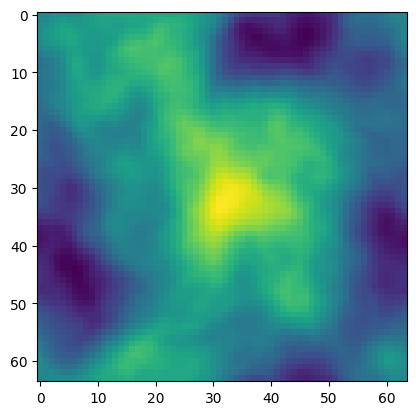

In [40]:
data_path='./NavierStokes_V1e-5_N1200_T20.mat'
data_path = data_path
reader = MatReader(data_path)
w = reader.read_field('u')
N_samples, GRID_SIZE, GRID_SIZE, TIME_STEPS = w.shape
plt.imshow(w[1000,:,:,0], cmap='viridis')
plt.show()

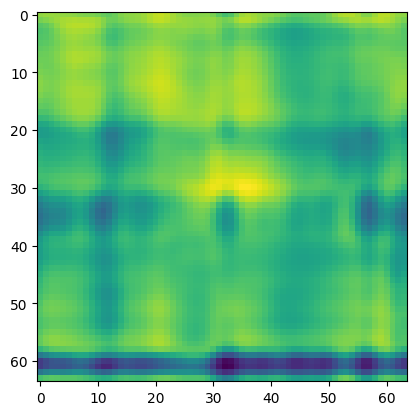

In [39]:
with torch.no_grad():
    x = torch.linspace(0, 1, GRID_SIZE)
    y = torch.linspace(0, 1, GRID_SIZE)
    t = torch.linspace(0, 1, TIME_STEPS)

    X_, Y_, T_ = torch.meshgrid(x, y, t, indexing='ij')

    X = X_.clone().unsqueeze(-1).requires_grad_().to(device)
    Y = Y_.clone().unsqueeze(-1).requires_grad_().to(device)
    T = T_.clone().unsqueeze(-1).requires_grad_().to(device)

    X[:,:,0,0] = w[1000,:,:,0]
    Y[:,:,0,0] = w[1000,:,:,0].T

    model.eval()
    plt.imshow(model(X, Y, T).squeeze(-1).cpu().numpy()[:,:,0], cmap='viridis')
    plt.show()

Решения получаются симметричными относительно оси y=-x+GRID_SIZE. Это явно ошибка свертки. Попробуем модель авторов статьи. Перепишем функцию обучения.

In [ ]:
# Set TensorLy to use PyTorch as the backend
tl.set_backend('pytorch')


class SpectralConvolution(nn.Module):
    """
    Spectral Convolution layer optimized with support for tensor factorization,
    mixed-precision training, and N-dimensional data.

    Args:
        in_channels (int): Number of input channels.
        out_channels (int): Number of output channels.
        modes (List[int]): List of modes for spectral convolution in each dimension.
        factorization (str, optional): Type of factorization to use ('dense', 'tucker', 'cp', 'tt').
                                       Defaults to 'dense' (no factorization).
        rank (int, optional): Rank for low-rank factorization. Defaults to 16.
        bias (bool, optional): Whether to include a bias term in the layer. Defaults to True.
        **kwargs: Additional parameters.
    """
    def __init__(self, in_channels: int, out_channels: int, modes: List[int], factorization: str = 'tucker', rank: int = 8, bias: bool = True, **kwargs):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes = modes
        self.dim = len(self.modes)
        self.factorization = factorization.lower()
        self.rank = rank

        # Validate factorization type
        if self.factorization not in ['dense', 'tucker', 'cp', 'tt']:
            raise ValueError("Unsupported factorization. Choose from 'dense', 'tucker', 'cp', 'tt'.")

        # Generate the mixing matrix
        self.mix_matrix = self.get_mix_matrix(self.dim)

        # Weight factorization based on selected type
        if self.factorization == 'dense':
            # Full weights without factorization
            weight_shape = (in_channels, out_channels, *self.modes)
            self.weights_real = nn.Parameter(
                nn.init.xavier_uniform_(torch.empty(weight_shape, dtype=torch.float32).contiguous())
            )
            self.weights_imag = nn.Parameter(
                nn.init.xavier_uniform_(torch.empty(weight_shape, dtype=torch.float32).contiguous())
            )
        else:
            # Initialize the full weight tensor for factorization
            full_weight_shape = (in_channels, out_channels, *self.modes)
            full_weight_real = nn.init.xavier_uniform_(torch.empty(full_weight_shape, dtype=torch.float32)).contiguous()
            full_weight_imag = nn.init.xavier_uniform_(torch.empty(full_weight_shape, dtype=torch.float32)).contiguous()

            # Apply the selected factorization separately for real and imaginary parts
            if self.factorization == 'tucker':
                core_real, factors_real = tucker(full_weight_real, rank=[self.rank] * (2 + self.dim))
                core_imag, factors_imag = tucker(full_weight_imag, rank=[self.rank] * (2 + self.dim))
                self.core_real = nn.Parameter(core_real.contiguous())
                self.core_imag = nn.Parameter(core_imag.contiguous())
                self.factors_real = nn.ParameterList([nn.Parameter(factor).contiguous() for factor in factors_real])
                self.factors_imag = nn.ParameterList([nn.Parameter(factor).contiguous() for factor in factors_imag])
            elif self.factorization == 'cp':
                factors_cp_real = parafac(full_weight_real, rank=self.rank)
                factors_cp_imag = parafac(full_weight_imag, rank=self.rank)
                self.weights_cp_real = nn.Parameter(factors_cp_real[0].contiguous())
                self.weights_cp_imag = nn.Parameter(factors_cp_imag[0].contiguous())
                self.factors_cp_real = nn.ParameterList([nn.Parameter(factor).contiguous() for factor in factors_cp_real[1]])
                self.factors_cp_imag = nn.ParameterList([nn.Parameter(factor).contiguous() for factor in factors_cp_imag[1]])
            elif self.factorization == 'tt':
                factors_tt_real = tensor_train(full_weight_real, rank=self.rank)
                factors_tt_imag = tensor_train(full_weight_imag, rank=self.rank)
                self.factors_tt_real = nn.ParameterList([nn.Parameter(factor).contiguous() for factor in factors_tt_real])
                self.factors_tt_imag = nn.ParameterList([nn.Parameter(factor).contiguous() for factor in factors_tt_imag])

        # Optional bias
        if bias:
            self.bias = nn.Parameter(torch.zeros(out_channels, dtype=torch.float32).contiguous())
        else:
            self.bias = None

    @staticmethod
    def complex_mult(input_real: torch.Tensor, input_imag: torch.Tensor, weights_real: torch.Tensor, weights_imag: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Performs complex multiplication between input and weights.

        Args:
            input_real (torch.Tensor): Real part of the input. [batch_size, in_channels, *sizes]
            input_imag (torch.Tensor): Imaginary part of the input. [batch_size, in_channels, *sizes]
            weights_real (torch.Tensor): Real part of the weights. [in_channels, out_channels, *sizes]
            weights_imag (torch.Tensor): Imaginary part of the weights. [in_channels, out_channels, *sizes]

        Returns:
            Tuple[torch.Tensor, torch.Tensor]: Real and imaginary parts of the result. [batch_size, out_channels, *sizes]
        """
        out_real = torch.einsum('bi...,io...->bo...', input_real, weights_real) - torch.einsum('bi...,io...->bo...', input_imag, weights_imag)
        out_imag = torch.einsum('bi...,io...->bo...', input_real, weights_imag) + torch.einsum('bi...,io...->bo...', input_imag, weights_real)
        return out_real, out_imag

    @staticmethod
    def get_mix_matrix(dim: int) -> torch.Tensor:
        """
        Generates a mixing matrix for spectral convolution.

        Args:
            dim (int): Dimension of the mixing matrix.

        Returns:
            torch.Tensor: Mixing matrix.

        The mixing matrix is generated in the following steps:
        1. Create a lower triangular matrix filled with ones and subtract 2 times the identity matrix to introduce negative values.
        2. Subtract 2 from the last row to ensure a distinct pattern for mixing.
        3. Set the last element of the last row to 1 to maintain a consistent matrix structure.
        4. Convert all zero elements to 1, ensuring no zero values are present.
        5. Add a row of ones at the beginning to provide an additional mixing row.
        """
        # Step 1: Create a lower triangular matrix with -1 on the diagonal and 1 elsewhere
        mix_matrix = torch.tril(torch.ones((dim, dim), dtype=torch.float32)) - 2 * torch.eye(dim, dtype=torch.float32)

        # Step 2: Subtract 2 from the last row
        mix_matrix[-1] = mix_matrix[-1] - 2

        # Step 3: Set the last element of the last row to 1
        mix_matrix[-1, -1] = 1

        # Step 4: Convert zeros in the mixing matrix to 1
        mix_matrix[mix_matrix == 0] = 1

        # Step 5: Add a row of ones at the beginning
        mix_matrix = torch.cat((torch.ones((1, dim), dtype=torch.float32), mix_matrix), dim=0)

        return mix_matrix

    def mix_weights(
        self,
        out_ft_real: torch.Tensor,
        out_ft_imag: torch.Tensor,
        x_ft_real: torch.Tensor,
        x_ft_imag: torch.Tensor,
        weights_real: Union[List[torch.Tensor], torch.Tensor],
        weights_imag: Union[List[torch.Tensor], torch.Tensor]
    ) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Mixes weights for spectral convolution.

        Args:
            out_ft_real (torch.Tensor): Real part of the output tensor in Fourier space.
            out_ft_imag (torch.Tensor): Imaginary part of the output tensor in Fourier space.
            x_ft_real (torch.Tensor): Real part of the input tensor in Fourier space.
            x_ft_imag (torch.Tensor): Imaginary part of the input tensor in Fourier space.
            weights_real (List[torch.Tensor] or torch.Tensor): Real weights.
            weights_imag (List[torch.Tensor] or torch.Tensor): Imaginary weights.

        Returns:
            Tuple[torch.Tensor, torch.Tensor]: Mixed output tensors (real and imaginary parts).
        """
        # Slicing indices based on the mixing matrix
        slices = tuple(slice(None, min(mode, x_ft_real.size(i + 2))) for i, mode in enumerate(self.modes))

        # Mix weights
        # First weight
        out_ft_real[(Ellipsis,) + slices], out_ft_imag[(Ellipsis,) + slices] = self.complex_mult(
            x_ft_real[(Ellipsis,) + slices], x_ft_imag[(Ellipsis,) + slices],
            weights_real[(Ellipsis,) + slices], weights_imag[(Ellipsis,) + slices]
        )

        if isinstance(weights_real, list) and len(weights_real) > 1:
            # Remaining weights
            for i in range(1, len(weights_real)):
                modes = self.mix_matrix[i].squeeze().tolist()
                slices = tuple(
                    slice(-min(mode, x_ft_real.size(j + 2)), None) if sign < 0 else slice(None, min(mode, x_ft_real.size(j + 2)))
                    for j, (sign, mode) in enumerate(zip(modes, self.modes))
                )
                out_ft_real[(Ellipsis,) + slices], out_ft_imag[(Ellipsis,) + slices] = self.complex_mult(
                    x_ft_real[(Ellipsis,) + slices], x_ft_imag[(Ellipsis,) + slices],
                    weights_real[i][(Ellipsis,) + slices], weights_imag[i][(Ellipsis,) + slices]
                )

        return out_ft_real, out_ft_imag

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass of the spectral convolution layer.

        Args:
            x (torch.Tensor): Input tensor of shape (batch, in_channels, D1, D2, ..., DN).

        Returns:
            torch.Tensor: Output tensor of shape (batch, out_channels, D1, D2, ..., DN).
        """
        batch_size, _, *sizes = x.shape

        # Ensure input has the expected number of dimensions
        if len(sizes) != self.dim:
            raise ValueError(f"Expected input to have {self.dim + 2} dimensions (including batch and channel), but got {len(sizes) + 2}")

        # Apply N-dimensional FFT in float32
        with amp.autocast('mps', enabled=False):
            x_ft = torch.fft.fftn(x.float(), dim=tuple(range(-self.dim, 0)), norm='ortho')

        # Separate into real and imaginary parts
        x_ft_real, x_ft_imag = x_ft.real, x_ft.imag

        # Initialize output tensors in Fourier space
        out_ft_real = torch.zeros(batch_size, self.out_channels, *sizes, dtype=x_ft_real.dtype, device=x.device)
        out_ft_imag = torch.zeros(batch_size, self.out_channels, *sizes, dtype=x_ft_imag.dtype, device=x.device)

        # Apply weight mixing based on factorization type
        if self.factorization == 'dense':
            # Use weights directly
            out_ft_real, out_ft_imag = self.mix_weights(
                out_ft_real, out_ft_imag, x_ft_real, x_ft_imag, self.weights_real, self.weights_imag
            )
        elif self.factorization == 'tucker':
            # Reconstruct weights from Tucker factorization and use them directly
            out_ft_real, out_ft_imag = self.mix_weights(
                out_ft_real, out_ft_imag, x_ft_real, x_ft_imag,
                tl.tucker_to_tensor((self.core_real, [factor for factor in self.factors_real])),
                tl.tucker_to_tensor((self.core_imag, [factor for factor in self.factors_imag]))
            )
        elif self.factorization == 'cp':
            # Reconstruct weights from CP factorization and use them directly
            out_ft_real, out_ft_imag = self.mix_weights(
                out_ft_real, out_ft_imag, x_ft_real, x_ft_imag,
                tl.cp_to_tensor((self.weights_cp_real, [factor for factor in self.factors_cp_real])),
                tl.cp_to_tensor((self.weights_cp_imag, [factor for factor in self.factors_cp_imag]))
            )
        elif self.factorization == 'tt':
            # Reconstruct weights from TT factorization and use them directly
            out_ft_real, out_ft_imag = self.mix_weights(
                out_ft_real, out_ft_imag, x_ft_real, x_ft_imag,
                tl.tt_to_tensor(self.factors_tt_real),
                tl.tt_to_tensor(self.factors_tt_imag)
            )

        # Combine real and imaginary parts
        out_ft = torch.complex(out_ft_real, out_ft_imag)

        # Apply IFFT to return to spatial domain
        out = torch.fft.ifftn(out_ft, dim=tuple(range(-self.dim, 0)), s=sizes, norm='ortho').real

        # Add bias if present
        if self.bias is not None:
            out = out + self.bias.contiguous().view(1, -1, *([1] * self.dim))

        return out
    


class FourierBlock(nn.Module):
    """
        # Fourier block.
        
        This block consists of three layers:
        1. Fourier layer: SpectralConvolution
        2. MLP layer: MLP
        3. Convolution layer: Convolution
        
    """
    def __init__(self, modes: Union[List[int], int], in_channels: int, out_channels: int, hidden_size: int = None, activation: nn.Module = nn.GELU(), bias: bool = False) -> None:
        """        
        Parameters:
        -----------
        modes: List[int] or int (Required)
            Number of Fourier modes to use in the Fourier layer (SpectralConvolution). Example: [1, 2, 3] or 4
        in_channels: int (Required)
            Number of input channels
        out_channels: int (Required)
            Number of output channels
        hidden_size: int (Optional)
            Number of hidden units in the MLP layer
        activation: nn.Module (Optional)
            Activation function to use in the MLP layer. Default: nn.GELU()
        bias: bool (Optional)
            Whether to add bias to the output. Default: False
        """
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.hidden_size = hidden_size
        self.activation = activation
        self.modes = modes
        self.dim = len(self.modes)
        self.bias = bias
        
        # Fourier layer (SpectralConvolution)
        self.fourier = SpectralConvolution(in_channels, out_channels, modes)
        
        # MLP layer
        if self.hidden_size is not None:
            self.mlp = MLP(len(self.modes), in_channels, out_channels, hidden_size, activation)
        
        # Convolution layer
        if self.dim == 2:
            self.conv = nn.Conv2d(in_channels, out_channels, 3, padding=1)
        elif self.dim == 3:
            self.conv = nn.Conv3d(in_channels, out_channels, 3, padding=1)
        else:
            self.conv = nn.Conv1d(in_channels, out_channels, 3, padding=1)
            
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Parameters:
        ----------
        x: torch.Tensor
            Input tensor of shape [batch, channels, *sizes]
        
        Returns:
        -------
        x: torch.Tensor
            Output tensor of shape [batch, channels, *sizes]
        """
        assert x.size(1) == self.in_channels, f"Input channels must be {self.in_channels} but got {x.size(1)} channels instead."
        sizes = x.size()
        
        if self.bias:
            bias = x
        
        # Fourier layer
        x_ft = self.fourier(x)
        
        # MLP layer
        if self.hidden_size is not None:
            x_mlp = self.mlp(x)
        
        # Convolution layer
        if self.dim == 2 or self.dim == 3:
            x_conv = self.conv(x)
        else:
            x_conv = self.conv(x.reshape(sizes[0], self.in_channels, -1)).reshape(*sizes)
        
        # Add
        x = x_ft + x_conv
        if self.hidden_size is not None:
            x = x + x_mlp
        if self.bias:
            x = x + bias
        # Activation
        x = self.activation(x)
        return x
    

class MLP(nn.Module):
    def __init__(self, dim: int, in_channels: int, out_channels: int, mid_channels: int, activation: nn.Module = nn.GELU()):
        """
        Multi-Layer Perceptron (MLP) module.

        Args:
            dim (int): The dimensionality of the input data. Can be 1, 2, or 3.
            in_channels (int): Number of input channels.
            out_channels (int): Number of output channels.
            mid_channels (int): Number of channels in the intermediate layer.
            activation (torch.nn.Module, optional): Activation function to be applied after the first convolutional layer. 
                Defaults to `torch.nn.GELU()`.

        """
        super().__init__()
        self.dim = dim
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.mid_channels = mid_channels
        self.activation = activation
        if self.dim == 2:
            self.mlp1 = nn.Conv2d(self.in_channels, self.mid_channels, 1)
            self.mlp2 = nn.Conv2d(self.mid_channels, self.out_channels, 1)
        elif self.dim == 3:
            self.mlp1 = nn.Conv3d(self.in_channels, self.mid_channels, 1)
            self.mlp2 = nn.Conv3d(self.mid_channels, self.out_channels, 1)
        else:
            self.mlp1 = nn.Conv1d(self.in_channels, self.mid_channels, 1)
            self.mlp2 = nn.Conv1d(self.mid_channels, self.out_channels, 1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass of the MLP module.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, channels, *spatial_dims).

        Returns:
            torch.Tensor: Output tensor of shape (batch_size, out_channels, *spatial_dims).

        """
        x = self.mlp1(x)
        x = self.activation(x)
        x = self.mlp2(x)
        return x


class FNO(nn.Module):
    """
    FNO (Fourier Neural Operator) model for solving PDEs using deep learning.
    """
    def __init__(self, modes: List[int], num_fourier_layers: int, in_channels: int, lifting_channels: int, projection_channels:int, out_channels: int, mid_channels: int, activation: nn.Module, **kwargs: bool):
        """
        Initialize the FNO model.

        Args:
            modes (List[int]): List of integers representing the number of Fourier modes along each dimension.
            num_fourier_layers (int): Number of Fourier blocks to use in the model.
            in_channels (int): Number of input channels.
            lifting_channels (int): Number of channels in the lifting layer.
            out_channels (int): Number of output channels.
            mid_channels (int): Number of channels in the intermediate layers.
            activation (nn.Module): Activation function to use.
            **kwargs (bool): Additional keyword arguments.

        Keyword Args:
            add_grid (bool): Whether to use grid information in the model.
            padding (List[int]): Padding to apply to the input tensor. [pad_dim1, pad_dim2, ...]
        """
        super().__init__()
        self.modes = modes
        self.dim = len(modes)
        self.num_fourier_layers = num_fourier_layers
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.mid_channels = mid_channels
        self.lifting_channels = lifting_channels
        self.projection_channels = projection_channels
        self.activation = activation
        self.add_grid = kwargs.get('add_grid', False)
        self.padding = kwargs.get('padding', None)
        self.sizes = [0] * self.dim
        
        
        # Format the padding
        if self.padding is not None:
            # Padd is a list of integers representing the padding along each dimension, so we need to convert it to a tuple
            self.padding = [(0, 0), (0, 0)] + [(p, p) for p in self.padding]
            # Flatten the padding
            self.padding = sum(self.padding, ())
            # Slice for removing padding [:, :, padding[0]:-padding[1], padding[2]:-padding[3],...]
            self.slice = tuple(slice(p, -p) if p > 0 else slice(None) for p in self.padding[2::2])
            
            

        # Lifting layer (P)
        if self.lifting_channels is not None:
            self.p1 = nn.Linear(self.in_channels + (self.dim if self.add_grid else 0), self.lifting_channels)
            self.p2 = nn.Linear(self.lifting_channels, self.mid_channels)
        else:
            self.p1 = nn.Linear(self.in_channels + (self.dim if self.add_grid else 0), self.mid_channels)
        

        # Fourier blocks
        self.fourier_blocks = nn.ModuleList([
            FourierBlock(modes, mid_channels, mid_channels, activation=activation)
            for _ in range(num_fourier_layers)
        ])

        # Projection layer (Q)
        self.q1 = nn.Linear(self.mid_channels,self.projection_channels)
        self.final = nn.Linear(self.projection_channels, self.out_channels)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass of the FNO model.

        Args:
            x (torch.Tensor): Input tensor. [batch, channels, *sizes]

        Returns:
            torch.Tensor: Output tensor. [batch, channels, *sizes]
        """
        batch, in_channels, *sizes = x.size()
        assert len(sizes) == self.dim, "Input tensor must have the same number of dimensions as the number of modes. Got {} dimensions, expected {}.".format(len(sizes), self.dim)
        
        # Permute the dimensions [batch, channels, *sizes] -> [batch, *sizes, channels]
        x = x.permute(0, *range(2, self.dim + 2), 1)

        # If grid is enabled, set the grid
        if self.add_grid:
            for i in range(len(sizes)):
                if sizes[i] != self.sizes[i] or self.grids[0].shape[0] != batch:
                    self.set_grid(x)
                    break
            x = torch.cat((x, self.grids), dim=-1)

        # Lifting layer
        x = self.p1(x)
        if self.lifting_channels is not None:
            x = self.p2(x)

        # Permute the dimensions [batch, *sizes, channels] -> [batch, channels, *sizes]
        x = x.permute(0, -1, *range(1, self.dim + 1))
        
        # Pad the input tensor
        if self.padding is not None:
            x = F.pad(x, self.padding[::-1])

        # Fourier blocks
        for fourier_block in self.fourier_blocks:
            x = fourier_block(x)
            
        # Remove padding
        if self.padding is not None:
            x = x[(Ellipsis,) + tuple(self.slice)]

        # Permute the dimensions [batch, channels, *sizes] -> [batch, *sizes, channels]
        x = x.permute(0, *range(2, self.dim + 2), 1)

        # Projection layer
        x = self.q1(x)

        # Activation
        x = self.activation(x)

        # Final layer
        x = self.final(x)

        return x.permute(0, -1, *range(1, self.dim + 1))

    def set_grid(self, x: torch.Tensor) -> None:
        """
        Set the grid information for the FNO model.

        Args:
            x (torch.Tensor): Input tensor.

        """
        batch, *sizes, in_channels = x.size()
        self.grids = []
        self.sizes = sizes

        # Create a grid
        for dim in range(self.dim):
            new_shape = [1] * (self.dim + 2)
            new_shape[dim + 1] = sizes[dim]
            repeats = [1] + sizes + [1]
            repeats[dim + 1] = 1
            repeats[0] = batch
            grid = torch.linspace(0, 1, sizes[dim], device=x.device, dtype=torch.float).reshape(*new_shape).repeat(repeats)
            self.grids.append(grid)
        
        self.grids = torch.cat(self.grids, dim=-1)

class PINO(FNO):
    def __init__(self, visc = 0.01, lamb=0.1, **kwargs):
        super().__init__(**kwargs)
        """
        visc: удельная вязкость
        """
        self.visc = visc
        self.lamb = lamb  # коэффициент, определяющий, сколько физического лосса в общем лоссе

        self._setup_finite_difference_filters()        

    def _setup_finite_difference_filters(self):

        dx_filter = (torch.tensor([[[[-1, 0, 1]]]]).float() / 2.0).contiguous().view(1, 1, 3, 1, 1)
        self.register_buffer('dx_f', dx_filter)
        
        dy_filter = (torch.tensor([[[[-1, 0, 1]]]]).float() / 2.0).contiguous().view(1, 1, 1, 3, 1)
        self.register_buffer('dy_f', dy_filter)
        
        dt_filter = (torch.tensor([[[[-1, 0, 1]]]]).float() / 2.0).contiguous().view(1, 1, 1, 1, 3)
        self.register_buffer('dt_f', dt_filter)
        
        # Создаем 3D фильтр лапласиана
        # laplace_filter_3d = torch.zeros(1, 1, 3, 3, 3)
        # laplace_filter_3d[0,0,:,:,1] = torch.tensor([[
        #                                            [[0, 1, 0],
        #                                             [1,-4, 1],
        #                                             [0, 1, 0]]
        #                                             ]]).float().contiguous()
        #2Д фильтр записан в 1й шаг 3Д фильтра по времени а не в нулевой, чтобы использовать padding = 1 по t,
        #если записать фильтр в нулевой шаг фильтра, то 0 шаг w по времени будет сворачиваться в нули
        #если же использовать padding=0 по t, то слои t=0 и t=T будут при 3d-свертке потеряны
        #то есть по сути наш фильтр - это 3-слойный куб, где первый слой — нули, второй слой — фильтр для 2D-послойной свертки и 3й слой — тоже нули

        # self.register_buffer('laplace_f', laplace_filter_3d)

        # d2x_filter = (torch.tensor([[[[1, -2, 1]]]]).float()).view(1, 1, 3, 1, 1)
        # self.register_buffer('d2x_f', d2x_filter)
        
        # d2y_filter = (torch.tensor([[[[1, -2, 1]]]]).float()).view(1, 1, 1, 3, 1)
        # self.register_buffer('d2y_f', d2y_filter)

    def compute_derivatives_finite_diff(self, w, dx=1.0, dy=1.0, dt=1.0):
        """Вычисление производных через конечные разности"""
        # Первые производные

        w_x = F.conv3d(w, self.dx_f, padding=(0, 0, 0)) / dx
        w_y = F.conv3d(w, self.dy_f, padding=(0, 0, 0)) / dy
        w_t = F.conv3d(w, self.dt_f, padding=(0, 0, 0)) / dt
        

        # из-за отсутствия паддинга размеры тензоров уменьшились. сделаем постпаддинг
        w_x = F.pad(w_x, (0,0, 0,0, 1,1), mode = 'replicate')  # 0,0 — t, 0,0 — y, 1,1 — x с конца
        w_y = F.pad(w_y, (0,0, 1,1, 0,0), mode = 'replicate')  # 0,0 — t, 1,1 — y, 0,0 — x с конца
        w_t = F.pad(w_t, (1,1, 0,0, 0,0), mode = 'replicate')  # 1,1 — t, 0,0 — y, 0,0 — x с конца


        """ а вот лапласиан мы не будем считать методом конечных разностей и на это есть как минимум 2 причины:
        1. лапласиан и так расчитывается в функции loss, не вижу смысла дважды тратить машинное время на эти рассчеты (и так все пипец "тормозит")
        2. в предположении, что в общем виде решение наших уравнений — все же суперпозиция периодических функций, спектральный метод дает меньшую погрешность (см. ниже)
        
        
        # Применяем 3D свертку по x и y
        laplacian = (F.conv3d(w, self.laplace_f, padding=(0, 0, 1)) / (dx**2))
        laplacian_padded = F.pad(laplacian, (0,0, 1,1, 1,1), mode = 'replicate')  
        # дорисовываем копированием соседей свернутые краевые зоны лапласиана, чтобы получить исходный размер тензора
        # почему я решил делать постпаддинг после расчета лапласиана? очень просто: так ошибка меньше
        """
        return w_x, w_y, w_t

    def physics_loss_fast(self, inputs, x, y, dx, dy, dt):
        
        if self.lamb > 0:

            f = 0.1*(torch.sin(2*np.pi*(x + y)) + torch.cos(2*np.pi*(x + y)))
            
            w = inputs.unsqueeze(1) 
            w_x, w_y, w_t = self.compute_derivatives_finite_diff(w, dx=dx, dy=dy, dt=dt)

            # Размер сетки
            B, C, N, N, T = w.shape

            # дальше начинается расчет лапласиана w спектральным методом для того чтобы перейти от фунции вихря w к функции тока psi
            # намного проще заниматься этим в фурье-пространстве

            # Максимальное волновое число
            k_max = int(np.floor(N/2))

            # Фурье-образ w
            F_w = torch.fft.rfft2(w, dim = (2,3))

            # Волновые числа по Y
            k_y = torch.cat((torch.arange(start=0, end=k_max, step=1, device=w.device), torch.arange(start=-k_max, end=0, step=1, device=w.device)), 0).repeat(N,1)
            
            # Волновые числа по X
            k_x = k_y.transpose(0,1)

            # Отбрасываем лишние волновые числа
            k_x = k_x[..., :k_max + 1].unsqueeze(-1).expand(-1, -1, T)
            k_y = k_y[..., :k_max + 1].unsqueeze(-1).expand(-1, -1, T)

            # лапласиан в пространстве Фурье-образов
            F_lap = - 4 * (np.pi**2) * (k_x**2 + k_y**2)
            F_lap[0,0] = - 1.0 # чтобы не делить на 0

            # маска для деалиасинга (опциональная история). Правило 2/3 (правило Орзага)
            # Маска реализует классическое правило 2/3 для деалиасинга:
            # Сохраняются только моды с волновыми числами ≤ (2/3)×k_max
            # Отбрасываются моды с волновыми числами > (2/3)×k_max
            # Это создает "буферную зону" между используемыми модами и пределом Найквиста
            dealias = torch.logical_and(torch.abs(k_y) <= (2.0/3.0)*k_max, torch.abs(k_x) <= (2.0/3.0)*k_max).float()

            # РАСЧИТАЕМ КОМПОНЕНТЫ СКОРОСТИ

            # функция потока пси в пространстве Фурье-образов
            # ПОЯСНЕНИЕ: скалярное произведение (V, grad(w))
            # сводится к псевдовекторному (псевдоскалярному) произведению grad x grad(psi) и это дает -laplasian(psi) (именно с минусом)
            # использовать градиент вихря не удобно, т.к. получить чистую скорость из него проблематично, поэтому переходят к функции тока Пси
            # psi = laplasian(w)
            
            F_psi = - F_w / F_lap

            # компонента скорости по x = psi_y
            F_Vx = 2. * np.pi * k_y * 1j * F_psi * dealias
            Vx = torch.fft.irfft2(F_Vx, dim=(2,3))

            # компонента скорости по y = -psi_x
            F_Vy = - 2. * np.pi * k_x * 1j * F_psi * dealias
            Vy = torch.fft.irfft2(F_Vy, dim=(2,3))

            # распишеим (V, grad(w))
            V_scalmul_grad_w = (Vx * w_x + Vy * w_y)

            laplacian_w = torch.fft.irfft2(F_lap * F_w * dealias, dim=(2,3))

            # Остаток уравнения (первые два слагаемых = материальня производная w по определению)
            residual = w_t + V_scalmul_grad_w - self.visc * laplacian_w - f
        else: residual = torch.zeros_like(inputs)   

        return (residual**2)*100 # матрица квадратов остатков [x, y, t] — фактический аналог квадратичной ошибки (из которой мы потом посчитаем среднее)            

    def physics_loss(self, inputs, x, y, t):  # Вычисляем физическое ограничение dw/dt + (v,grad(w)) - visc * laplasian(w) - f 

        if self.lamb > 0:       
    
            f = 0.1*(torch.sin(2*np.pi*(x + y)) + torch.cos(2*np.pi*(x + y))) # Внешняя сила вводится некорректно, т.к. при рассмотрении вихревой формы Н-С берется ротор от обеих частей уравнения,
                                                                              # и, следовательно, мы здесь должны получить ротор внешней силы, а не саму силу

            w = inputs.unsqueeze(1) 
    
            # Вычисляем градиенты
            w_t = torch.autograd.grad(
                w, t, 
                grad_outputs=torch.ones_like(w),
                create_graph=True,
            )[0]
            
            w_x = torch.autograd.grad(
                w, x, 
                grad_outputs=torch.ones_like(w),
                create_graph=True,
            )[0]
            
            # w_xx = torch.autograd.grad(
            #     w_x, x, 
            #     grad_outputs=torch.ones_like(w_x),
            #     create_graph=True,
            # )[0]

            w_y = torch.autograd.grad(
                w, y, 
                grad_outputs=torch.ones_like(w),
                create_graph=True,
            )[0]
            
            # w_yy = torch.autograd.grad(
            #     w_y, y, 
            #     grad_outputs=torch.ones_like(w_y),
            #     create_graph=True,
            # )[0]

            # Размер сетки
            B, C, N, N, T = w.shape

            # Максимальное волновое число
            k_max = int(np.floor(N/2))

            # Фурье-образ w
            F_w = torch.fft.rfft2(w, dim = (2,3))

            # Волновые числа по Y
            k_y = torch.cat((torch.arange(start=0, end=k_max, step=1, device=w.device), torch.arange(start=-k_max, end=0, step=1, device=w.device)), 0).repeat(N,1)
            
            # Волновые числа по X
            k_x = k_y.transpose(0,1)

            # Отбрасываем лишние волновые числа
            k_x = k_x[..., :k_max + 1].unsqueeze(-1).expand(-1, -1, T)
            k_y = k_y[..., :k_max + 1].unsqueeze(-1).expand(-1, -1, T)

            # лапласиан в пространстве Фурье-образов
            F_lap = - 4 * (np.pi**2) * (k_x**2 + k_y**2)
            F_lap[0,0] = - 1.0 # чтобы не делить на 0

            # маска для деалиасинга (опциональная история)
            dealias = torch.logical_and(torch.abs(k_y) <= (2.0/3.0)*k_max, torch.abs(k_x) <= (2.0/3.0)*k_max).float()

            # РАСЧИТАЕМ КОМПОНЕНТЫ СКОРОСТИ

            # функция потока пси в пространстве Фурье-образов
            # ПОЯСНЕНИЕ: скалярное произведение (V, grad(w))
            # сводится к псевдовекторному (псевдоскалярному) произведению grad x grad(psi) и это дает -laplasian(psi) (именно с минусом)
            # использовать градиент вихря не удобно, т.к. получить чистую скорость из него проблематично, поэтому переходят к функции тока Пси
            # psi = laplasian(w)

            F_psi = - F_w / F_lap

            # компонента скорости по x = psi_y
            F_Vx = 2. * np.pi * k_y * 1j * F_psi * dealias
            Vx = torch.fft.irfft2(F_Vx, dim=(2,3))

            # компонента скорости по y = -psi_x
            F_Vy = - 2. * np.pi * k_x * 1j * F_psi * dealias
            Vy = torch.fft.irfft2(F_Vy, dim=(2,3))

            # распишеим (V, grad(w))
            V_scalmul_gradw = (Vx * w_x + Vy * w_y)

            laplacian_w = torch.fft.irfft2(F_lap * F_w * dealias, dim=(2,3))

            # Остаток уравнения (первые два слагаемых = материальня производная w по определению)
            residual = w_t + V_scalmul_gradw - self.visc * laplacian_w - f
        else: residual = torch.zeros_like(inputs)   

        return (residual**2)*100 # матрица квадратов остатков [x, y, t] — фактический аналог квадратичной ошибки (из которой мы потом посчитаем среднее)
    
    def forward(self, inputs):
        return super().forward(inputs)
    
    def loss(self, inputs, target, X, Y, T, dx=1, dy=1, dt=1, fast=False):
        # Комбинированная функция потерь
        # print(torch.mean(nn.L1Loss()(inputs, target)), torch.mean(self.physics_loss(inputs, X, Y, T)), torch.mean(inputs))
        if fast: return torch.mean((1 - self.lamb) * nn.L1Loss()(inputs, target) + self.lamb * self.physics_loss_fast(inputs, X, Y, dx, dy, dt))
        else: return torch.mean((1 - self.lamb) * nn.L1Loss()(inputs, target) + self.lamb * self.physics_loss(inputs, X, Y, T))
    


In [ ]:
data_path='./NavierStokes_V1e-5_N1200_T20.mat'
reader = MatReader(data_path)
w = reader.read_field('u')
# dataset = NumericalSolutionDataset(w, device = device)

In [42]:
dataset[[0,1,2,3,4,5]]['input'].shape, dataset[[0,1,2,3,4,5]]['solution'].shape

(torch.Size([6, 3, 64, 64, 20]), torch.Size([6, 64, 64, 20]))

Попробуем разобраться с численными методами (конечных разносей и спектральным методом)

In [25]:
import torch
import torch.nn.functional as F
import numpy as np

# Создаем тестовую сетку
N, Nt = 4, 1
X_ = torch.linspace(0, 1, N)
Y_ = torch.linspace(0, 1, N)
T_ = torch.linspace(0, 1, Nt)

dx = 1/(N-1)

x, y, t = torch.meshgrid(X_, Y_, T_, indexing='ij')
x = x.unsqueeze(0).unsqueeze(0).requires_grad_()  # [1, 1, 6, 6, 3]
y = y.unsqueeze(0).unsqueeze(0).requires_grad_()  # [1, 1, 6, 6, 3]
t = t.unsqueeze(0).unsqueeze(0).requires_grad_()  # [1, 1, 6, 6, 3]

# Создаем тестовую функцию u = (x^2 + y^2) / 2
u = (x**2 + y**2) / 2
# u = torch.sin(2 * torch.pi * x) * torch.sin(2 * torch.pi * y)

# 1. Вычисление лапласиана с помощью autograd
def compute_laplacian_autograd(u, x, y):
    """Вычисление лапласиана через autograd"""
    # Первые производные
    u_x = torch.autograd.grad(u.sum(), x, create_graph=True)[0]
    u_y = torch.autograd.grad(u.sum(), y, create_graph=True)[0]
    
    # Вторые производные
    u_xx = torch.autograd.grad(u_x.sum(), x, create_graph=True)[0]
    u_yy = torch.autograd.grad(u_y.sum(), y, create_graph=True)[0]
    
    return u_xx + u_yy

laplacian_autograd = compute_laplacian_autograd(u, x, y)

# 2. ПРАВИЛЬНОЕ вычисление лапласиана с помощью конечных разностей
def compute_laplacian_finite_diff_correct(u, dx):
    """Правильное вычисление лапласиана через конечные разности"""
    # Создаем 2D фильтр лапласиана
    laplace_filter_2d = torch.tensor([[
        [[0, 1, 0],
         [1, -4, 1],
         [0, 1, 0]]
    ]]).float()

    # Применяем 2D свертку к каждому временному срезу
    laplacian = torch.zeros_like(u)
    for t_idx in range(u.shape[-1]):
        u_slice = u[..., t_idx]  # [1, 1, 5, 5]
        # laplacian_slice = F.conv2d(F.pad(u_slice, (1,1,1,1), mode = 'replicate'), laplace_filter_2d, padding=1)[...,1:-1,1:-1]
        laplacian_slice = F.pad(F.conv2d(u_slice, laplace_filter_2d, padding=0), (1,1,1,1), mode = 'replicate')  
        # из-за отсутсвия паддинга, при свертке потерялись края области в лапласиане, мы их добираем дублированием соседних значений     
        laplacian[..., t_idx] = laplacian_slice.squeeze(1) / (dx ** 2)
    
    return laplacian

def compute_laplacian_finite_diff_correct_tensor(u, dx):
    """здесь будут чисто тензорные вычисления без говна и циклов"""

    # Создаем 3D фильтр лапласиана
    laplace_filter_3d = torch.zeros(1,1,3,3,3)
    laplace_filter_3d[0,0,:,:,1] = torch.tensor([[
            [[0, 1, 0],
             [1,-4, 1],
             [0, 1, 0]]
    ]]).float()

    #2Д фильтр записан в 1й шаг 3Д фильтра по времени а не в нулевой, чтобы использовать padding = 1 по t,
    #если записать фильтр в нулевой шаг фильтра, то 0 шаг w по времени будет сворачиваться в нули
    #если же использовать padding=0 по t, то слои t=0 и t=T будут при 3d-свертке потеряны
    #то есть по сути наш фильтр - это 3-слойный куб, где первый слой — нули, второй слой — фильтр для 2D-послойной свертки и 3й слой — тоже нули

    # Применяем 3D свертку по x и y
    # ВАЖНО: можно было бы делать предпаддин на функицю u, а уже потому — дифференциировать, но это приводит к нежелательным значениям по краям, которые быстро увеличиваются из-за деления на dx**2
    laplacian = (F.conv3d(u, laplace_filter_3d, padding=(0,0,1)) / (dx**2))
    laplacian_padded = F.pad(laplacian, (0,0,1,1,1,1), mode = 'replicate')  #дорисовываем копированием соседей свернутые краевые зоны лапласиана, чтобы получить исходный размер тензора
    return laplacian_padded

def compute_laplacian_spectral(w):
    """здесь будет спектральный метод расчета лапласиана"""
    B, C, N, N, T = w.shape

    # Максимальное волновое число
    k_max = int(np.floor(N/2))

    # Фурье-образ w
    F_w = torch.fft.rfft2(w, dim = (2,3))

    # Волновые числа по Y
    k_y = torch.cat((torch.arange(start=0, end=k_max, step=1), torch.arange(start=-k_max, end=0, step=1)), 0).repeat(N,1)
    
    # Волновые числа по X
    k_x = k_y.transpose(0,1)

    # Отбрасываем лишние волновые числа
    k_x = k_x[..., :k_max + 1].unsqueeze(-1).expand(-1, -1, T)
    k_y = k_y[..., :k_max + 1].unsqueeze(-1).expand(-1, -1, T)

    # лапласиан в пространстве Фурье-образов
    F_lap = - 4 * (np.pi**2) * (k_x**2 + k_y**2)
    # F_lap[0,0] = - 1.0
    dealias = torch.logical_and(torch.abs(k_y) <= (2.0/3.0)*k_max, torch.abs(k_x) <= (2.0/3.0)*k_max).float()
    laplacian = torch.fft.irfft2(F_lap * F_w * dealias, dim=(2,3))
    return laplacian
 

laplacian_finite_diff = compute_laplacian_finite_diff_correct(u, dx)
laplacian_finite_diff_tensor = compute_laplacian_finite_diff_correct_tensor(u, dx)
laplacian_spectral = compute_laplacian_spectral(u)

# 3. Аналитическое решение для u = (x^2 + y^2)/2
# Лапласиан: ∇²u = ∂²u/∂x² + ∂²u/∂y² = 1 + 1 = 2
laplacian_analytic = torch.ones_like(u) * 2

# 4. Сравнение результатов
print("Сравнение методов вычисления лапласиана:")
print(f"Аналитическое решение: {laplacian_analytic.mean().item():.6f}")
print(f"Autograd: {laplacian_autograd.mean().item():.6f}")
print(f"Конечные разности: {laplacian_finite_diff.mean().item():.6f}")
print(f"Конечные разности через тензорную свертку: {laplacian_finite_diff_tensor.mean().item():.6f}")
print(f"Спектральный метод: {laplacian_spectral.mean().item():.6f}")


Сравнение методов вычисления лапласиана:
Аналитическое решение: 2.000000
Autograd: 2.000000
Конечные разности: 2.000000
Конечные разности через тензорную свертку: 2.000000
Спектральный метод: 0.000000


In [ ]:
# Для периодических функций спектральный метод дает очень маленькую ошибку
((laplacian_finite_diff-laplacian_autograd)**2).mean(), ((laplacian_finite_diff_tensor-laplacian_autograd)**2).mean(), ((laplacian_spectral-laplacian_autograd)**2).mean()

(tensor(1650.5248, grad_fn=<MeanBackward0>),
 tensor(1650.5248, grad_fn=<MeanBackward0>),
 tensor(817.2473, grad_fn=<MeanBackward0>))

In [ ]:
# В то время как для непериодических — происходит полнейшая прямо шляпа
((laplacian_finite_diff-laplacian_autograd)**2).mean(), ((laplacian_finite_diff_tensor-laplacian_autograd)**2).mean(), ((laplacian_spectral-laplacian_autograd)**2).mean()

(tensor(4.4294e-12, grad_fn=<MeanBackward0>),
 tensor(4.4294e-12, grad_fn=<MeanBackward0>),
 tensor(410.7457, grad_fn=<MeanBackward0>))

In [7]:
def train_FNO(model, optimizer, scheduler=None, EPOCHS=10, BATCH_SIZE=4, data_path='./NavierStokes_V1e-5_N1200_T20.mat', eval_percent=0.1, downsample=False, fast_deriv=False, is_Broyden=False):   
    
    reader = MatReader(data_path)
    w = reader.read_field('u')
    N_samples, GRID_SIZE, GRID_SIZE, TIME_STEPS = w.shape
    if downsample:
        w = w.permute(0,3,1,2)
        GRID_SIZE = int(np.floor(GRID_SIZE/2))
        w = F.interpolate(w, size=(GRID_SIZE, GRID_SIZE), mode='bicubic', align_corners=False)
        w = w.permute(0,2,3,1)


    eval_percent = eval_percent
    N_eval = int(N_samples * eval_percent)
  
    # np.random.seed(333)
    # all_idx = np.arange(N_samples)
    # eval_idx = np.random.choice(all_idx, N_eval)
    # train_idx = all_idx[~np.in1d(all_idx, eval_idx)]

    train_dataset = w[0:N_samples-N_eval,:,:,:]
    eval_dataset = w[N_samples-N_eval:N_samples,:,:,:]

    train_loader = DataLoader(TensorDataset(train_dataset), batch_size=BATCH_SIZE, shuffle=True)
    eval_loader = DataLoader(TensorDataset(eval_dataset), batch_size=BATCH_SIZE, shuffle=True)
        
    
    # Генерация синтетических данных на вход по следующему алгоритму:
    # 1. имеем два гиперкуба X[GRID_SIZE, GRID_SIZE, TIME_STEPS] и Y[GRID_SIZE, GRID_SIZE, TIME_STEPS] которые получены прямым транспонированием по xy
    # 2. на нижнем слое по T в них "лежат" начальные условия, остальные значения — либо нули, либо шаг по сетке с определенным инкрементом
    # 3. гиперкуб T[GRID_SIZE, GRID_SIZE, TIME_STEPS] содержит временной шаг однинаковый по x и y для заданного T

    dx, dy, dt = 1/(GRID_SIZE - 1), 1/(GRID_SIZE - 1), 1/(TIME_STEPS - 1)

    x = torch.linspace(0, 1, GRID_SIZE)
    y = torch.linspace(0, 1, GRID_SIZE)
    t = torch.linspace(0, 1, TIME_STEPS)

    X_, Y_, T_ = torch.meshgrid(x, y, t, indexing='ij')
    
    # Обучение
    loss_hist = []
    mae_hist = []
    epoch_loss_hist = []
    epoch_mae_hist = []

    for epoch in tqdm(range(EPOCHS)):
        for solution in train_loader:
            solution = solution[0].to(device)
            BATCH_S, _, _, _ = solution.shape
            X = torch.cat(BATCH_S * [X_.clone().unsqueeze(0)]).unsqueeze(1).requires_grad_().to(device)
            Y = torch.cat(BATCH_S * [Y_.clone().unsqueeze(0)]).unsqueeze(1).requires_grad_().to(device)
            T = torch.cat(BATCH_S * [T_.clone().unsqueeze(0)]).unsqueeze(1).requires_grad_().to(device)
            input = torch.cat([X,Y,T], dim=1)
            
            # "наивным" образом запишем в x и y начальные условия:
            input[ :, 0, :, :, 0] = solution[:,:,:,0]
            input[ :, 1, :, :, 0] = solution[:,:,:,0].transpose(1,2)

            if is_Broyden:
                def closure():
                    if torch.is_grad_enabled():
                        optimizer.zero_grad()
                    u_pred = model(input).squeeze(1)
                    # Вычисление потерь
                    if fast_deriv: 
                        loss = model.loss(u_pred, solution, X, Y, T, dx, dy, dt, fast=fast_deriv)
                    else: 
                        loss = model.loss(u_pred, solution, X, Y, T)
                    epoch_loss_hist.append(loss.item())
                    # loss = F.mse_loss(u_pred, solution)
                    # mae = nn.L1Loss()(u_pred, solution)
                    if loss.requires_grad:
                        loss.backward(retain_graph=True)
                    return loss
                optimizer.step(closure)
            else:
                u_pred = model(input).squeeze(1)
                if fast_deriv: 
                    loss = model.loss(u_pred, solution, X, Y, T, dx, dy, dt, fast=fast_deriv)
                else: 
                    loss = model.loss(u_pred, solution, X, Y, T)            
            # Backprop
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                # epoch_mae_hist.append(mae.item())

        epoch_mean_loss = np.asarray(epoch_loss_hist, dtype=np.float32).mean()
        # mae_mean = np.asarray(epoch_mae_hist, dtype=np.float32).mean()
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch + 1}, Loss: {epoch_mean_loss:.4f}")
        loss_hist.append(epoch_mean_loss)
        # mae_hist.append(mae_mean)
        if scheduler: scheduler.step()
    
    return model, loss_hist

In [ ]:
# Создаем модель
model = PINO(modes = [12,12,12], num_fourier_layers=1, in_channels=3, lifting_channels=None, mid_channels=32, projection_channels=64, out_channels=1, activation=nn.GELU(), lamb=0).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
model_FNO, loss_hist = train_FNO(model, optimizer, EPOCHS=100, BATCH_SIZE=8, data_path='./NavierStokes_V1e-5_N1200_T20.mat', eval_percent=0.1)

In [ ]:
# Создаем модель
# model = PINO(modes = [4,4,4], num_fourier_layers=1, in_channels=3, lifting_channels=None, mid_channels=32, projection_channels=64, out_channels=1, activation=nn.GELU(), lamb=0).to(device)
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
# model_FNO, loss_hist = train_FNO(model, optimizer, EPOCHS=3000, BATCH_SIZE=1, data_path='./NavierStokes_V1e-5_N1200_T20.mat', eval_percent=0.1)

  3%|▎         | 100/3000 [1:49:43<53:03:17, 65.86s/it]

Epoch 100, Loss: 0.3771


  7%|▋         | 200/3000 [3:39:28<51:13:33, 65.86s/it]

Epoch 200, Loss: 0.3545


 10%|█         | 300/3000 [5:29:11<49:23:40, 65.86s/it]

Epoch 300, Loss: 0.3442


 13%|█▎        | 400/3000 [7:18:55<47:33:26, 65.85s/it]

Epoch 400, Loss: 0.3379


 17%|█▋        | 500/3000 [9:08:37<45:43:52, 65.85s/it]

Epoch 500, Loss: 0.3335


 20%|██        | 600/3000 [10:58:24<43:54:09, 65.85s/it]

Epoch 600, Loss: 0.3302


 23%|██▎       | 700/3000 [12:48:09<42:01:19, 65.77s/it]

Epoch 700, Loss: 0.3276


 27%|██▋       | 800/3000 [14:37:57<40:15:14, 65.87s/it]

Epoch 800, Loss: 0.3255


 30%|███       | 900/3000 [16:27:42<38:24:22, 65.84s/it]

Epoch 900, Loss: 0.3237


 33%|███▎      | 1000/3000 [18:17:21<36:23:33, 65.51s/it]

Epoch 1000, Loss: 0.3222


 37%|███▋      | 1100/3000 [20:07:05<34:45:41, 65.86s/it]

Epoch 1100, Loss: 0.3208


 40%|████      | 1200/3000 [21:56:50<32:56:08, 65.87s/it]

Epoch 1200, Loss: 0.3197


 43%|████▎     | 1300/3000 [23:46:48<31:10:32, 66.02s/it]

Epoch 1300, Loss: 0.3186


 47%|████▋     | 1400/3000 [25:36:44<29:18:45, 65.95s/it]

Epoch 1400, Loss: 0.3177


 50%|█████     | 1500/3000 [27:26:41<27:28:57, 65.96s/it]

Epoch 1500, Loss: 0.3169


 53%|█████▎    | 1600/3000 [29:16:23<25:36:17, 65.84s/it]

Epoch 1600, Loss: 0.3161


 57%|█████▋    | 1700/3000 [31:06:12<23:42:56, 65.67s/it]

Epoch 1700, Loss: 0.3154


 60%|██████    | 1800/3000 [32:56:05<21:58:52, 65.94s/it]

Epoch 1800, Loss: 0.3148


 63%|██████▎   | 1900/3000 [34:46:01<20:09:52, 65.99s/it]

Epoch 1900, Loss: 0.3142


 67%|██████▋   | 2000/3000 [36:35:54<18:15:15, 65.72s/it]

Epoch 2000, Loss: 0.3137


 70%|███████   | 2100/3000 [38:25:45<16:28:40, 65.91s/it]

Epoch 2100, Loss: 0.3132


 73%|███████▎  | 2200/3000 [40:15:44<14:40:27, 66.03s/it]

Epoch 2200, Loss: 0.3127


 77%|███████▋  | 2300/3000 [42:05:40<12:45:30, 65.61s/it]

Epoch 2300, Loss: 0.3123


 80%|████████  | 2400/3000 [43:55:31<10:56:11, 65.62s/it]

Epoch 2400, Loss: 0.3119


 83%|████████▎ | 2500/3000 [45:45:28<9:10:21, 66.04s/it] 

Epoch 2500, Loss: 0.3115


 87%|████████▋ | 2600/3000 [47:35:33<7:20:34, 66.09s/it]

Epoch 2600, Loss: 0.3111


 90%|█████████ | 2700/3000 [49:25:37<5:30:16, 66.05s/it]

Epoch 2700, Loss: 0.3108


 93%|█████████▎| 2800/3000 [51:15:43<3:40:14, 66.07s/it]

Epoch 2800, Loss: 0.3105


 97%|█████████▋| 2900/3000 [53:05:50<1:50:08, 66.08s/it]

Epoch 2900, Loss: 0.3102


100%|██████████| 3000/3000 [54:55:52<00:00, 65.92s/it]  

Epoch 3000, Loss: 0.3099


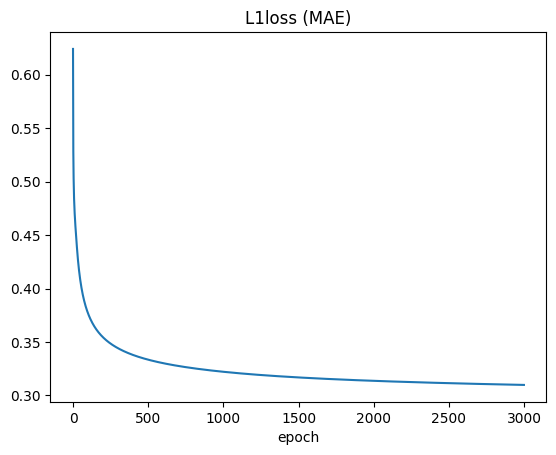

In [13]:
plt.plot(np.arange(len(loss_hist)), loss_hist)
plt.title('L1loss (MAE)')
plt.xlabel("epoch")
plt.show()

По-хорошему после 500 эпох никакой особой ценности дальнейшее обучение привносить не должно

In [ ]:
data_path='./NavierStokes_V1e-5_N1200_T20.mat'
reader = MatReader(data_path)
w = reader.read_field('u')
plt.imshow(w[1000,:,:,18], cmap='viridis')
plt.show()

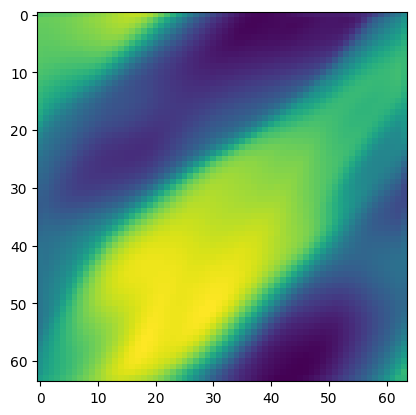

In [13]:
with torch.no_grad():
    
    N_samples, GRID_SIZE, GRID_SIZE, TIME_STEPS = w.shape

    x = torch.linspace(0, 1, GRID_SIZE)
    y = torch.linspace(0, 1, GRID_SIZE)
    t = torch.linspace(0, 1, TIME_STEPS)

    X_, Y_, T_ = torch.meshgrid(x, y, t, indexing='ij')

    X = X_.clone().unsqueeze(0).unsqueeze(1).to(device)
    Y = Y_.clone().unsqueeze(0).unsqueeze(1).to(device)
    T = T_.clone().unsqueeze(0).unsqueeze(1).to(device)
    
    input = torch.cat([X,Y,T], dim=1)

    input[0, 0, :, :, 0] = w[1000,:,:,0]
    input[0, 1, :, :, 0] = w[1000,:,:,0].T


    model.eval()
    output = model(input)
    plt.imshow(output[0,0,:,:,18].cpu().numpy(), cmap='viridis')
    plt.show()

In [5]:
# model = torch.load('naive_12_12_12_fl_8_lift_None_mc_32_pc_64_ReLU_lamb_00_E_100_BS_1_260717.pth', weights_only=False).to(device)

In [ ]:
# ani.save(f'NS_smp{N_sample}.gif', writer="pillow", fps=10)

In [ ]:
# model = PINO(modes = [12,12,12], num_fourier_layers=8, in_channels=3, lifting_channels=None, mid_channels=32, projection_channels=64, out_channels=1, activation=nn.ReLU(), lamb=0).to(device)
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
# model_FNO, loss_hist = train_FNO(model, optimizer, EPOCHS=200, BATCH_SIZE=1, data_path='./NavierStokes_V1e-5_N1200_T20.mat', eval_percent=0.1)

 50%|█████     | 100/200 [14:34:43<14:55:41, 537.41s/it]

Epoch 100, Loss: 0.1958


100%|██████████| 200/200 [29:13:32<00:00, 526.06s/it]   

Epoch 200, Loss: 0.1632


In [ ]:
# model = PINO(modes = [12,12,12], num_fourier_layers=8, in_channels=3, lifting_channels=None, mid_channels=32, projection_channels=64, out_channels=1, activation=nn.ReLU(), lamb=0).to(device)
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.5)
# model_FNO, loss_hist = train_FNO(model, optimizer, scheduler, EPOCHS=500, BATCH_SIZE=1, data_path='./NavierStokes_V1e-5_N1200_T20.mat', eval_percent=0.1, downsample=True)

 20%|██        | 100/500 [7:29:52<30:02:12, 270.33s/it]

Epoch 100, Loss: 0.1804


 40%|████      | 200/500 [15:00:18<22:31:30, 270.30s/it]

Epoch 200, Loss: 0.1505


 60%|██████    | 300/500 [22:30:23<14:59:54, 269.97s/it]

Epoch 300, Loss: 0.1365


 80%|████████  | 400/500 [29:59:06<7:27:35, 268.55s/it] 

Epoch 400, Loss: 0.1282


100%|██████████| 500/500 [37:25:17<00:00, 269.43s/it]  

Epoch 500, Loss: 0.1227


In [ ]:
plt.plot(np.arange(len(loss_hist)), loss_hist)
plt.title('L1loss (MAE)')
plt.xlabel("epoch")
plt.show()

In [ ]:
# model = PINO(modes = [12,12,12], num_fourier_layers=8, in_channels=3, lifting_channels=None, mid_channels=32, projection_channels=64, out_channels=1, activation=nn.ReLU(), lamb=0.1).to(device)
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.5)
# model_PINO, loss_hist = train_FNO(model, optimizer, scheduler, EPOCHS=400, BATCH_SIZE=1, data_path='./NavierStokes_V1e-5_N1200_T20.mat', eval_percent=0.1, downsample=True, fast_deriv=True)

 25%|██▌       | 100/400 [6:39:44<19:58:17, 239.66s/it]

Epoch 100, Loss: 0.6845


 50%|█████     | 200/400 [13:19:40<13:20:01, 240.01s/it]

Epoch 200, Loss: 0.6319


 75%|███████▌  | 300/400 [20:01:59<6:41:14, 240.74s/it] 

Epoch 300, Loss: 0.6101


100%|██████████| 400/400 [26:42:38<00:00, 240.40s/it]  

Epoch 400, Loss: 0.5979


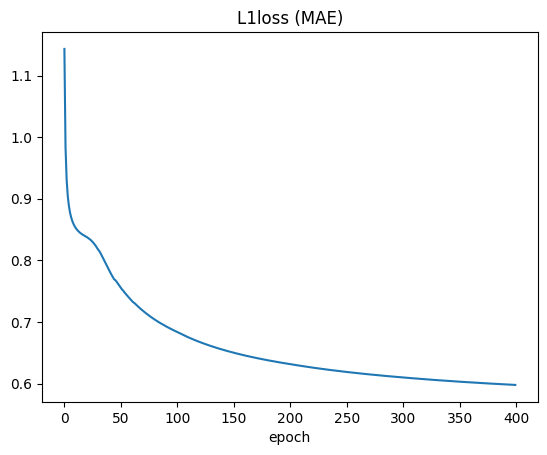

In [42]:
plt.plot(np.arange(len(loss_hist)), loss_hist)
plt.title('L1loss (MAE)')
plt.xlabel("epoch")
plt.show()

Адам не справляется со сходимостью PINO. Здесь нужен либо какой-то другой оптимизатор, либо нужно менять архитектуру модели.

Как выяснилось: проблема не в Адаме, а в неверно выбранных параметрах: вязкости, шаге по времени, краевых условиях.

In [ ]:
model = PINO(modes = [12,12,12], 
             num_fourier_layers=4, 
             in_channels=3, 
             lifting_channels=None, 
             mid_channels=32, 
             projection_channels=64, 
             out_channels=1, 
             activation=nn.ReLU(), 
             lamb=0).to(device)


optimizer_Adam = torch.optim.Adam(model.parameters(), lr=1e-4)

optimizer_Broyden = torch.optim.LBFGS(model.parameters(), 
                                lr=1, 
                                history_size=20,
                                max_iter=15, 
                                line_search_fn=None)

# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.5)

model_PINO, loss_hist = train_FNO(model=model, 
                                  optimizer=optimizer_Broyden,
                                  scheduler=None,
                                  EPOCHS=100, 
                                  BATCH_SIZE=128, 
                                  data_path='./NavierStokes_V1e-5_N1200_T20.mat', 
                                  eval_percent=0.1, 
                                  downsample=True, 
                                  fast_deriv=True,
                                  is_Broyden=True)

In [15]:
dx_filter = (torch.tensor([[[[-1, 0, 1]]]]).float() / 2.0).contiguous().view(1, 1, 3, 1, 1)
data_path='./NavierStokes_V1e-5_N1200_T20.mat'
reader = MatReader(data_path)
w = reader.read_field('u')
w_sample = w[1000,:,:,18].view(1,1,64,64,1)
w_x = F.conv3d(w_sample, dx_filter, padding=(1, 0, 0)) / 0.1

In [16]:
w_x.shape

torch.Size([1, 1, 64, 64, 1])

In [21]:
w_sample[(...,0)].shape

torch.Size([1, 1, 64, 64])

In [ ]:
"""

Parameters:
    input_dim: Number of channels in input
    hidden_dim: Number of hidden channels
    kernel_size: Size of kernel in convolutions
    num_layers: Number of LSTM layers stacked on each other
    batch_first: Whether or not dimension 0 is the batch or not
    bias: Bias or no bias in Convolution
    return_all_layers: Return the list of computations for all layers
    Note: Will do same padding.

Input:
    A tensor of size B, T, C, H, W or T, B, C, H, W
Output:
    A tuple of two lists of length num_layers (or length 1 if return_all_layers is False).
        0 - layer_output_list is the list of lists of length T of each output
        1 - last_state_list is the list of last states
                each element of the list is a tuple (h, c) for hidden state and memory
Example:
    >> x = torch.rand((32, 10, 64, 128, 128))
    >> convlstm = ConvLSTM(64, 16, 3, 1, True, True, False)
    >> _, last_states = convlstm(x)
    >> h = last_states[0][0]  # 0 for layer index, 0 for h index
"""

In [133]:
from conv_lstm import ConvLSTM
convLSTM_layer = ConvLSTM(input_dim=3, hidden_dim=32, kernel_size=3, num_layers=20, batch_first=True, bias=True, return_all_layers=True)

BATCH_S = 8
GRID_SIZE = 64
TIME_STEPS=20

x = torch.linspace(0, 1, GRID_SIZE)
y = torch.linspace(0, 1, GRID_SIZE)
t = torch.linspace(0, 1, TIME_STEPS)

X_, Y_, T_ = torch.meshgrid(x, y, t, indexing='ij')

X = torch.cat(BATCH_S * [X_.clone().unsqueeze(0)]).unsqueeze(1).requires_grad_()
Y = torch.cat(BATCH_S * [Y_.clone().unsqueeze(0)]).unsqueeze(1).requires_grad_()
T = torch.cat(BATCH_S * [T_.clone().unsqueeze(0)]).unsqueeze(1).requires_grad_()

input = torch.cat([X,Y,T], dim=1)
input = input.permute(0,-1,1,2,3)

In [126]:
input.shape

torch.Size([8, 20, 3, 64, 64])

In [134]:
_, conv_output = convLSTM_layer(input)

In [142]:
conv_output[19][1].shape

torch.Size([8, 32, 64, 64])

Похоже, пришло время вносить изменения в архитектуру PINO. 
* Полные кубы (X,Y,T) занимают вместе с активациями слишком дохрена памяти. 
* Попробуем реализовать последовательную обработку временного измерения.

По итогу:
* Использование LSTM по временной оси нецелесообразно, т.к. все найденные архитектуры все равно заканчиваются 3D-сверткой. В нашем случае свертку было бы логично делать с помощью FNO, но тогда отпадает смысл в LSTM
* Не понятно каким образом подавать вход для верхних слоев FNO при обучении так чтобы не нарушалась логика обучения. Нужно вместе с самой пространственной картой W подавать и врменную информацию.
* Для эволюционных систем целесообразен не простой LSTM а сверточный в архитектуре энкодер/декодер, то есть довольно сложный. А еще лучше — трансформер.
* Многослойные архитектуры не факт что будут быстрее чем 3D-FNO (скорее всего будут даже медленнее)
* Принято решение оптимизировать архитектуру FNO и архитектуру сильно не менять

In [4]:
# Определим базовый блок Фурье-слоя для FNO, но в этот раз все будем делать по-уму:
# 1. Обрабатывать комплексные и действительные тензоры отдельно
# 2. Использовать матричные разложения через tensorly

# Set TensorLy to use PyTorch as the backend
tl.set_backend('pytorch')


class SpectralConvolution(nn.Module):
    """
    Spectral Convolution layer optimized with support for tensor factorization,
    mixed-precision training, and N-dimensional data.

    Args:
        in_channels (int): Number of input channels.
        out_channels (int): Number of output channels.
        modes (List[int]): List of modes for spectral convolution in each dimension.
        factorization (str, optional): Type of factorization to use ('dense', 'tucker', 'cp', 'tt').
                                       Defaults to 'dense' (no factorization).
        rank (int, optional): Rank for low-rank factorization. Defaults to 16.
        bias (bool, optional): Whether to include a bias term in the layer. Defaults to True.
        **kwargs: Additional parameters.
    """
    def __init__(self, 
                 in_channels: int, 
                 out_channels: int, 
                 modes: List[int], 
                 factorization: str = 'tucker', 
                 rank: int = 8, 
                 bias: bool = True, 
                 **kwargs):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes = modes
        self.dim = len(self.modes)
        self.factorization = factorization.lower()
        self.rank = rank

        # Validate factorization type
        if self.factorization not in ['dense', 'tucker', 'cp', 'tt']:
            raise ValueError("Unsupported factorization. Choose from 'dense', 'tucker', 'cp', 'tt'.")


        # Weight factorization based on selected type
        if self.factorization == 'dense':
            # Full weights without factorization
            weight_shape = (in_channels, out_channels, *self.modes)
            self.weights_real = nn.Parameter(
                nn.init.xavier_uniform_(torch.empty(weight_shape, dtype=torch.float32).contiguous())
            )
            self.weights_imag = nn.Parameter(
                nn.init.xavier_uniform_(torch.empty(weight_shape, dtype=torch.float32).contiguous())
            )
        else:
            # Initialize the full weight tensor for factorization
            full_weight_shape = (in_channels, out_channels, *self.modes)
            full_weight_real = nn.init.xavier_uniform_(torch.empty(full_weight_shape, dtype=torch.float32)).contiguous()
            full_weight_imag = nn.init.xavier_uniform_(torch.empty(full_weight_shape, dtype=torch.float32)).contiguous()

            # Apply the selected factorization separately for real and imaginary parts
            if self.factorization == 'tucker':
                core_real, factors_real = tucker(full_weight_real, rank=[self.rank] * (2 + self.dim))
                core_imag, factors_imag = tucker(full_weight_imag, rank=[self.rank] * (2 + self.dim))
                self.core_real = nn.Parameter(core_real.contiguous())
                self.core_imag = nn.Parameter(core_imag.contiguous())
                self.factors_real = nn.ParameterList([nn.Parameter(factor).contiguous() for factor in factors_real])
                self.factors_imag = nn.ParameterList([nn.Parameter(factor).contiguous() for factor in factors_imag])
            elif self.factorization == 'cp':
                factors_cp_real = parafac(full_weight_real, rank=self.rank)
                factors_cp_imag = parafac(full_weight_imag, rank=self.rank)
                self.weights_cp_real = nn.Parameter(factors_cp_real[0].contiguous())
                self.weights_cp_imag = nn.Parameter(factors_cp_imag[0].contiguous())
                self.factors_cp_real = nn.ParameterList([nn.Parameter(factor).contiguous() for factor in factors_cp_real[1]])
                self.factors_cp_imag = nn.ParameterList([nn.Parameter(factor).contiguous() for factor in factors_cp_imag[1]])
            elif self.factorization == 'tt':
                factors_tt_real = tensor_train(full_weight_real, rank=self.rank)
                factors_tt_imag = tensor_train(full_weight_imag, rank=self.rank)
                self.factors_tt_real = nn.ParameterList([nn.Parameter(factor).contiguous() for factor in factors_tt_real])
                self.factors_tt_imag = nn.ParameterList([nn.Parameter(factor).contiguous() for factor in factors_tt_imag])

        # Optional bias
        if bias:
            self.bias = nn.Parameter(torch.zeros(out_channels, dtype=torch.float32).contiguous())
        else:
            self.bias = None

    @staticmethod
    def complex_mult(input_real: torch.Tensor, input_imag: torch.Tensor, weights_real: torch.Tensor, weights_imag: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Performs complex multiplication between input and weights.

        Args:
            input_real (torch.Tensor): Real part of the input. [batch_size, in_channels, *sizes]
            input_imag (torch.Tensor): Imaginary part of the input. [batch_size, in_channels, *sizes]
            weights_real (torch.Tensor): Real part of the weights. [in_channels, out_channels, *sizes]
            weights_imag (torch.Tensor): Imaginary part of the weights. [in_channels, out_channels, *sizes]

        Returns:
            Tuple[torch.Tensor, torch.Tensor]: Real and imaginary parts of the result. [batch_size, out_channels, *sizes]
        """

        out_real = torch.einsum('bi...,io...->bo...', input_real, weights_real) - torch.einsum('bi...,io...->bo...', input_imag, weights_imag)
        out_imag = torch.einsum('bi...,io...->bo...', input_real, weights_imag) + torch.einsum('bi...,io...->bo...', input_imag, weights_real)
        return out_real, out_imag


    def mix_weights(
        self,
        out_ft_real: torch.Tensor,
        out_ft_imag: torch.Tensor,
        x_ft_real: torch.Tensor,
        x_ft_imag: torch.Tensor,
        weights_real: Union[List[torch.Tensor], torch.Tensor],
        weights_imag: Union[List[torch.Tensor], torch.Tensor]
    ) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Mixes weights for spectral convolution.

        Args:
            out_ft_real (torch.Tensor): Real part of the output tensor in Fourier space.
            out_ft_imag (torch.Tensor): Imaginary part of the output tensor in Fourier space.
            x_ft_real (torch.Tensor): Real part of the input tensor in Fourier space.
            x_ft_imag (torch.Tensor): Imaginary part of the input tensor in Fourier space.
            weights_real (List[torch.Tensor] or torch.Tensor): Real weights.
            weights_imag (List[torch.Tensor] or torch.Tensor): Imaginary weights.

        Returns:
            Tuple[torch.Tensor, torch.Tensor]: Mixed output tensors (real and imaginary parts).
        """
        # Slicing indices based on the mixing matrix
        slices = tuple(slice(None, min(mode, x_ft_real.size(i + 2))) for i, mode in enumerate(self.modes))

        # Mix weights
        # First weight
        out_ft_real[(...,) + slices], out_ft_imag[(...,) + slices] = self.complex_mult(
            x_ft_real[(...,) + slices], x_ft_imag[(...,) + slices],
            weights_real[(...,) + slices], weights_imag[(...,) + slices]
        )

        return out_ft_real, out_ft_imag

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass of the spectral convolution layer.

        Args:
            x (torch.Tensor): Input tensor of shape (batch, in_channels, D1, D2, ..., DN).

        Returns:
            torch.Tensor: Output tensor of shape (batch, out_channels, D1, D2, ..., DN).
        """
        batch_size, _, *sizes = x.shape

        # Apply N-dimensional FFT in float32
        with amp.autocast('mps', enabled=False):
            x_ft = torch.fft.fftn(x.float(), dim=tuple(range(-self.dim, 0)), norm='ortho')

        # Separate into real and imaginary parts
        x_ft_real, x_ft_imag = x_ft.real, x_ft.imag

        # Initialize output tensors in Fourier space
        out_ft_real = torch.zeros(batch_size, self.out_channels, *sizes, dtype=x_ft_real.dtype, device=x.device)
        out_ft_imag = torch.zeros(batch_size, self.out_channels, *sizes, dtype=x_ft_imag.dtype, device=x.device)

        # Apply weight mixing based on factorization type
        if self.factorization == 'dense':
            # Use weights directly
            out_ft_real, out_ft_imag = self.mix_weights(
                out_ft_real, out_ft_imag, x_ft_real, x_ft_imag, self.weights_real, self.weights_imag
            )
        elif self.factorization == 'tucker':
            # Reconstruct weights from Tucker factorization and use them directly
            out_ft_real, out_ft_imag = self.mix_weights(
                out_ft_real, out_ft_imag, x_ft_real, x_ft_imag,
                tl.tucker_to_tensor((self.core_real, [factor for factor in self.factors_real])),
                tl.tucker_to_tensor((self.core_imag, [factor for factor in self.factors_imag]))
            )
        elif self.factorization == 'cp':
            # Reconstruct weights from CP factorization and use them directly
            out_ft_real, out_ft_imag = self.mix_weights(
                out_ft_real, out_ft_imag, x_ft_real, x_ft_imag,
                tl.cp_to_tensor((self.weights_cp_real, [factor for factor in self.factors_cp_real])),
                tl.cp_to_tensor((self.weights_cp_imag, [factor for factor in self.factors_cp_imag]))
            )
        elif self.factorization == 'tt':
            # Reconstruct weights from TT factorization and use them directly
            out_ft_real, out_ft_imag = self.mix_weights(
                out_ft_real, out_ft_imag, x_ft_real, x_ft_imag,
                tl.tt_to_tensor(self.factors_tt_real),
                tl.tt_to_tensor(self.factors_tt_imag)
            )

        # Combine real and imaginary parts
        out_ft = torch.complex(out_ft_real, out_ft_imag)

        # Apply IFFT to return to spatial domain
        out = torch.fft.irfftn(out_ft, dim=tuple(range(-self.dim, 0)), s=sizes, norm='ortho')
        # out = torch.fft.ifftn(out_ft, dim=tuple(range(-self.dim, 0)), s=sizes, norm='ortho').real

        # Add bias if present
        if self.bias is not None:
            out = out + self.bias.view(1, -1, *([1] * self.dim)).contiguous()

        return out
    


class FourierBlock(nn.Module):
    """
        # Fourier block.
        
        This block consists of three layers:
        1. Fourier layer: SpectralConvolution
        2. MLP layer: MLP
        3. Convolution layer: Convolution
        
    """
    def __init__(self, modes: Union[List[int], int], 
                 in_channels: int, 
                 out_channels: int, 
                 activation: nn.Module = nn.GELU(), 
                 bias: bool = False
                 ) -> None:
        """        
        Parameters:
        -----------
        modes: List[int] or int (Required)
            Number of Fourier modes to use in the Fourier layer (SpectralConvolution). Example: [1, 2, 3] or 4
        in_channels: int (Required)
            Number of input channels
        out_channels: int (Required)
            Number of output channels
        hidden_size: int (Optional)
            Number of hidden units in the MLP layer
        activation: nn.Module (Optional)
            Activation function to use in the MLP layer. Default: nn.GELU()
        bias: bool (Optional)
            Whether to add bias to the output. Default: False
        """
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.activation = activation
        self.modes = modes
        self.dim = len(self.modes)
        self.bias = bias
        
        # Fourier layer (SpectralConvolution)
        self.fourier = SpectralConvolution(in_channels, out_channels, modes)
        
        
        # Convolution layer
        if self.dim == 2:
            self.conv = nn.Conv2d(in_channels, out_channels, 3, padding=1)
        elif self.dim == 3:
            self.conv = nn.Conv3d(in_channels, out_channels, 3, padding=1)
        else:
            self.conv = nn.Conv1d(in_channels, out_channels, 3, padding=1)
            
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Parameters:
        ----------
        x: torch.Tensor
            Input tensor of shape [batch, channels, *sizes]
        
        Returns:
        -------
        x: torch.Tensor
            Output tensor of shape [batch, channels, *sizes]
        """
        assert x.size(1) == self.in_channels, f"Input channels must be {self.in_channels} but got {x.size(1)} channels instead."
        sizes = x.size()
        
        if self.bias:
            bias = x
        
        # Fourier layer
        x_ft = self.fourier(x)
        
        # Convolution layer
        if self.dim == 2 or self.dim == 3:
            x_conv = self.conv(x)
        else:
            x_conv = self.conv(x.reshape(sizes[0], self.in_channels, -1)).reshape(*sizes)
        
        # Add
        x = x_ft + x_conv
        if self.bias:
            x = x + bias
        # Activation
        x = self.activation(x)
        return x
    


class FNO_new(nn.Module):
    """
    FNO (Fourier Neural Operator) model for solving PDEs using deep learning.
    """
    def __init__(self, modes: List[int], 
                 num_fourier_layers: int, 
                 in_channels: int, 
                 projection_channels:int, 
                 out_channels: int, 
                 mid_channels: int, 
                 activation: nn.Module, 
                 **kwargs: bool):
        """
        Initialize the FNO model.

        Args:
            modes (List[int]): List of integers representing the number of Fourier modes along each dimension.
            num_fourier_layers (int): Number of Fourier blocks to use in the model.
            in_channels (int): Number of input channels.
            lifting_channels (int): Number of channels in the lifting layer.
            out_channels (int): Number of output channels.
            mid_channels (int): Number of channels in the intermediate layers.
            activation (nn.Module): Activation function to use.
            **kwargs (bool): Additional keyword arguments.

        Keyword Args:
            add_grid (bool): Whether to use grid information in the model.
            padding (List[int]): Padding to apply to the input tensor. [pad_dim1, pad_dim2, ...]
        """
        super().__init__()
        self.modes = modes
        self.dim = len(modes)
        self.num_fourier_layers = num_fourier_layers
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.mid_channels = mid_channels
        self.projection_channels = projection_channels
        self.activation = activation
        self.padding = kwargs.get('padding', None)
        self.sizes = [0] * self.dim
        
        
        # Format the padding
        if self.padding is not None:
            # Padd is a list of integers representing the padding along each dimension, so we need to convert it to a tuple
            self.padding = [(0, 0), (0, 0)] + [(p, p) for p in self.padding]
            # Flatten the padding
            self.padding = sum(self.padding, ())
            # Slice for removing padding [:, :, padding[0]:-padding[1], padding[2]:-padding[3],...]
            self.slice = tuple(slice(p, -p) if p > 0 else slice(None) for p in self.padding[2::2])
            
            

        # Lifting layer (P)
        self.p1 = nn.Linear(self.in_channels, self.mid_channels)
        

        # Fourier blocks
        self.fourier_blocks = nn.ModuleList([
            FourierBlock(modes, mid_channels, mid_channels, activation=activation)
            for _ in range(num_fourier_layers)
        ])

        # Projection layer (Q)
        self.q1 = nn.Linear(self.mid_channels,self.projection_channels)
        self.final = nn.Linear(self.projection_channels, self.out_channels)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass of the FNO model.

        Args:
            x (torch.Tensor): Input tensor. [batch, channels, *sizes]

        Returns:
            torch.Tensor: Output tensor. [batch, channels, *sizes]
        """
        batch, in_channels, *sizes = x.size()
        assert len(sizes) == self.dim, "Input tensor must have the same number of dimensions as the number of modes. Got {} dimensions, expected {}.".format(len(sizes), self.dim)
        
        # Permute the dimensions [batch, channels, *sizes] -> [batch, *sizes, channels]
        x = x.permute(0, *range(2, self.dim + 2), 1)


        # Lifting layer
        x = self.p1(x)

        # Permute the dimensions [batch, *sizes, channels] -> [batch, channels, *sizes]
        x = x.permute(0, -1, *range(1, self.dim + 1))
        
        # Pad the input tensor
        if self.padding is not None:
            x = F.pad(x, self.padding[::-1])

        # Fourier blocks
        for fourier_block in self.fourier_blocks:
            x = fourier_block(x)
            
        # Remove padding
        if self.padding is not None:
            x = x[(Ellipsis,) + tuple(self.slice)]

        # Permute the dimensions [batch, channels, *sizes] -> [batch, *sizes, channels]
        x = x.permute(0, *range(2, self.dim + 2), 1)

        # Projection layer
        x = self.q1(x)

        # Activation
        x = self.activation(x)

        # Final layer
        x = self.final(x)

        return x.permute(0, -1, *range(1, self.dim + 1))


class PINO_new(FNO_new):
    def __init__(self, visc = 1e-5, lamb=0.1, **kwargs):
        super().__init__(**kwargs)
        """
        visc: удельная вязкость
        """
        self.visc = visc
        self.lamb = lamb  # коэффициент, определяющий, сколько физического лосса в общем лоссе

        self._setup_finite_difference_filters()        

    def _setup_finite_difference_filters(self):

        dx_filter = (torch.tensor([[[[-1, 0, 1]]]]).float() / 2.0).contiguous().view(1, 1, 3, 1, 1)
        self.register_buffer('dx_f', dx_filter)
        
        dy_filter = (torch.tensor([[[[-1, 0, 1]]]]).float() / 2.0).contiguous().view(1, 1, 1, 3, 1)
        self.register_buffer('dy_f', dy_filter)
        
        dt_filter = (torch.tensor([[[[-1, 0, 1]]]]).float() / 2.0).contiguous().view(1, 1, 1, 1, 3)
        self.register_buffer('dt_f', dt_filter)
        
        # Создаем 3D фильтр лапласиана
        # laplace_filter_3d = torch.zeros(1, 1, 3, 3, 3)
        # laplace_filter_3d[0,0,:,:,1] = torch.tensor([[
        #                                            [[0, 1, 0],
        #                                             [1,-4, 1],
        #                                             [0, 1, 0]]
        #                                             ]]).float().contiguous()
        #2Д фильтр записан в 1й шаг 3Д фильтра по времени а не в нулевой, чтобы использовать padding = 1 по t,
        #если записать фильтр в нулевой шаг фильтра, то 0 шаг w по времени будет сворачиваться в нули
        #если же использовать padding=0 по t, то слои t=0 и t=T будут при 3d-свертке потеряны
        #то есть по сути наш фильтр - это 3-слойный куб, где первый слой — нули, второй слой — фильтр для 2D-послойной свертки и 3й слой — тоже нули

        # self.register_buffer('laplace_f', laplace_filter_3d)

        # d2x_filter = (torch.tensor([[[[1, -2, 1]]]]).float()).view(1, 1, 3, 1, 1)
        # self.register_buffer('d2x_f', d2x_filter)
        
        # d2y_filter = (torch.tensor([[[[1, -2, 1]]]]).float()).view(1, 1, 1, 3, 1)
        # self.register_buffer('d2y_f', d2y_filter)

    def compute_derivatives_finite_diff(self, w, dx=1.0, dy=1.0, dt=1.0):
        """Вычисление производных через конечные разности"""
        # Первые производные

        """
        Применяем 3D свертку по x и y
        laplacian = (F.conv3d(w, self.laplace_f, padding=(0, 0, 1)) / (dx**2)) 
        дорисовываем копированием соседей свернутые краевые зоны лапласиана, чтобы получить исходный размер тензора
        В игрушечных примерах при постпаддинге лапласиана ошибка была меньше, чем при паддинге функции, однако здесь ситуация другая.
        Использование спектрального метода для пси предполагает периодичность граничных условий, а это значит, что если мы хотим, чтобы все считалось корректно
        то необходимо делать паддинг для w по x и y c mode = 'circular', чтобы имитировать периодические границы
        для производной по времени, можем оставить все как было
        второй вариант — использовать спектральные производные
        """

        w_padded_x = F.pad(w, (0,0, 0,0, 1,1), mode = 'circular')  # 0,0 — t, 0,0 — y, 1,1 — x с конца
        w_padded_y = F.pad(w, (0,0, 1,1, 0,0), mode = 'circular')  # 0,0 — t, 1,1 — y, 0,0 — x с конца
        w_x = F.conv3d(w_padded_x, self.dx_f, padding=(0, 0, 0)) / dx
        w_y = F.conv3d(w_padded_y, self.dy_f, padding=(0, 0, 0)) / dy
        w_t = F.conv3d(w, self.dt_f, padding=(0, 0, 0)) / dt


        # сделаем постпаддинг по t

        w_t = F.pad(w_t, (1,1, 0,0, 0,0), mode = 'replicate')  # 1,1 — t, 0,0 — y, 0,0 — x с конца


        """ а вот лапласиан мы не будем считать методом конечных разностей и на это есть как минимум 2 причины:
        1. лапласиан и так расчитывается в функции loss, не вижу смысла дважды тратить машинное время на эти рассчеты (и так все пипец "тормозит")
        2. в предположении, что в общем виде решение наших уравнений — все же суперпозиция периодических функций, спектральный метод дает меньшую погрешность (см. ниже)
        """

        return w_x, w_y, w_t

    def physics_loss_fast(self, inputs, x, y, dx, dy, dt):  # Вычисляем физическое ограничение dw/dt + (v,grad(w)) - visc * laplasian(w) - f 
        
        if self.lamb > 0:

            f = 0.1*(torch.sin(2*np.pi*(x + y)) + torch.cos(2*np.pi*(x + y))) # нужна ли она в лоссе?
            
            w = inputs.unsqueeze(1) 
            w_x, w_y, w_t = self.compute_derivatives_finite_diff(w, dx=dx, dy=dy, dt=dt)

            # Размер сетки
            B, C, N, N, T = w.shape

            # дальше начинается расчет лапласиана w спектральным методом для того чтобы перейти от фунции вихря w к функции тока psi
            # намного проще заниматься этим в фурье-пространстве

            # Максимальное волновое число
            k_max = int(np.floor(N/2))

            # Фурье-образ w
            F_w = torch.fft.rfft2(w, dim = (2,3))

            # Волновые числа по Y
            k_y = torch.cat((torch.arange(start=0, end=k_max, step=1, device=w.device), torch.arange(start=-k_max, end=0, step=1, device=w.device)), 0).repeat(N,1)
            
            # Волновые числа по X
            k_x = k_y.transpose(0,1)

            # Отбрасываем лишние волновые числа
            k_x = k_x[..., :k_max + 1].unsqueeze(-1).expand(-1, -1, T)
            k_y = k_y[..., :k_max + 1].unsqueeze(-1).expand(-1, -1, T)

            # лапласиан в пространстве Фурье-образов
            F_lap = - 4 * (np.pi**2) * (k_x**2 + k_y**2)
            F_lap[0,0] = - 1.0 # чтобы не делить на 0

            # маска для деалиасинга (опциональная история). Правило 2/3 (правило Орзага)
            # Маска реализует классическое правило 2/3 для деалиасинга:
            # Сохраняются только моды с волновыми числами ≤ (2/3)×k_max
            # Отбрасываются моды с волновыми числами > (2/3)×k_max
            # Это создает "буферную зону" между используемыми модами и пределом Найквиста
            dealias = torch.logical_and(torch.abs(k_y) <= (2.0/3.0)*k_max, torch.abs(k_x) <= (2.0/3.0)*k_max).float()

            # РАСЧИТАЕМ КОМПОНЕНТЫ СКОРОСТИ

            # функция потока пси в пространстве Фурье-образов
            # ПОЯСНЕНИЕ: скалярное произведение (V, grad(w))
            # сводится к псевдовекторному (псевдоскалярному) произведению grad x grad(psi) и это дает -laplasian(psi) (именно с минусом)
            # использовать градиент вихря не удобно, т.к. получить чистую скорость из него проблематично, поэтому переходят к функции тока Пси
            # psi = laplasian(w)
            
            F_psi = F_w / F_lap

            #В предположении, что в функции w много периодических гармоник можем также считать производные спектральным методом. Ошибка будет меньше
            # w_x = 2. * np.pi * k_x * 1j * F_w
            # w_x = torch.fft.irfft2(w_x, dim = (2,3))

            # w_y = 2. * np.pi * k_y * 1j * F_w
            # w_y = torch.fft.irfft2(w_y, dim = (2,3))
            # однако в нашем случае конечные разности дают меньшую ошибку

            
            # компонента скорости по x = psi_y
            F_Vx = 2. * np.pi * k_y * 1j * F_psi * dealias
            Vx = torch.fft.irfft2(F_Vx, dim=(2,3))

            # компонента скорости по y = -psi_x
            F_Vy = - 2. * np.pi * k_x * 1j * F_psi * dealias
            Vy = torch.fft.irfft2(F_Vy, dim=(2,3))

            # распишеим (V, grad(w))
            V_scalmul_grad_w = (Vx * w_x + Vy * w_y)

            laplacian_w = torch.fft.irfft2(F_lap * F_w * dealias, dim=(2,3))

            # Остаток уравнения (первые два слагаемых = материальня производная w по определению)
            residual = w_t + V_scalmul_grad_w - self.visc * laplacian_w - f 

        else: residual = torch.zeros_like(inputs)   

        return (residual**2)*100 # матрица квадратов остатков [x, y, t] — фактический аналог квадратичной ошибки (из которой мы потом посчитаем среднее)
                                 # умножение на 100 требуется, чтобы масштабы физически-информированного лосса и F1 FNO были сравнимы (в чистом виде PINO loss меньше примерно на 2-3 порядка)           

    def physics_loss(self, inputs, x, y, t):  # Вычисляем физическое ограничение dw/dt + (v,grad(w)) - visc * laplasian(w) - f 

        if self.lamb > 0:       
    
            # f = 0.1*(torch.sin(2*np.pi*(x + y)) + torch.cos(2*np.pi*(x + y))) # Внешняя сила вводится некорректно, т.к. при рассмотрении вихревой формы Н-С берется ротор от обеих частей уравнения,
                                                                              # и, следовательно, мы здесь должны получить ротор внешней силы, а не саму силу

            w = inputs.unsqueeze(1) 
    
            # Вычисляем градиенты
            w_t = torch.autograd.grad(
                w, t, 
                grad_outputs=torch.ones_like(w),
                create_graph=True,
            )[0]
            
            w_x = torch.autograd.grad(
                w, x, 
                grad_outputs=torch.ones_like(w),
                create_graph=True,
            )[0]
            
            # w_xx = torch.autograd.grad(
            #     w_x, x, 
            #     grad_outputs=torch.ones_like(w_x),
            #     create_graph=True,
            # )[0]

            w_y = torch.autograd.grad(
                w, y, 
                grad_outputs=torch.ones_like(w),
                create_graph=True,
            )[0]
            
            # w_yy = torch.autograd.grad(
            #     w_y, y, 
            #     grad_outputs=torch.ones_like(w_y),
            #     create_graph=True,
            # )[0]

            # Размер сетки
            B, C, N, N, T = w.shape

            # Максимальное волновое число
            k_max = int(np.floor(N/2))

            # Фурье-образ w
            F_w = torch.fft.rfft2(w, dim = (2,3))

            # Волновые числа по Y
            k_y = torch.cat((torch.arange(start=0, end=k_max, step=1, device=w.device), torch.arange(start=-k_max, end=0, step=1, device=w.device)), 0).repeat(N,1)
            
            # Волновые числа по X
            k_x = k_y.transpose(0,1)

            # Отбрасываем лишние волновые числа
            k_x = k_x[..., :k_max + 1].unsqueeze(-1).expand(-1, -1, T)
            k_y = k_y[..., :k_max + 1].unsqueeze(-1).expand(-1, -1, T)

            # лапласиан в пространстве Фурье-образов
            F_lap = - 4 * (np.pi**2) * (k_x**2 + k_y**2)
            F_lap[0,0] = - 1.0 # чтобы не делить на 0

            # маска для деалиасинга (опциональная история)
            dealias = torch.logical_and(torch.abs(k_y) <= (2.0/3.0)*k_max, torch.abs(k_x) <= (2.0/3.0)*k_max).float()

            # РАСЧИТАЕМ КОМПОНЕНТЫ СКОРОСТИ

            # функция потока пси в пространстве Фурье-образов
            # ПОЯСНЕНИЕ: скалярное произведение (V, grad(w))
            # сводится к псевдовекторному (псевдоскалярному) произведению grad x grad(psi) и это дает -laplasian(psi) (именно с минусом)
            # использовать градиент вихря не удобно, т.к. получить чистую скорость из него проблематично, поэтому переходят к функции тока Пси
            # psi = laplasian(w)

            F_psi = - F_w / F_lap

            # компонента скорости по x = psi_y
            F_Vx = 2. * np.pi * k_y * 1j * F_psi * dealias
            Vx = torch.fft.irfft2(F_Vx, dim=(2,3))

            # компонента скорости по y = -psi_x
            F_Vy = - 2. * np.pi * k_x * 1j * F_psi * dealias
            Vy = torch.fft.irfft2(F_Vy, dim=(2,3))

            # распишеим (V, grad(w))
            V_scalmul_gradw = (Vx * w_x + Vy * w_y)

            laplacian_w = torch.fft.irfft2(dealias * F_lap * F_w , dim=(2,3))

            # Остаток уравнения (первые два слагаемых = материальня производная w по определению)
            residual = w_t + V_scalmul_gradw - self.visc * laplacian_w #- f
        else: residual = torch.zeros_like(inputs)   

        return (residual**2)*100 # матрица квадратов остатков [x, y, t] — фактический аналог квадратичной ошибки (из которой мы потом посчитаем среднее)
    
    def forward(self, inputs):
        return super().forward(inputs)
    
    def loss(self, inputs, target, X, Y, T, dx=1, dy=1, dt=1, fast=False):
        # Комбинированная функция потерь
        # print(torch.mean(nn.L1Loss()(inputs, target)), torch.mean(self.physics_loss(inputs, X, Y, T)), torch.mean(inputs))
        if fast: 
            # print(torch.mean((1 - self.lamb) * nn.L1Loss()(inputs, target)), torch.mean(self.lamb * self.physics_loss_fast(inputs, X, Y, dx, dy, dt)))
            return torch.mean((1 - self.lamb) * nn.L1Loss()(inputs, target) + self.lamb * self.physics_loss_fast(inputs, X, Y, dx, dy, dt))

        else: return torch.mean((1 - self.lamb) * nn.L1Loss()(inputs, target) + self.lamb * self.physics_loss(inputs, X, Y, T))




def train_FNO(model, optimizer, scheduler=None, EPOCHS=10, BATCH_SIZE=4, data_path='./NavierStokes_V1e-5_N1200_T20.mat', downsample=False, fast_deriv=False, is_Broyden=False):   
    
    reader = MatReader(data_path)
    w = reader.read_field('u')
    N_samples, GRID_SIZE, GRID_SIZE, TIME_STEPS = w.shape
    if downsample:
        w = w.permute(0,3,1,2)
        GRID_SIZE = int(np.floor(GRID_SIZE/2))
        w = F.interpolate(w, size=(GRID_SIZE, GRID_SIZE), mode='bicubic', align_corners=False)
        w = w.permute(0,2,3,1)
        # w = w[...,::2]
        N_samples, GRID_SIZE, GRID_SIZE, TIME_STEPS = w.shape

    # eval_percent = eval_percent
    # N_eval = int(N_samples * eval_percent)
  
    # np.random.seed(333)
    # all_idx = np.arange(N_samples)
    # eval_idx = np.random.choice(all_idx, N_eval)
    # train_idx = all_idx[~np.in1d(all_idx, eval_idx)]

    train_dataset = w[0:1024,:,:,:]
    eval_dataset = w[1024:N_samples,:,:,:]

    train_loader = DataLoader(TensorDataset(train_dataset), batch_size=BATCH_SIZE, shuffle=True)
    # eval_loader = DataLoader(TensorDataset(eval_dataset), batch_size=BATCH_SIZE, shuffle=True)
        
    
    # Генерация синтетических данных на вход по следующему алгоритму:
    # 1. имеем два гиперкуба X[GRID_SIZE, GRID_SIZE, TIME_STEPS] и Y[GRID_SIZE, GRID_SIZE, TIME_STEPS] которые получены прямым транспонированием по xy
    # 2. на нижнем слое по T в них "лежат" начальные условия, остальные значения — либо нули, либо шаг по сетке с определенным инкрементом
    # 3. гиперкуб T[GRID_SIZE, GRID_SIZE, TIME_STEPS] содержит временной шаг однинаковый по x и y для заданного T

    dx, dy, dt = 1/(GRID_SIZE - 1), 1/(GRID_SIZE - 1), 1

    x = torch.linspace(0, 1, GRID_SIZE)
    y = torch.linspace(0, 1, GRID_SIZE)
    t = torch.linspace(0, 1, TIME_STEPS)

    X_, Y_, T_ = torch.meshgrid(x, y, t, indexing='ij')
    
    # Обучение
    loss_hist = []
    mae_hist = []
    epoch_loss_hist = []
    epoch_mae_hist = []

    for epoch in tqdm(range(EPOCHS)):
        for solution in train_loader:
            solution = solution[0].to(device)
            BATCH_S, _, _, _ = solution.shape
            if fast_deriv:
                X = torch.cat(BATCH_S * [X_.clone().unsqueeze(0)]).unsqueeze(1).to(device)
                Y = torch.cat(BATCH_S * [Y_.clone().unsqueeze(0)]).unsqueeze(1).to(device)
                T = torch.cat(BATCH_S * [T_.clone().unsqueeze(0)]).unsqueeze(1).to(device)
            else:
                X = torch.cat(BATCH_S * [X_.clone().unsqueeze(0)]).unsqueeze(1).requires_grad_().to(device)
                Y = torch.cat(BATCH_S * [Y_.clone().unsqueeze(0)]).unsqueeze(1).requires_grad_().to(device)
                T = torch.cat(BATCH_S * [T_.clone().unsqueeze(0)]).unsqueeze(1).requires_grad_().to(device)                
            input = torch.cat([X,Y,T], dim=1)
            
            # "наивным" образом запишем в x и y начальные условия:
            input[ :, 0, :, :, 0] = solution[:,:,:,0]
            input[ :, 1, :, :, 0] = solution[:,:,:,0].transpose(1,2)

            if is_Broyden:
                def closure():
                    if torch.is_grad_enabled():
                        optimizer.zero_grad()
                    u_pred = model(input).squeeze(1)
                    # Вычисление потерь
                    if fast_deriv: 
                        loss = model.loss(u_pred, solution, X, Y, T, dx, dy, dt, fast=fast_deriv)
                    else: 
                        loss = model.loss(u_pred, solution, X, Y, T)
                    epoch_loss_hist.append(loss.item())
                    # loss = F.mse_loss(u_pred, solution)
                    # mae = nn.L1Loss()(u_pred, solution)
                    if loss.requires_grad:
                        loss.backward(retain_graph=True)
                    return loss
                optimizer.step(closure)
                if scheduler: scheduler.step()
            else:
                u_pred = model(input).squeeze(1)
                if fast_deriv: 
                    loss = model.loss(u_pred, solution, X, Y, T, dx, dy, dt, fast=fast_deriv)
                else: 
                    loss = model.loss(u_pred, solution, X, Y, T) 
                epoch_loss_hist.append(loss.item())               
            # Backprop
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                # epoch_mae_hist.append(mae.item())

        epoch_mean_loss = np.asarray(epoch_loss_hist, dtype=np.float32).mean()
        # mae_mean = np.asarray(epoch_mae_hist, dtype=np.float32).mean()
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch + 1}, Loss: {epoch_mean_loss:.4f}")
        loss_hist.append(epoch_mean_loss)
        # mae_hist.append(mae_mean)
        if not is_Broyden: 
            if scheduler: 
                scheduler.step()
    
    return model, loss_hist
    

In [2]:
GRID_SIZE = 64
TIME_STEPS = 20
BATCH_S = 8
dim = 3

dx, dy, dt = 1/(GRID_SIZE - 1), 1/(GRID_SIZE - 1), 1/(TIME_STEPS - 1)

x = torch.linspace(0, 1, GRID_SIZE)
y = torch.linspace(0, 1, GRID_SIZE)
t = torch.linspace(0, 1, TIME_STEPS)

X_, Y_, T_ = torch.meshgrid(x, y, t, indexing='ij')

X = torch.cat(BATCH_S * [X_.clone().unsqueeze(0)]).unsqueeze(1).requires_grad_()
Y = torch.cat(BATCH_S * [Y_.clone().unsqueeze(0)]).unsqueeze(1).requires_grad_()
T = torch.cat(BATCH_S * [T_.clone().unsqueeze(0)]).unsqueeze(1).requires_grad_()

input = torch.cat([X,Y,T], dim=1)
input.shape

torch.Size([8, 3, 64, 64, 20])

In [6]:
batch, in_channels, *sizes = input.size()
# Permute the dimensions [batch, channels, *sizes] -> [batch, *sizes, channels]
input = input.permute(0, *range(2, dim + 2), 1)
input.shape

torch.Size([8, 64, 64, 20, 3])

In [7]:
in_channels = 3
mid_channels = 32
p1 = nn.Linear(in_channels, mid_channels)
input = p1(input)
input.shape

torch.Size([8, 64, 64, 20, 32])

In [8]:
input = input.permute(0, -1, *range(1, dim + 1))
input.shape

torch.Size([8, 32, 64, 64, 20])

In [9]:
modes = [4,4,4]
fourier = SpectralConvolution(in_channels, mid_channels, modes)
conv = nn.Conv3d(mid_channels, mid_channels, 3, padding=1)

full_weight_shape = (mid_channels, mid_channels, *modes)
full_weight_real = nn.init.xavier_uniform_(torch.empty(full_weight_shape, dtype=torch.float32)).contiguous()
full_weight_imag = nn.init.xavier_uniform_(torch.empty(full_weight_shape, dtype=torch.float32)).contiguous()
full_weight_real.shape

torch.Size([32, 32, 4, 4, 4])

In [10]:
rank = 8
core_real, factors_real = tucker(full_weight_real, rank=[rank] * (2 + dim))
core_imag, factors_imag = tucker(full_weight_imag, rank=[rank] * (2 + dim))
core_real.shape

torch.Size([8, 8, 4, 4, 4])

In [11]:
[factor.shape for factor in factors_real]

[torch.Size([32, 8]),
 torch.Size([32, 8]),
 torch.Size([4, 4]),
 torch.Size([4, 4]),
 torch.Size([4, 4])]

In [12]:
full_weight_real_reconstructed = tl.tucker_to_tensor((core_real, [factor for factor in factors_real]))

In [13]:
(full_weight_real_reconstructed - full_weight_real).mean()/full_weight_real.mean()

tensor(-1.2459)

In [14]:
#случай плотной матрицы
full_weight_real_dense = nn.init.xavier_uniform_(torch.empty(full_weight_shape, dtype=torch.float32))
full_weight_real_dense.shape

torch.Size([32, 32, 4, 4, 4])

In [15]:
#случай канонического разложения
factors_cp_real = parafac(full_weight_real, rank=rank)
factors_cp_real.shape

(32, 32, 4, 4, 4)

In [16]:
#случай тензорного поезда
factors_tt_real = tensor_train(full_weight_real, rank=rank)
[factor.shape for factor in factors_tt_real]

[torch.Size([1, 32, 8]),
 torch.Size([8, 32, 8]),
 torch.Size([8, 4, 8]),
 torch.Size([8, 4, 4]),
 torch.Size([4, 4, 1])]

In [23]:
tuple(range(-dim, 0))

(-3, -2, -1)

In [24]:
batch_size, _, *sizes = input.shape

# Apply N-dimensional FFT in float32
with amp.autocast('mps', enabled=True):
    x_ft = torch.fft.fftn(input.float(), dim=tuple(range(-dim, 0)), norm='ortho')

# Separate into real and imaginary parts
x_ft_real, x_ft_imag = x_ft.real, x_ft.imag

# Initialize output tensors in Fourier space
out_ft_real = torch.zeros(batch_size, mid_channels, *sizes, dtype=x_ft_real.dtype, device=x.device)
out_ft_imag = torch.zeros(batch_size, mid_channels, *sizes, dtype=x_ft_imag.dtype, device=x.device)

x_ft.shape, x_ft_real.shape, out_ft_real.shape

(torch.Size([8, 32, 64, 64, 20]),
 torch.Size([8, 32, 64, 64, 20]),
 torch.Size([8, 32, 64, 64, 20]))

In [25]:
out_ft_real.shape, x_ft_real.shape, tl.tucker_to_tensor((core_real, [factor for factor in factors_real])).shape

(torch.Size([8, 32, 64, 64, 20]),
 torch.Size([8, 32, 64, 64, 20]),
 torch.Size([32, 32, 4, 4, 4]))

In [26]:
slices = tuple(slice(None, min(mode, x_ft_real.size(i + 2))) for i, mode in enumerate(modes))
slices, (...,)+slices

((slice(None, 4, None), slice(None, 4, None), slice(None, 4, None)),
 (Ellipsis, slice(None, 4, None), slice(None, 4, None), slice(None, 4, None)))

In [27]:
x_ft_real[(...,) + slices].shape

torch.Size([8, 32, 4, 4, 4])

In [47]:
weights_real = tl.tucker_to_tensor((core_real, [factor for factor in factors_real]))[0]
weights_imag = tl.tucker_to_tensor((core_imag, [factor for factor in factors_imag]))[0]
weights_real.shape

torch.Size([32, 4, 4, 4])

In [48]:
%%timeit
weights_real = tl.tucker_to_tensor((core_real, [factor for factor in factors_real]))[0]
weights_imag = tl.tucker_to_tensor((core_imag, [factor for factor in factors_imag]))[0]
out_real = torch.einsum('bi...,o...->bo...', x_ft_real[(...,) + slices], weights_real) - torch.einsum('bi...,o...->bo...', x_ft_imag[(...,) + slices], weights_imag)
out_imag = torch.einsum('bi...,o...->bo...', x_ft_real[(...,) + slices], weights_imag) + torch.einsum('bi...,o...->bo...', x_ft_imag[(...,) + slices], weights_real)

1.07 ms ± 3.31 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [30]:
out_real.shape

torch.Size([8, 32, 4, 4, 4])

In [49]:
%%timeit
weights_real_ = tl.tucker_to_tensor((core_real, [factor for factor in factors_real]))
weights_imag_ = tl.tucker_to_tensor((core_imag, [factor for factor in factors_imag]))
out_real_ = torch.einsum('bi...,io...->bo...', x_ft_real[(...,) + slices], weights_real_) - torch.einsum('bi...,io...->bo...', x_ft_imag[(...,) + slices], weights_imag_)
out_imag_ = torch.einsum('bi...,io...->bo...', x_ft_real[(...,) + slices], weights_imag_) + torch.einsum('bi...,io...->bo...', x_ft_imag[(...,) + slices], weights_real_)

1.86 ms ± 4.75 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [147]:
out_real_.shape

torch.Size([8, 32, 4, 4, 4])

Таким образом получается следующее. Тенозорное разложение используется только при заведении обучающихся параметров в __init(). Перед сверткой тензор собирается обратно, поэтому такая операция не могла никаким образом ускорить рассчеты.

Возможно удастся достичь ускорения, не производя поканальную свертку io -> o, и будет достаточно свертки i -> o

Ответ — нет, ускорения так не выходит

In [ ]:
model = PINO_new(modes = [12,12,12], 
                 num_fourier_layers=4, 
                 in_channels=3, 
                 mid_channels=16, 
                 projection_channels=32, 
                 out_channels=1, 
                 activation=nn.ReLU(),
                 visc=1e-5,  
                 lamb=0.02
                 ).to(device)

Adam = torch.optim.AdamW(model.parameters(), lr=1e-4)

scheduler_adam = torch.optim.lr_scheduler.StepLR(Adam, step_size=100, gamma=0.5)

model_PINO, loss_hist = train_FNO(model=model, 
                                  optimizer=Adam,
                                  scheduler=scheduler_adam,
                                  EPOCHS=200, 
                                  BATCH_SIZE=1, 
                                  data_path='./NavierStokes_V1e-5_N1200_T20.mat', 
                                  downsample=True, 
                                  fast_deriv=True,
                                  is_Broyden=False)

  5%|▌         | 10/200 [08:46<2:46:40, 52.63s/it]

Epoch 10, Loss: 0.4281


 10%|█         | 20/200 [17:33<2:38:01, 52.68s/it]

Epoch 20, Loss: 0.3906


 15%|█▌        | 30/200 [26:19<2:29:12, 52.66s/it]

Epoch 30, Loss: 0.3707


 20%|██        | 40/200 [35:06<2:20:29, 52.68s/it]

Epoch 40, Loss: 0.3563


 25%|██▌       | 50/200 [43:53<2:11:47, 52.72s/it]

Epoch 50, Loss: 0.3446


 30%|███       | 60/200 [52:40<2:02:53, 52.66s/it]

Epoch 60, Loss: 0.3348


 35%|███▌      | 70/200 [1:01:27<1:54:07, 52.67s/it]

Epoch 70, Loss: 0.3262


 40%|████      | 80/200 [1:10:13<1:45:21, 52.68s/it]

Epoch 80, Loss: 0.3187


 45%|████▌     | 90/200 [1:19:00<1:36:30, 52.64s/it]

Epoch 90, Loss: 0.3119


 50%|█████     | 100/200 [1:27:46<1:27:43, 52.64s/it]

Epoch 100, Loss: 0.3059


 55%|█████▌    | 110/200 [1:36:33<1:19:02, 52.69s/it]

Epoch 110, Loss: 0.3002


 60%|██████    | 120/200 [1:45:20<1:10:14, 52.68s/it]

Epoch 120, Loss: 0.2953


 65%|██████▌   | 130/200 [1:54:07<1:01:26, 52.67s/it]

Epoch 130, Loss: 0.2910


 70%|███████   | 140/200 [2:02:53<52:40, 52.67s/it]  

Epoch 140, Loss: 0.2871


 75%|███████▌  | 150/200 [2:11:40<43:54, 52.69s/it]

Epoch 150, Loss: 0.2836


 80%|████████  | 160/200 [2:20:27<35:07, 52.68s/it]

Epoch 160, Loss: 0.2804


 85%|████████▌ | 170/200 [2:29:14<26:19, 52.67s/it]

Epoch 170, Loss: 0.2774


 90%|█████████ | 180/200 [2:38:00<17:31, 52.55s/it]

Epoch 180, Loss: 0.2748


 95%|█████████▌| 190/200 [2:46:46<08:45, 52.57s/it]

Epoch 190, Loss: 0.2723


100%|██████████| 200/200 [2:55:31<00:00, 52.66s/it]

Epoch 200, Loss: 0.2699


Возможно есть смысл использовать гибридный подход: сперва обучать адамом, а бройденом доучивать?

In [5]:
# 30 эпох избыточны. Обычно основной эффект Бройдена достигается в первые 10.
Broyden = torch.optim.LBFGS(model.parameters(), 
                                lr=0.02, 
                                history_size=200,
                                max_iter=40, 
                                line_search_fn='strong_wolfe')

# scheduler_broyden = torch.optim.lr_scheduler.StepLR(Broyden, step_size=50, gamma=0.5)

model_PINO2, loss_hist2 = train_FNO(model=model, 
                                  optimizer=Broyden,
                                  scheduler=None,
                                  EPOCHS=10, 
                                  BATCH_SIZE=512, 
                                  data_path='./NavierStokes_V1e-5_N1200_T20.mat', 
                                  downsample=True, 
                                  fast_deriv=True,
                                  is_Broyden=True)

100%|██████████| 10/10 [06:03<00:00, 36.31s/it]

Epoch 10, Loss: 0.2248


In [ ]:
model = PINO_new(modes = [4,4,4], 
                 num_fourier_layers=1, 
                 in_channels=3, 
                 mid_channels=8, 
                 projection_channels=16, 
                 out_channels=1, 
                 activation=nn.ReLU(),
                 visc=1e-5,  
                 lamb=0.02
                 ).to(device)

Adam = torch.optim.AdamW(model.parameters(), lr=1e-4)

scheduler_adam = torch.optim.lr_scheduler.StepLR(Adam, step_size=100, gamma=0.5)

model_PINO, loss_hist = train_FNO(model=model, 
                                  optimizer=Adam,
                                  scheduler=scheduler_adam,
                                  EPOCHS=200, 
                                  BATCH_SIZE=1, 
                                  data_path='./NavierStokes_V1e-5_N1200_T20.mat', 
                                  downsample=True, 
                                  fast_deriv=True,
                                  is_Broyden=False)

Несколько экспериментов на "игрушечном" прмере модели [4,4,4], num_fourier_layers=1, mid_channels=8, projection_channels=16 показали следующее:
* LBFGS работает буквально в 10 раз медленнее (4 часа против 22 минут на 100 эпохах), но при этом при каких-то условиях без какой-либо системы ускоряется в 10 раз, ЧТО КРАЙНЕ СТРАННО
* При размере батча 512, задача уже занимает 18+ гигов, а при усложнении модели до приемлемых показателей выразительности, уже нужно 50+ гигов и все замедляется еще больше из-за своппинга
* Если уменьшить размер батча до 256, качество модели падает ЗНАЧИТЕЛЬНО, и он уже не может даже приблизиться к результатам Adam
* Если даже выставить history_size=100, max_iter=40, используемая память уже вырастает до 20+ гигов,а время рассчетов — до 8+ часов...
* В то же время гибридный подход (учим Адамом, доучиваем Бройденом) дает дополнительное снижение лосса от совсем незначительного до весьма значимого (2-20% допом к Адаму).

In [ ]:
plt.plot(np.arange(len(loss_hist)), loss_hist)
plt.title('L1loss (MAE)')
plt.xlabel("epoch")
plt.show()

Проверим, удовлетворяют ли те данные, по которым мы обучаем модель тем условиям, которые заявлены и которые мы "зашили" в физико-информированный лосс

In [23]:
X.shape, X_.shape

(torch.Size([1200, 1, 64, 64, 20]), torch.Size([64, 64, 20]))

In [120]:
import math
reader = MatReader('./NavierStokes_V1e-5_N1200_T20.mat')
w = reader.read_field('u')
N_samples, GRID_SIZE, GRID_SIZE, TIME_STEPS = w.shape
visc = 1e-5

w = w.permute(0,3,1,2)
GRID_SIZE = int(np.floor(GRID_SIZE/2))
w = F.interpolate(w, size=(GRID_SIZE, GRID_SIZE), mode='bicubic', align_corners=False)
w = w.permute(0,2,3,1)
N_samples, GRID_SIZE, GRID_SIZE, TIME_STEPS = w.shape



w = w.unsqueeze(1) 

dx, dy, dt = 1/(GRID_SIZE - 1), 1/(GRID_SIZE - 1), 1

x = torch.linspace(0, 1, GRID_SIZE)
y = torch.linspace(0, 1, GRID_SIZE)
t = torch.linspace(0, 1, TIME_STEPS)

X_, Y_, T_ = torch.meshgrid(x, y, t, indexing='ij')

X = torch.cat(N_samples * [X_.clone().unsqueeze(0)]).unsqueeze(1)
Y = torch.cat(N_samples * [Y_.clone().unsqueeze(0)]).unsqueeze(1)
T = torch.cat(N_samples * [T_.clone().unsqueeze(0)]).unsqueeze(1)




def compute_t_derivative_finite_diff(w, dt=0.1):
        
        dt_filter = (torch.tensor([[[[-1, 0, 1]]]]).float() / 2.0).contiguous().view(1, 1, 1, 1, 3).to(w.device)
        w_t = F.conv3d(w, dt_filter, padding=(0, 0, 0)) / dt
        
        # из-за отсутствия паддинга размеры тензоров уменьшились. сделаем постпаддинг
        # производная по времени — единственная, для которой мы делаем постпаддинг
        # препаддинг делать не понятно как: периодические условия неприменимы, 0 будет означать обрыв функции, что неверно, продолжение теми же значениями — также проитиворечит физике
        # поэтому мы просто требуем неприрывности производной по времени на краях
        w_t = F.pad(w_t, (1,1, 0,0, 0,0), mode = 'replicate')  # 1,1 — t, 0,0 — y, 0,0 — x с конца

        return w_t
        

def compute_derivatives_finite_diff(w, dx=0.1, dy=0.1):


        dx_filter = (torch.tensor([[[[-1, 0, 1]]]]).float() / 2.0).contiguous().view(1, 1, 3, 1, 1).to(w.device)
        dy_filter = (torch.tensor([[[[-1, 0, 1]]]]).float() / 2.0).contiguous().view(1, 1, 1, 3, 1).to(w.device)

        w_padded_x = F.pad(w, (0,0, 0,0, 1,1), mode = 'circular')  # 0,0 — t, 0,0 — y, 1,1 — x с конца
        w_padded_y = F.pad(w, (0,0, 1,1, 0,0), mode = 'circular')  # 0,0 — t, 1,1 — y, 0,0 — x с конца
        
        w_x = F.conv3d(w_padded_x, dx_filter, padding=(0, 0, 0)) / dx
        w_y = F.conv3d(w_padded_y, dy_filter, padding=(0, 0, 0)) / dy

        return w_x, w_y


def compute_laplacian(w, dx=0.1, dy=0.1):
        
        #периодические границы
        w_padded = F.pad(w, (0,0, 1,1, 1,1), mode = 'circular')  # 0,0 — t, 0,0 — y, 1,1 — x с конца
        

        # Создаем 3D фильтр лапласиана
        laplace_filter_3d = torch.zeros(1, 1, 3, 3, 3).to(w.device)
        laplace_filter_3d[0,0,:,:,1] = torch.tensor([[[[0, 1, 0],
                                                       [1,-4, 1],
                                                       [0, 1, 0]]]]
                                                       ).float().contiguous()

        #2Д фильтр записан в 1й шаг 3Д фильтра по времени а не в нулевой, чтобы использовать padding = 1 по t,
        #если записать фильтр в нулевой шаг фильтра, то 0 шаг w по времени будет сворачиваться в нули
        #если же использовать padding=0 по t, то слои t=0 и t=T будут при 3d-свертке потеряны
        #то есть по сути наш фильтр - это 3-слойный куб, где первый слой — нули, второй слой — фильтр для 2D-послойной свертки и 3й слой — тоже нули
        laplacian = (F.conv3d(w_padded, laplace_filter_3d, padding=(0,0,1)) / (dx*dy))

        return laplacian



def physics_loss_fast(inputs, x, y, dx, dy, dt, visc = 1e-5, all_fourier = 1):  # Вычисляем физическое ограничение dw/dt + (v,grad(w)) - visc * laplasian(w) - f 
    
    w = inputs.clone()

    w = w.cpu()
    f = 0.1*(torch.sin(2*math.pi*(x + y)) + torch.cos(2*math.pi*(x + y))) 

    B, C, N, N, T = w.shape

    k_max = int(math.floor(N/2))

    F_w = torch.fft.rfft2(w, dim = (2,3))

    k_y = torch.cat((torch.arange(start=0, end=k_max, step=1), torch.arange(start=-k_max, end=0, step=1)), 0).repeat(N,1)
    
    k_x = k_y.transpose(0,1)

    k_x = k_x[..., :k_max + 1].unsqueeze(-1).expand(-1, -1, T)
    k_y = k_y[..., :k_max + 1].unsqueeze(-1).expand(-1, -1, T)


    F_lap = 4 * (math.pi**2) * (k_x**2 + k_y**2)
    F_lap[0,0] = 1.0 # чтобы не делить на 0
    
    dealias = torch.logical_and(torch.abs(k_y) <= (2.0/3.0)*k_max, torch.abs(k_x) <= (2.0/3.0)*k_max).float() 
    
    F_psi = F_w / F_lap # внимательнее со знаками!

    if all_fourier == 1:

        F_Vx = 2. * math.pi * k_y * 1j * F_psi
        Vx = torch.fft.irfft2(F_Vx, dim=(2,3))

        F_Vy = - 2. * math.pi * k_x * 1j * F_psi
        Vy = torch.fft.irfft2(F_Vy, dim=(2,3))

        F_w_x = 2. * math.pi * k_x * 1j * F_w
        w_x = torch.fft.irfft2(F_w_x, dim=(2,3))

        F_w_y = 2. * math.pi * k_y * 1j * F_w
        w_y = torch.fft.irfft2(F_w_y, dim=(2,3))

        laplacian_w = torch.fft.irfft2(F_lap * F_w, dim=(2,3))

        F_h = torch.fft.rfft2(Vx * w_x + Vy * w_y, dim = (2,3))
        V_scalmul_grad_w = torch.fft.irfft2(dealias * F_h, dim=(2,3))



    
    #если считать производные таким методом, то лосс значительно вырастает — 0.4 против 0.3
    #это все крайне странно, тк в исходном коде производные считались именно через Фурье
    elif all_fourier == 0.5:  # здесь все кроме пси считается разностными схемами
        psi = torch.fft.irfft2(F_psi, dim=(2,3))
        psi_x, psi_y = compute_derivatives_finite_diff(psi, dx, dy)
        w_x, w_y = compute_derivatives_finite_diff(w, dx, dy)
        laplacian_w = compute_laplacian(w, dx, dy)
        Vx = psi_y
        Vy = -psi_x
        V_scalmul_grad_w = (Vx * w_x + Vy * w_y)
    
    elif all_fourier == 0.75: # здесь разностными схемами считаются только производные от w (включая лапласиан)
        psi = torch.fft.irfft2(F_psi, dim=(2,3))
        psi_x, psi_y = compute_derivatives_finite_diff(psi, dx, dy)
        w_x, w_y = compute_derivatives_finite_diff(w, dx, dy)
        laplacian_w = compute_laplacian(w, dx, dy)

        F_Vx = 2. * math.pi * k_y * 1j * F_psi
        Vx = torch.fft.irfft2(F_Vx, dim=(2,3))

        F_Vy = - 2. * math.pi * k_x * 1j * F_psi
        Vy = torch.fft.irfft2(F_Vy, dim=(2,3))
    
        V_scalmul_grad_w = (Vx * w_x + Vy * w_y)
    
    else: raise ValueError("Incorrect 'all_fourier'. Choose from 1, 0.75 or 0.5")


    w_t = compute_t_derivative_finite_diff(w, dt)


    return (w_t + V_scalmul_grad_w - visc * laplacian_w - f).squeeze(1)



In [ ]:
# Делим фробениуса на число элементов, чтобы оценить размер получившегося лосса в точке (x,y,t)
np.sqrt((physics_loss_fast(w, X, Y, dx, dy, dt)[1000,...])**2).mean()

tensor(0.4222)

Здесь мы получаем, что при использовании расчетов производной через фурье лосс возрастает относительно разностной схемы. ЭТО ОЧЕНЬ СТРАННО. В исходном решателе использовались ИМЕННО фурье-производные

Попробуем посмотреть как лосс ведет себя от t

При том сравним разные комбинации спектральных и разностных методов рассчетов производных.

In [121]:
loss_0_5 = physics_loss_fast(w, X, Y, dx, dy, dt, visc = 1e-5, all_fourier = 0.5)
loss_hist_0_5 = torch.Tensor([frobenius.mean() for frobenius in np.sqrt(loss_0_5.permute(-1,0,1,2)**2)])
print(f'fourier = 0.5 loss mean: {loss_hist_0_5.mean().item():.3f}, sum: {loss_hist_0_5.sum().item():.3f}')


loss_0_75 = physics_loss_fast(w, X, Y, dx, dy, dt, visc = 1e-5, all_fourier = 0.75)
loss_hist_0_75 = torch.Tensor([frobenius.mean() for frobenius in np.sqrt(loss_0_75.permute(-1,0,1,2)**2)])
print(f'fourier = 0.75 loss mean: {loss_hist_0_75.mean().item():.3f}, sum: {loss_hist_0_75.sum().item():.3f}')

loss_1 = physics_loss_fast(w, X, Y, dx, dy, dt, visc = 1e-5, all_fourier = 1)
loss_hist_1 = torch.Tensor([frobenius.mean() for frobenius in np.sqrt(loss_1.permute(-1,0,1,2)**2)])
print(f'fourier = 1 loss mean: {loss_hist_1.mean().item():.3f}, sum: {loss_hist_1.sum().item():.3f}')

fourier = 0.5 loss mean: 0.234, sum: 4.688
fourier = 0.75 loss mean: 0.242, sum: 4.850
fourier = 1 loss mean: 0.267, sum: 5.339


In [ ]:
import torch.linalg as LA
LA.norm(loss)/LA.norm(w)

tensor(0.7113)

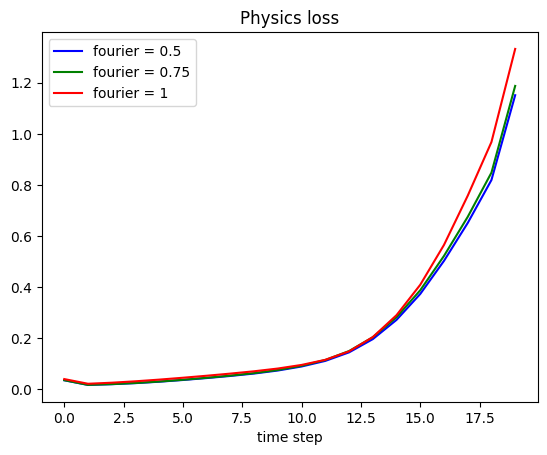

In [122]:
plt.plot(np.arange(len(loss_hist_0_5)), loss_hist_0_5, label='fourier = 0.5', color='blue')
plt.plot(np.arange(len(loss_hist_0_75)), loss_hist_0_75, label='fourier = 0.75', color='green')
plt.plot(np.arange(len(loss_hist_1)), loss_hist_1, label='fourier = 1', color='red')
plt.legend()
plt.title('Physics loss')
plt.xlabel("time step")
plt.show()

Что крайне показательно. С ростом шага по времени, начинается всякая спектральная шляпа: алиасинг и прочее дерьмо и лосс начинает нарастать экспоненциально

Важный нюанс: нельзя просто посчитать весь ковективный член V_scalmul_grad_w в фурье пространстве, а потом взять обратное преобразование, т.к. фурье-образ обычного поэелементного произведения не равен произвдению фурье-образов. Однако фурье-образ свертки двух функций — да равен произведению двух функций.

Еще очень важный нюанс: результат вычисления лосса при fourier = 1 будет ближе всего к результату вычисления конечными разностями если взять dealias к финальному образу (то есть все перемножить, перевести в фурье, потом домножить на деалиас и перевести обратно)

С другой стороны мы здесь приходим к не самому приятному выводу: хорошо когда лосс близок к 0 за счет равного вклада отрицательнных и положительных слагаемых, и совсем не хорошо, когда лосс близок к 0 за счет близости к 0 всех своих слагаемых. У нас здесь именно второй случай: если выключить + V_scalmul_grad_w профиль лосса становится заметно более плоским и "красивым". Если убрать - visc * laplacian_w то вообще ничего не меняется, т.к. очень малая вязкость и этот член всегда близок к 0. 

Возможно стоит обрезать временную ось для обучения PINO скажем на 15-16 шаге, чтобы избежать экспоненциального нарастания лосса.

In [12]:
loss_0_5[1000,...][...,19].shape

torch.Size([32, 32])

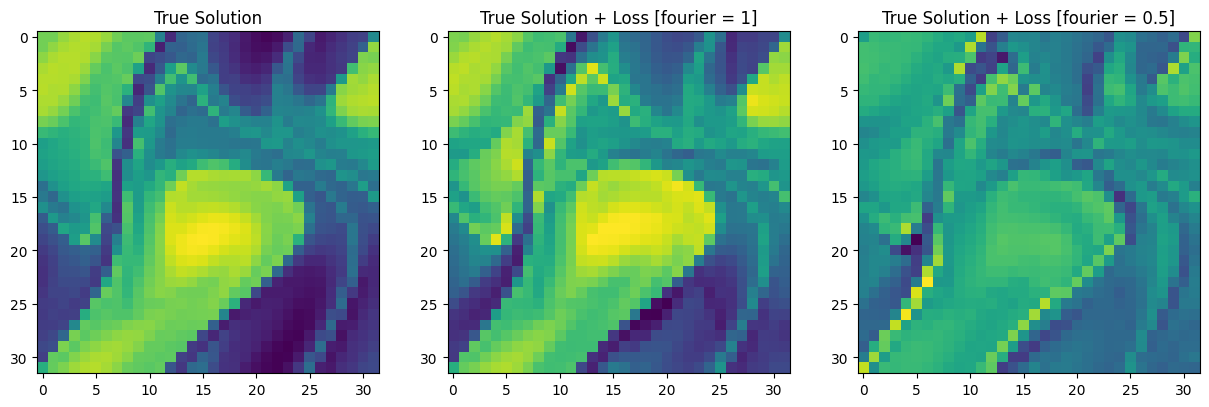

In [28]:
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.title("True Solution")
plt.imshow(w[1000,...][...,19].squeeze(0))
plt.subplot(1,3,2)
plt.title("True Solution + Loss [fourier = 1]")
plt.imshow(w[1000,...][...,19].squeeze(0)+loss_1[1000,...][...,19])
plt.subplot(1,3,3)
plt.title("True Solution + Loss [fourier = 0.5]")
plt.imshow(w[1000,...][...,19].squeeze(0)+loss_0_5[1000,...][...,19])
plt.show()

Хорошо видно, что лосс посчитаный спектральным методом меньше всего искажает решение

In [14]:
t_w = reader.read_field('t')

Сложно сказать, насколько это хороший лосс. Попробуем теперь решатель от авторов.

In [5]:
def navier_stokes_2d(w0, f, visc, T, delta_t=1e-4, record_steps=1, device = 'cpu'):

    f = f.to(device)
    w0 = w0.double().to(device)
    # Grid size - it must be power of 2
    N = w0.size()[-1]

    # Max wavenumber
    k_max = int(np.floor(N/2.0))

    # Total number of steps
    steps = int(np.ceil(T/delta_t))

    # Initial vortex field in Fourier space
    w_h = torch.fft.rfft2(w0)

    # Forcing field in Fourier space
    if f is not None: 
        f_h = torch.fft.rfft2(f)
    else: f_h = 0

    # If the same forcing for the whole batch
    if (f is not None) and (len(f_h.size()) < len(w_h.size())):
        f_h = torch.unsqueeze(f_h, 0)

    # Save the solution every certain number of steps
    record_time = int(np.floor(steps/record_steps))

    # Wave numbers in y-direction
    k_y = torch.cat((torch.arange(start=0, end=k_max, step=1, device=w0.device), torch.arange(start=-k_max, end=0, step=1, device=device)), 0).repeat(N,1).double()
    
    # Wave numbers in x-direction
    k_x = k_y.transpose(0,1)

    # Remove redundant modes
    k_x = k_x[..., :k_max + 1]
    k_y = k_y[..., :k_max + 1]

    # Negative of the Laplacian in Fourier space
    lap = 4*(np.pi**2)*(k_x**2 + k_y**2)
    lap[0,0] = 1.0
    lap = lap.double().to(device)

    # Dealiasing mask
    dealias = torch.unsqueeze(torch.logical_and(torch.abs(k_y) <= (2.0/3.0)*k_max, torch.abs(k_x) <= (2.0/3.0)*k_max).double(), 0)

    # Save the solution and time
    sol = torch.zeros(*w0.size(), record_steps, device=device).double()
    sol_t = torch.zeros(record_steps, device=device)

    #Record counter
    c = 0
    
    #Physical time
    t = 0.0
    for j in range(steps):
        
        #Stream function in Fourier space: solve Poisson equation
        psi_h = w_h / lap

        #Velocity field in x-direction = psi_y
        q = 2. * np.pi * k_y * 1j * psi_h
        q = torch.fft.irfft2(q, s=(N, N))

        #Velocity field in y-direction = -psi_x
        v = -2. * np.pi * k_x * 1j * psi_h
        v = torch.fft.irfft2(v, s=(N, N))

        #Partial x of vorticity
        w_x = 2. * np.pi * k_x * 1j * w_h
        w_x = torch.fft.irfft2(w_x, s=(N, N))

        #Partial y of vorticity
        w_y = 2. * np.pi * k_y * 1j * w_h
        w_y = torch.fft.irfft2(w_y, s=(N, N))

        #Non-linear term (u.grad(w)): compute in physical space then back to Fourier space
        F_h = torch.fft.rfft2(q*w_x + v*w_y)

        #Dealias
        F_h = dealias * F_h

        #Crank-Nicolson update
        w_h = (-delta_t*F_h + delta_t*f_h + (1.0 - 0.5*delta_t*visc*lap)*w_h)/(1.0 + 0.5*delta_t*visc*lap)

        #Update real time (used only for recording)
        t += delta_t

        if (j+1) % record_time == 0:
            #Solution in physical space
            w = torch.fft.irfft2(w_h, s=(N, N))

            #Record solution and time
            sol[...,c] = w
            sol_t[c] = t

            c += 1

    return sol, sol_t

In [6]:
s = 64

#Number of solutions to generate
N = 1

# Time grid
t = torch.linspace(0, 1, s+1)
t = t[0:-1]

# Forcing function: 0.1*(sin(2pi(x+y)) + cos(2pi(x+y)))
X,Y = torch.meshgrid(t, t, indexing='ij')
f = 0.1*(torch.sin(2*np.pi*(X + Y)) + torch.cos(2*np.pi*(X + Y)))

sol, sol_t = navier_stokes_2d(w[1000,...][...,0], f=f, visc=1e-5, T = 20, delta_t=1e-4, record_steps=20, device='cpu')

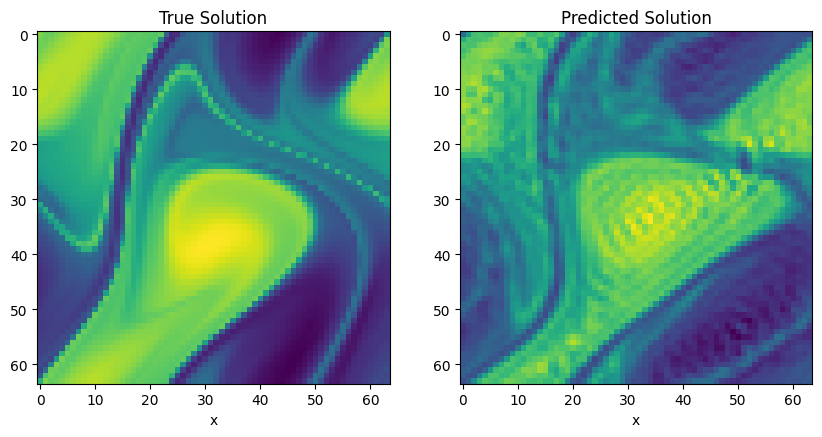

In [7]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.title("True Solution")
plt.xlabel("x")
plt.imshow(w[1000,...][...,19])
plt.subplot(1,2,2)
plt.title("Predicted Solution")
plt.xlabel("x")
plt.imshow(sol[...,19].cpu())
plt.show()


In [20]:
nn.L1Loss()(sol, w[1000,...])

tensor(0.3226, dtype=torch.float64)

* Во-первых нужно очень внимательно отнестись к параметрам, включая временной шаг. Также ОЧЕНЬ влияет на результат корректный учет краевых условий.
* Во-вторых при интегрировании через торч к последним временным шагам начинается жесткий алиасинг, и переход к типу double это проблему не решает
* Из-за этого мы не смогли получить нулевую ошибку полученых решений относительно решений авторов — они генерировали свои решения другим решателем через julia
* В-третьих полученный нами физ-инф лосс получился того же порядка что и ошибка численного интегрирования через торч. Что и понятно, похоже, что мы также сталкиваемся с алиасингом
* В-четвертых это вполне допустимо, т.к. в реальных условиях мы врядли будем знать даже точную форму уравнений (и точные значения параметров) и будем гадать

Из всего сказанного выше следует, что возможно стоит попробовать реализовать какой-то более аккуратный метод решения ур-я Пуассона для psi.

In [ ]:
# torch.save(model, 'naive_4_4_4_fl_1_lift_None_mc_32_pc_64_GELU_lamb_00_E_3000_BS_1_250713.pth')
# torch.save(model, 'naive_12_12_12_fl_2_lift_None_mc_32_pc_64_ReLU_lamb_00_E_470_BS_1_250715.pth')
# torch.save(model, 'naive_12_12_12_fl_4_lift_None_mc_32_pc_64_ReLU_lamb_00_E_100_BS_1_250716.pth')
# torch.save(model, 'naive_12_12_12_fl_8_lift_None_mc_32_pc_64_ReLU_lamb_00_E_100_BS_1_250717.pth')
# torch.save(model, 'naive_24_24_24_fl_4_lift_None_mc_32_pc_64_ReLU_lamb_00_E_100_BS_1_250718.pth')
# torch.save(model, 'naive_12_12_12_fl_8_lift_None_mc_32_pc_64_ReLU_lamb_00_E_200_BS_1_dense_250804.pth')
# torch.save(model, 'naive_12_12_12_fl_8_lift_None_mc_32_pc_64_ReLU_lamb_00_E_200_BS_1_250804.pth')
# torch.save(model, 'downsampled_naive_12_12_12_fl_4_lift_None_mc_32_pc_64_ReLU_lamb_00_E_200_BS_1_sched_250806.pth')
# torch.save(model, 'downsampled_naive_12_12_12_fl_4_lift_None_mc_32_pc_64_ReLU_lamb_00_E_500_BS_1_sched_250808.pth')
# torch.save(model, 'downsampled_naive_12_12_12_fl_8_lift_None_mc_32_pc_64_ReLU_lamb_00_E_300_BS_1_sched_250808.pth')
# torch.save(model, 'downsampled_naive_12_12_12_fl_8_lift_None_mc_32_pc_64_ReLU_lamb_00_E_500_BS_1_sched_250811.pth')
# torch.save(model, 'downsampled_naive_12_12_12_fl_8_lift_None_mc_32_pc_64_ReLU_lamb_00_E_400_BS_1_sched_250813.pth')
# torch.save(model, 'naive_12_12_12_fl_8_lift_None_mc_32_pc_64_ReLU_lamb_00_E_400_BS_1_sched_250815.pth')
# torch.save(model, 'downsampled_naive_12_12_12_fl_8_lift_None_mc_16_pc_32_ReLU_lamb_00_E_400_BS_1_sched_250820.pth')
# torch.save(model, 'downsampled_naive_8_8_8_fl_4_lift_None_mc_24_pc_48_ReLU_lamb_00_E_154_BS_1_sched_250920.pth')
# torch.save(model, 'downsampled_naive_7_7_7_fl_4_lift_None_mc_16_pc_32_ReLU_lamb_00_E_200_BS_1_sched_Broyden_E30_BS_512_sched_250924.pth')
# torch.save(model, 'downsampled_naive_12_12_12_fl_4_lift_None_mc_16_pc_32_ReLU_lamb_00_E_200_BS_1_sched_Broyden_E10_BS_512_250925.pth')
# torch.save(model, 'downsampled_naive_12_12_12_fl_4_lift_None_mc_16_pc_32_ReLU_lamb_0_02_E_200_BS_1_sched_Broyden_E10_BS_512_250926.pth')

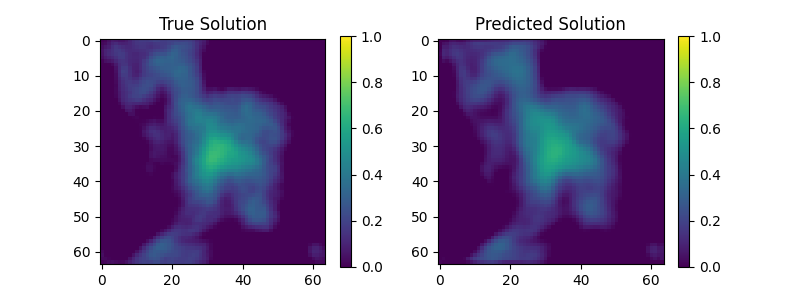

In [21]:
%matplotlib widget
from matplotlib.animation import FuncAnimation

N_sample = 1000

data_path='./NavierStokes_V1e-5_N1200_T20.mat'
reader = MatReader(data_path)
w_true = reader.read_field('u')[N_sample,:,:,:]

GRID_SIZE, GRID_SIZE, TIME_STEPS = w_true.shape

x = torch.linspace(0, 1, GRID_SIZE)
y = torch.linspace(0, 1, GRID_SIZE)
t = torch.linspace(0, 1, TIME_STEPS)

X_, Y_, T_ = torch.meshgrid(x, y, t, indexing='ij')

X = X_.clone().unsqueeze(0).unsqueeze(1).to(device)
Y = Y_.clone().unsqueeze(0).unsqueeze(1).to(device)
T = T_.clone().unsqueeze(0).unsqueeze(1).to(device)

input = torch.cat([X,Y,T], dim=1)

input[0, 0, :, :, 0] = w_true[:,:,0]
input[0, 1, :, :, 0] = w_true[:,:,0].T

with torch.no_grad():
    model.eval()
    output = model(input)
prediction = output[0,0,:,:,:].cpu().numpy()


if __name__ == "__main__":
    

    # Настройка анимации
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3))
    
    # Начальные кадры
    im1 = ax1.imshow(w_true[:, :, 0], cmap='viridis', vmin=0, vmax=1)
    im2 = ax2.imshow(prediction[:, :, 0], cmap='viridis', vmin=0, vmax=1)
    
    ax1.set_title("True Solution")
    ax2.set_title("Predicted Solution")
    fig.colorbar(im1, ax=ax1)
    fig.colorbar(im2, ax=ax2)

    def update(frame):
        # Обновляем данные для каждого кадра
        im1.set_data(w_true[:, :, frame])
        im2.set_data(prediction[:, :, frame])
        return im1, im2

    # Создаем анимацию
    ani = FuncAnimation(
        fig, 
        update, 
        frames=TIME_STEPS,
        interval=200,  # Задержка между кадрами в мс
        blit=False
    )

    # Сохраняем в файл (требуется установка ffmpeg)
    # ani.save('heat_animation.mp4', writer='ffmpeg', fps=5)
    
    plt.show()

In [9]:
ani.save(f'full.gif', writer="pillow", fps=10)

In [ ]:
# model = torch.load('naive_12_12_12_fl_2_lift_None_mc_32_pc_64_ReLU_lamb_00_E_470_BS_1_260715.pth', weights_only=False).to(device)
# model = torch.load('naive_12_12_12_fl_4_lift_None_mc_32_pc_64_ReLU_lamb_00_E_100_BS_1_260715.pth', weights_only=False).to(device)
# model = torch.load('naive_20_20_20_fl_4_lift_None_mc_32_pc_64_ReLU_lamb_00_E_100_BS_1_260716.pth', weights_only=False).to(device)
# model = torch.load('naive_12_12_12_fl_8_lift_None_mc_32_pc_64_ReLU_lamb_00_E_100_BS_1_260717.pth', weights_only=False).to(device)
# model = torch.load('naive_12_12_12_fl_8_lift_None_mc_32_pc_64_ReLU_lamb_00_E_200_BS_1_250804.pth', weights_only=False).to(device)
# model = torch.load('downsampled_naive_12_12_12_fl_8_lift_None_mc_32_pc_64_ReLU_lamb_00_E_400_BS_1_sched_250813.pth', weights_only=False).to(device)
# model = torch.load('downsampled_naive_7_7_7_fl_4_lift_None_mc_16_pc_32_ReLU_lamb_00_E_200_BS_1_sched_Broyden_E30_BS_512_sched_250924.pth', weights_only=False).to(device)
# model = torch.load('downsampled_naive_12_12_12_fl_4_lift_None_mc_32_pc_64_ReLU_lamb_00_E_500_BS_1_sched_250808.pth', weights_only=False).to(device)
# model = torch.load('naive_12_12_12_fl_8_lift_None_mc_32_pc_64_ReLU_lamb_00_E_400_BS_1_sched_250815.pth', weights_only=False).to(device)


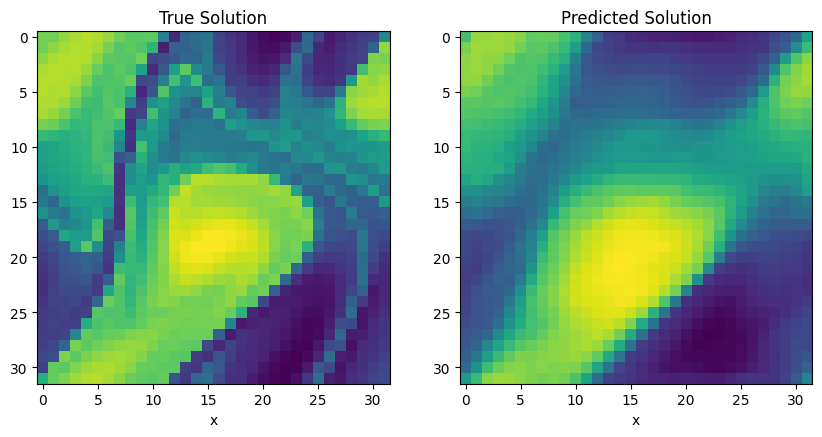

In [44]:
downsample = True

data_path='./NavierStokes_V1e-5_N1200_T20.mat'
reader = MatReader(data_path)
w = reader.read_field('u')
N_samples, GRID_SIZE, GRID_SIZE, TIME_STEPS = w.shape
if downsample:
    w = w.permute(0,3,1,2)
    GRID_SIZE = int(np.floor(GRID_SIZE/2))
    w = F.interpolate(w, size=(GRID_SIZE, GRID_SIZE), mode='bicubic', align_corners=False)
    w = w.permute(0,2,3,1)

with torch.no_grad():    
    w = reader.read_field('u')
    N_samples, GRID_SIZE, GRID_SIZE, TIME_STEPS = w.shape
    if downsample:
        w = w.permute(0,3,1,2)
        GRID_SIZE = int(np.floor(GRID_SIZE/2))
        w = F.interpolate(w, size=(GRID_SIZE, GRID_SIZE), mode='bicubic', align_corners=False)
        w = w.permute(0,2,3,1)
        N_samples, GRID_SIZE, GRID_SIZE, TIME_STEPS = w.shape
    x = torch.linspace(0, 1, GRID_SIZE)
    y = torch.linspace(0, 1, GRID_SIZE)
    t = torch.linspace(0, 1, TIME_STEPS)

    X_, Y_, T_ = torch.meshgrid(x, y, t, indexing='ij')

    X = X_.clone().unsqueeze(0).unsqueeze(1).to(device)
    Y = Y_.clone().unsqueeze(0).unsqueeze(1).to(device)
    T = T_.clone().unsqueeze(0).unsqueeze(1).to(device)
    
    input = torch.cat([X,Y,T], dim=1)

    input[0, 0, :, :, 0] = w[1000,:,:,0]
    input[0, 1, :, :, 0] = w[1000,:,:,0].T


    model.eval()
    output_ = model(input)
    
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.title("True Solution")
plt.xlabel("x")
plt.imshow(w[1000,...][...,19])
plt.subplot(1,2,2)
plt.title("Predicted Solution")
plt.xlabel("x")
plt.imshow(output_[...,19].view(GRID_SIZE,GRID_SIZE).cpu())
plt.show()

In [45]:
# downsampled_naive_7_7_7_fl_4_lift_None_mc_16_pc_32_ReLU_lamb_00_E_200_BS_1_sched_Broyden_E30_BS_512_sched_250924.pth
nn.L1Loss()(output_[0,0,:,:,:].cpu(), w[1000,...])

tensor(0.2231)

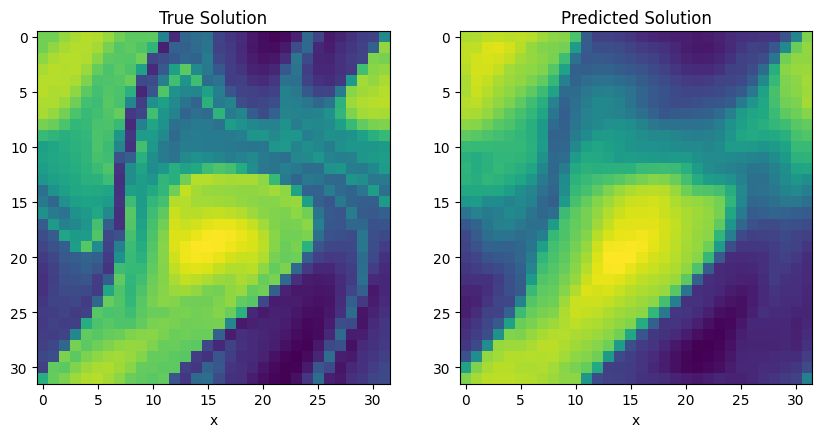

In [31]:
downsample = True

data_path='./NavierStokes_V1e-5_N1200_T20.mat'
reader = MatReader(data_path)
w = reader.read_field('u')
N_samples, GRID_SIZE, GRID_SIZE, TIME_STEPS = w.shape
if downsample:
    w = w.permute(0,3,1,2)
    GRID_SIZE = int(np.floor(GRID_SIZE/2))
    w = F.interpolate(w, size=(GRID_SIZE, GRID_SIZE), mode='bicubic', align_corners=False)
    w = w.permute(0,2,3,1)

with torch.no_grad():    
    w = reader.read_field('u')
    N_samples, GRID_SIZE, GRID_SIZE, TIME_STEPS = w.shape
    if downsample:
        w = w.permute(0,3,1,2)
        GRID_SIZE = int(np.floor(GRID_SIZE/2))
        w = F.interpolate(w, size=(GRID_SIZE, GRID_SIZE), mode='bicubic', align_corners=False)
        w = w.permute(0,2,3,1)
        N_samples, GRID_SIZE, GRID_SIZE, TIME_STEPS = w.shape
    x = torch.linspace(0, 1, GRID_SIZE)
    y = torch.linspace(0, 1, GRID_SIZE)
    t = torch.linspace(0, 1, TIME_STEPS)

    X_, Y_, T_ = torch.meshgrid(x, y, t, indexing='ij')

    X = X_.clone().unsqueeze(0).unsqueeze(1).to(device)
    Y = Y_.clone().unsqueeze(0).unsqueeze(1).to(device)
    T = T_.clone().unsqueeze(0).unsqueeze(1).to(device)
    
    input = torch.cat([X,Y,T], dim=1)

    input[0, 0, :, :, 0] = w[1000,:,:,0]
    input[0, 1, :, :, 0] = w[1000,:,:,0].T


    model.eval()
    output_ = model(input)
    
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.title("True Solution")
plt.xlabel("x")
plt.imshow(w[1000,...][...,19])
plt.subplot(1,2,2)
plt.title("Predicted Solution")
plt.xlabel("x")
plt.imshow(output_[...,19].view(GRID_SIZE,GRID_SIZE).cpu())
plt.show()

In [ ]:
# downsampled_naive_12_12_12_fl_4_lift_None_mc_32_pc_64_ReLU_lamb_00_E_500_BS_1_sched_250808.pth
nn.L1Loss()(output_[0,0,:,:,:].cpu(), w[1000,...])

tensor(0.1502)

Занятно, что доученная Бройденом модель (200+30 эпох) [7,7,7] c подъемом 16/32 показывает ошибку и выразительность почти на уровне модели с [12,12,12] модами и подъемом 32/64, но обучавшуюся 500 эпох но только Адамом

In [35]:
nn.L1Loss()(output_[0,0,:,:,:].cpu(), w[1000,...])

tensor(0.1067)

Это минимальный лосс который пока удалось получить

Попробуем внедрить рассчет всех производных методом конечных разностей. Функцию пси будем рассчитывать методом простых итераций.

In [197]:
visc = 1e-5
data_path='./NavierStokes_V1e-5_N1200_T20.mat'
reader = MatReader(data_path)
w = reader.read_field('u')
N_samples, GRID_SIZE, GRID_SIZE, TIME_STEPS = w.shape
w = w.permute(0,3,1,2)
GRID_SIZE = int(np.floor(GRID_SIZE/2))
w = F.interpolate(w, size=(GRID_SIZE, GRID_SIZE), mode='bicubic', align_corners=False)
w = w.permute(0,2,3,1)
N_samples, GRID_SIZE, GRID_SIZE, TIME_STEPS = w.shape
w = w.unsqueeze(1)

x = torch.linspace(0, 1, GRID_SIZE)
y = torch.linspace(0, 1, GRID_SIZE)
t = torch.linspace(0, 1, TIME_STEPS)

X_, Y_, T_ = torch.meshgrid(x, y, t, indexing='ij')

X = torch.cat(N_samples * [X_.clone().unsqueeze(0)]).unsqueeze(1)
Y = torch.cat(N_samples * [Y_.clone().unsqueeze(0)]).unsqueeze(1)

f = 0.1*(torch.sin(2*np.pi*(X + Y)) + torch.cos(2*np.pi*(X + Y)))

In [ ]:
def compute_t_derivative_finite_diff(w, dt=0.1):
        
        dt_filter = (torch.tensor([[[[-1, 0, 1]]]]).float() / 2.0).contiguous().view(1, 1, 1, 1, 3).to(w.device)
        w_t = F.conv3d(w, dt_filter, padding=(0, 0, 0)) / dt
        
        # из-за отсутствия паддинга размеры тензоров уменьшились. сделаем постпаддинг
        # производная по времени — единственная, для которой мы делаем постпаддинг
        # препаддинг делать не понятно как: периодические условия неприменимы, 0 будет означать обрыв функции, что неверно, продолжение теми же значениями — также проитиворечит физике
        # поэтому мы просто требуем неприрывности производной по времени на краях
        w_t = F.pad(w_t, (1,1, 0,0, 0,0), mode = 'replicate')  # 1,1 — t, 0,0 — y, 0,0 — x с конца

        return w_t
        

def compute_derivatives_finite_diff(w, dx=0.1, dy=0.1):


        dx_filter = (torch.tensor([[[[-1, 0, 1]]]]).float() / 2.0).contiguous().view(1, 1, 3, 1, 1).to(w.device)
        dy_filter = (torch.tensor([[[[-1, 0, 1]]]]).float() / 2.0).contiguous().view(1, 1, 1, 3, 1).to(w.device)

        w_padded_x = F.pad(w, (0,0, 0,0, 1,1), mode = 'circular')  # 0,0 — t, 0,0 — y, 1,1 — x с конца
        w_padded_y = F.pad(w, (0,0, 1,1, 0,0), mode = 'circular')  # 0,0 — t, 1,1 — y, 0,0 — x с конца
        
        w_x = F.conv3d(w_padded_x, dx_filter, padding=(0, 0, 0)) / dx
        w_y = F.conv3d(w_padded_y, dy_filter, padding=(0, 0, 0)) / dy

        return w_x, w_y


def compute_derivatives2_finite_diff(w, dx=0.1, dy=0.1):
        
        #периодические границы
        w_padded_x = F.pad(w, (0,0, 0,0, 1,1), mode = 'circular')  # 0,0 — t, 0,0 — y, 1,1 — x с конца
        w_padded_y = F.pad(w, (0,0, 1,1, 0,0), mode = 'circular')  # 0,0 — t, 1,1 — y, 0,0 — x с конца 

        d2x_filter = (torch.tensor([[[[1, -2, 1]]]]).float()).contiguous().view(1, 1, 3, 1, 1).to(w.device)
        d2y_filter = (torch.tensor([[[[1, -2, 1]]]]).float()).contiguous().view(1, 1, 1, 3, 1).to(w.device)

        w2_x2 = F.conv3d(w_padded_x, d2x_filter, padding=(0, 0, 0)) / dx**2
        w2_y2 = F.conv3d(w_padded_y, d2y_filter, padding=(0, 0, 0)) / dy**2

        return w2_x2, w2_y2



def compute_laplacian(w, dx=0.1, dy=0.1):
        
        #периодические границы
        w_padded = F.pad(w, (0,0, 1,1, 1,1), mode = 'circular')  # 0,0 — t, 0,0 — y, 1,1 — x с конца
        

        # Создаем 3D фильтр лапласиана
        laplace_filter_3d = torch.zeros(1, 1, 3, 3, 3).to(w.device)
        laplace_filter_3d[0,0,:,:,1] = torch.tensor([[[[0, 1, 0],
                                                       [1,-4, 1],
                                                       [0, 1, 0]]]]
                                                       ).float().contiguous()

        #2Д фильтр записан в 1й шаг 3Д фильтра по времени а не в нулевой, чтобы использовать padding = 1 по t,
        #если записать фильтр в нулевой шаг фильтра, то 0 шаг w по времени будет сворачиваться в нули
        #если же использовать padding=0 по t, то слои t=0 и t=T будут при 3d-свертке потеряны
        #то есть по сути наш фильтр - это 3-слойный куб, где первый слой — нули, второй слой — фильтр для 2D-послойной свертки и 3й слой — тоже нули
        laplacian = (F.conv3d(w_padded, laplace_filter_3d, padding=(0,0,1)) / (dx*dy))

        return laplacian

In [214]:
device = 'cpu'
N_samples, channels, GRID_SIZE, GRID_SIZE, TIME_STEPS = w.shape
alpha0 = 0.005
max_iter = 1000

dx, dy = 1/(GRID_SIZE - 1), 1/(GRID_SIZE - 1)
# Параметр релаксации
alpha = alpha0 * dx * dy # 0.025 на 300 итерациях достигает точности 0.058 за 12 минут на сетке 64х64х20 на mps
                        # 0.025 на 300 итерациях достигает точности 0.058 за 7 минут на сетке 64х64х20 на cpu
                        # 0.025 на 300 итерациях достигает точности 0.081 за 2 минуты на сетке 32х32х20 на mps
                        # 0.025 на 300 итерациях достигает точности 0.081 за 1 минуту 10 секунд на сетке 32х32х20 на cpu
                        # 0.020 на 500 итерациях достигает точности 0.055 за 2 минуты на сетке 32х32х20 на cpu
                        # 0.010 на 1000 итерациях достигает точности 0.022 за 23 минуты на сетке 64х64х20 на cpu
                        # 0.005 на 1000 итерациях достигает точности 0.012 за 23 минуты на сетке 64х64х20 на cpu
                        # 0.005 на 1800 итерациях достигает точности 0.014 за 7 минут 10 c на сетке 32х32х20 на cpu                        
                        # 0.005 на 1000 итерациях достигает точности 0.019 за 4 минуты сетке 32х32х20 на cpu 

psi = torch.zeros_like(w).to(device)

for iter in tqdm(range(max_iter), desc="Iterating Poisson equation:"):
        # Вычисляем лапласиан текущего приближения
        laplacian_psi = compute_laplacian(psi, dx=dx, dy=dy)
        residual = laplacian_psi + w

        # Обновление решения
        psi_new = psi + alpha * residual
        change = torch.norm(psi_new - psi).item()
        psi = psi_new

Iterating Poisson equation:: 100%|██████████| 1000/1000 [04:01<00:00,  4.14it/s]


In [216]:
change

0.019123611971735954

In [217]:
psi_x, psi_y = compute_derivatives_finite_diff(psi, dx, dy)
w_x, w_y = compute_derivatives_finite_diff(w, dx, dy)
w_t = compute_t_derivative_finite_diff(w, dt)
laplacian_w = compute_laplacian(w, dx, dy)
Vx = psi_y
Vy = -psi_x
V_scalmul_grad_w = (Vx * w_x + Vy * w_y)
physics_loss_slow = w_t + V_scalmul_grad_w - visc * laplacian_w - f

In [218]:
loss_finite_diff_hist = torch.Tensor([frobenius.mean() for frobenius in np.sqrt(physics_loss_slow.squeeze(1).permute(-1,0,1,2)**2)])

In [219]:
loss_fourier = physics_loss_fast(w, X, Y, dx, dy, dt)
loss_fourier_hist = torch.Tensor([frobenius.mean() for frobenius in np.sqrt(loss_fourier.permute(-1,0,1,2)**2)])

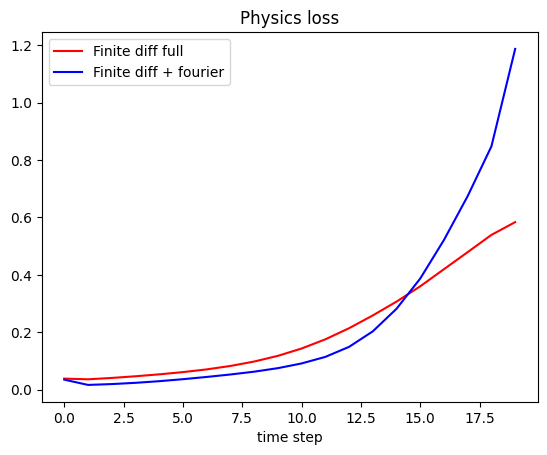

In [220]:
plt.plot(np.arange(len(loss_finite_diff_hist)), loss_finite_diff_hist, label='Finite diff full', color='red')
plt.plot(np.arange(len(loss_fourier_hist)), loss_hist, label='Finite diff + fourier', color='blue')
plt.legend()
plt.title('Physics loss')
plt.xlabel("time step")
plt.show()

Лосс рассчитаный методом простых итераций нарастает квадратично, а спектральный метод дает экспоненциальный рост от времени

Здесь очень показательная история: метод простых итераций дает большую точность при рассчете лосса во времени, при этом работает он в 100 раз дольше (особенно на полноценной сетке 64х64). Плюсом ко всему он очень медленнен на mps и его гораздо выгоднее проворачивать на cpu. В общем, для наших целей мето простых итераций полезен лишь тем, что он показывает, что ошибка в рассчете dw/dt не является критичной для задачи в целом. Нужно искать альтернативу: значительно более быструю, чем метод простых итераций и значительно более точную, чем спектральный метод.

Например, попробуем метод сопряженных градиентов

In [92]:
visc = 1e-5
data_path='./NavierStokes_V1e-5_N1200_T20.mat'
reader = MatReader(data_path)
w = reader.read_field('u')
N_samples, GRID_SIZE, GRID_SIZE, TIME_STEPS = w.shape
w = w.permute(0,3,1,2)
GRID_SIZE = int(np.floor(GRID_SIZE/2))
w = F.interpolate(w, size=(GRID_SIZE, GRID_SIZE), mode='bicubic', align_corners=False)
w = w.permute(0,2,3,1)
N_samples, GRID_SIZE, GRID_SIZE, TIME_STEPS = w.shape
w = w.unsqueeze(1)

x = torch.linspace(0, 1, GRID_SIZE)
y = torch.linspace(0, 1, GRID_SIZE)
t = torch.linspace(0, 1, TIME_STEPS)

X_, Y_, T_ = torch.meshgrid(x, y, t, indexing='ij')

X = torch.cat(N_samples * [X_.clone().unsqueeze(0)]).unsqueeze(1)
Y = torch.cat(N_samples * [Y_.clone().unsqueeze(0)]).unsqueeze(1)

f = 0.1*(torch.sin(2*np.pi*(X + Y)) + torch.cos(2*np.pi*(X + Y)))


dx, dy, dt = 1/(GRID_SIZE - 1), 1/(GRID_SIZE - 1), 1

In [82]:
device='cpu'
# w = w[1000,...]
w = w.to(device)
max_iter = 1000

psi = torch.zeros_like(w)
r = w.clone()  # начальная невязка: r = b - Aψ = w - 0 = w
p = r.clone()
rsold = torch.sum(r * r)

for i in tqdm(range(max_iter)):
    # Применяем оператор A к p
    Ap = -compute_laplacian(p, dx, dy)
    
    # Коэффициент α
    alpha = (rsold / (torch.sum(p * Ap) + 1e-12)) * 0.1
    
    # Обновление решения
    psi = psi + alpha * p
    
    # Обновление невязки
    r = r - alpha * Ap
    
    # Проверка сходимости
    rsnew = torch.sum(r * r)
    # if torch.sqrt(rsnew) < tol:
    #     break
    
    # Коэффициент β и обновление направления
    beta = rsnew / (rsold + 1e-12)
    p = r + beta * p
    rsold = rsnew

100%|██████████| 1000/1000 [03:55<00:00,  4.25it/s]


In [83]:
rsnew

tensor(7300251.)

In [84]:
psi_x, psi_y = compute_derivatives_finite_diff(psi, dx, dy)
w_x, w_y = compute_derivatives_finite_diff(w, dx, dy)
w_t = compute_t_derivative_finite_diff(w, dt)
laplacian_w = compute_laplacian(w, dx, dy)
Vx = psi_y
Vy = -psi_x
V_scalmul_grad_w = (Vx * w_x + Vy * w_y)
physics_loss_slow = w_t - visc * laplacian_w - f + V_scalmul_grad_w

In [85]:
loss_finite_diff_hist = torch.Tensor([frobenius.mean() for frobenius in np.sqrt(physics_loss_slow.squeeze(1).permute(-1,0,1,2)**2)])

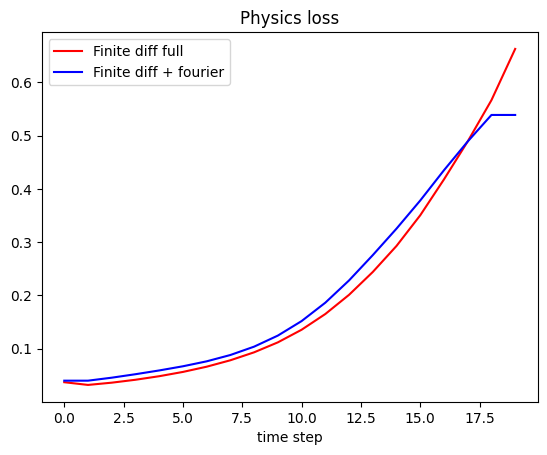

In [86]:
plt.plot(np.arange(len(loss_finite_diff_hist)), loss_finite_diff_hist, label='Finite diff full', color='red')
plt.plot(np.arange(len(loss_hist)), loss_hist, label='Finite diff + fourier', color='blue')
plt.legend()
plt.title('Physics loss')
plt.xlabel("time step")
plt.show()

Попробуем интегрировать все эти методы в решатель и посмотрим, какие у нас получатся результаты.

In [83]:
def compute_derivatives_finite_diff_unbatched(w, dx=0.1, dy=0.1):


        dx_filter = (torch.tensor([[[-1, 0, 1]]]).float() / 2.0).contiguous().view(1, 1, 3, 1).to(w.device)
        dy_filter = (torch.tensor([[[-1, 0, 1]]]).float() / 2.0).contiguous().view(1, 1, 1, 3).to(w.device)

        w_padded_x = F.pad(w, (0,0, 1,1), mode = 'circular')  # 0,0 — y, 1,1 — x с конца
        w_padded_y = F.pad(w, (1,1, 0,0), mode = 'circular')  # 1,1 — y, 0,0 — x с конца
        
        w_x = F.conv2d(w_padded_x, dx_filter, padding=0) / dx
        w_y = F.conv2d(w_padded_y, dy_filter, padding=0) / dy

        return w_x, w_y



def compute_laplacian_unbatched(w, dx=0.1, dy=0.1):
        
        #периодические границы
        w_padded = F.pad(w, (1,1, 1,1), mode = 'circular')  # 1,1 — y, 1,1 — x с конца
        

        # Создаем 2D фильтр лапласиана
        laplace_filter_2d = torch.tensor([[[[0, 1, 0],
                                [1,-4, 1],
                                [0, 1, 0]]]]
                                ).float().contiguous().to(w.device)

        #2Д фильтр записан в 1й шаг 3Д фильтра по времени а не в нулевой, чтобы использовать padding = 1 по t,
        #если записать фильтр в нулевой шаг фильтра, то 0 шаг w по времени будет сворачиваться в нули
        #если же использовать padding=0 по t, то слои t=0 и t=T будут при 3d-свертке потеряны
        #то есть по сути наш фильтр - это 3-слойный куб, где первый слой — нули, второй слой — фильтр для 2D-послойной свертки и 3й слой — тоже нули
        laplacian = (F.conv2d(w_padded, laplace_filter_2d, padding=0) / (dx*dy))

        return laplacian


def iterative_psi_finder_unbatched(w0, dx, dy, alpha0 = 0.005, max_iter = 1000):   # метод простых итераций
        w = w0.clone()
        w = w.cpu()
        N_samples, CHANNELS, GRID_SIZE, GRID_SIZE = w.shape
        dx, dy = 1/(GRID_SIZE - 1), 1/(GRID_SIZE - 1)
        # Параметр релаксации
        alpha = alpha0 * dx * dy 

        psi = torch.zeros_like(w)

        for iter in range(max_iter):
                # Вычисляем лапласиан текущего приближения
                laplacian_psi = compute_laplacian_unbatched(psi, dx=dx, dy=dy)
                residual = laplacian_psi + w

                # Обновление решения
                psi_new = psi + alpha * residual
                psi = psi_new

        return psi.to(w0.device)

def cg_psi_finder_unbatched(w0, dx, dy, alpha0 = 0.1, max_iter = 1000, device='cpu'):  # метод сопряженных градиентов
    """
    Метод предобусловленных сопряженных градиентов
    с диагональным предобусловливателем
    """
    # Корректируем среднее
    mean_w = torch.mean(w0)
    w0 = w0 - mean_w
    
    # Простой диагональный предобусловливатель
    # Для лапласиана на равномерной сетке хороший предобусловливатель - это 1/k² в фурье-пространстве
    # Но мы используем приближение: M ≈ diag(4/dx² + 4/dy²)
    
    diag_value = 4/dx**2 + 4/dy**2  # Диагональный элемент лапласиана
    
    # Предобусловливатель: обратная диагональ
    M_inv = 1.0 / diag_value
    
    # Инициализация
    psi = torch.zeros_like(w0)
    r = w0.clone()
    z = M_inv * r  # Предобусловленная невязка
    p = z.clone()
    
    rsold = torch.sum(r * z)
    
    for i in range(max_iter):
        Ap = -compute_laplacian_unbatched(p, dx, dy)
        
        alpha = rsold / (torch.sum(p * Ap) + 1e-14)
        psi = psi + alpha * p
        r = r - alpha * Ap
        
        # Предобусловливание новой невязки
        z = M_inv * r
        
        rsnew = torch.sum(r * z)       
            
        beta = rsnew / rsold
        p = z + beta * p
        rsold = rsnew
        
    return psi

def fourier_psi_finder_unbatched(w0, dx, dy, alpha0 = 0.1, max_iter = 1000, device='cpu'):  # метод сопряженных градиентов

    w0=w0.cpu()
    samples, CHANNELS, N, N = w0.shape

    # w0 = F.interpolate(w0, size=(N, N), mode='bicubic', align_corners=False)
    # Max wavenumber
    k_max = int(np.floor(N/2.0))

    # Wave numbers in y-direction
    k_y = torch.cat((torch.arange(start=0, end=k_max, step=1, device=w0.device), torch.arange(start=-k_max, end=0, step=1, device=w0.device)), 0).repeat(N,1)
    
    # Wave numbers in x-direction
    k_x = k_y.transpose(0,1)

    # Negative of the Laplacian in Fourier space
    lap = (4*(torch.pi**2)*(k_x**2 + k_y**2))
    lap[0,0] = 1.0

    w_h = torch.fft.fft2(w0)

    # добавляем фильтры

    # k = torch.sqrt(lap)
    # filter_strength=0.8
    # Экспоненциальный фильтр – не особо эффективен
    # filter_mask = torch.exp(-filter_strength * (k / k_max)**4)

    # прогоняем входную функцию через фильтр
    # filter_mask = torch.exp(-filter_strength * (k / k_max)**4)
    # w_h = w_h * filter_mask

    # hyperdiff_coeff=1e-4

    # k_4 = lap**2  # Бигармонический оператор
    
    # Гипердиффузия (очень маленький коэффициент)
    # w_h = w_h * torch.exp(-hyperdiff_coeff * k_4)
    # гипердиффузионный фильтр эффективен для борьбы с алиасиангом, но он искажает само решение


    # Dealiasing mask
    dealias = torch.unsqueeze(torch.logical_and(torch.abs(k_y) <= (2.0/3.0)*k_max, torch.abs(k_x) <= (2.0/3.0)*k_max).float(), 0)

    psi_h = (w_h/lap) * dealias
    # psi_h[0,0] = 1 # по идее уравнение Пуассона интегрируется с точностью до константы и мы здесь можем задать любое значение
    
    psi = (torch.fft.ifft2(psi_h)).real

    return psi


def navier_stokes_2d_new(w0, f, visc, T, alpha0 = 0.005, max_iter = 1000, delta_t=1e-4, record_steps=1, poisson_solver = 'simple',device = 'cpu'):

    sol = torch.zeros(*w0.size(), record_steps, device=device)
    sol_t = torch.zeros(record_steps, device=device)

    f = f.to(device)
    w0 = w0.to(device)
    
    steps = int(np.ceil(T/delta_t))

    # Save the solution every certain number of steps
    record_time = int(np.floor(steps/record_steps))

    c = 0
    t = 0.0

    for j in tqdm(range(steps)):
        if poisson_solver == 'simple': psi = iterative_psi_finder_unbatched(w0, dx, dy, alpha0 = alpha0, max_iter = max_iter) #Ищем функцию пси методом простых итераций
        elif poisson_solver == 'cg' : psi = cg_psi_finder_unbatched(w0, dx, dy, alpha0 = alpha0, max_iter = max_iter, device='device') #Ищем функцию пси методом сопряженных градиентов
        elif poisson_solver == 'fourier': psi = fourier_psi_finder_unbatched(w0, dx, dy, alpha0 = alpha0, max_iter = max_iter, device='device') #Ищем функцию пси спектральным методом
        else: raise ValueError("Unsupported poisson solver. Choose from 'simple', 'fourier' or 'cg'.")

        psi_x, psi_y = compute_derivatives_finite_diff_unbatched(psi, dx, dy)

        w_x, w_y = compute_derivatives_finite_diff_unbatched(w0, dx, dy)
 
        laplacian_w = compute_laplacian_unbatched(w0, dx, dy)
        Vx = psi_y
        Vy = -psi_x

        V_scalmul_grad_w = (Vx * w_x + Vy * w_y)


        # обновление Эйлера
        w1 = (visc * laplacian_w + f - V_scalmul_grad_w) * delta_t + w0

        #Update real time (used only for recording)
        t += delta_t

        if (j+1) % record_time == 0:
            #Solution in physical space
            w = w1

            #Record solution and time
            sol[...,c] = w
            sol_t[c] = t

            c += 1
        
        w0 = w1

    return sol, sol_t

In [84]:
visc = 1e-5
data_path='./NavierStokes_V1e-5_N1200_T20.mat'
reader = MatReader(data_path)
w = reader.read_field('u')

downsample_factor = 2

N_samples, GRID_SIZE, GRID_SIZE, TIME_STEPS = w.shape
w = w.permute(0,3,1,2)
GRID_SIZE = int(np.floor(GRID_SIZE/downsample_factor))
w = F.interpolate(w, size=(GRID_SIZE, GRID_SIZE), mode='bicubic', align_corners=False)
w = w.permute(0,2,3,1)
N_samples, GRID_SIZE, GRID_SIZE, TIME_STEPS = w.shape
w = w.unsqueeze(1)

s = GRID_SIZE

#Number of solutions to generate
N = 1

# Time grid
t = torch.linspace(0, 1, s+1)
t = t[0:-1]

# Forcing function: 0.1*(sin(2pi(x+y)) + cos(2pi(x+y)))
X,Y = torch.meshgrid(t, t, indexing='ij')
f = 0.1*(torch.sin(2*np.pi*(X + Y)) + torch.cos(2*np.pi*(X + Y)))

sol, sol_t = navier_stokes_2d_new(w[1000,...][...,0].unsqueeze(0), f=f, visc=1e-5, T = 20, alpha0 = 0.001, max_iter = 5000, delta_t=1e-4, record_steps=20, poisson_solver = 'simple')

100%|██████████| 200000/200000 [9:37:27<00:00,  5.77it/s]  


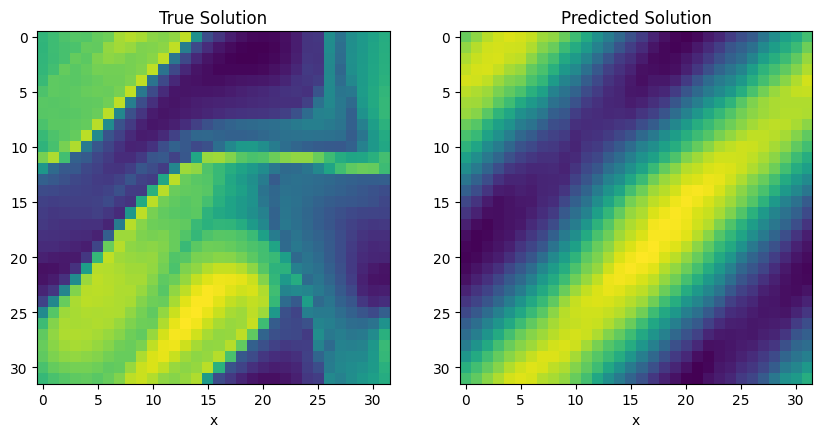

In [85]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.title("True Solution")
plt.xlabel("x")
plt.imshow(w.view(N_samples,GRID_SIZE,GRID_SIZE,TIME_STEPS)[1000,...][...,17])
plt.subplot(1,2,2)
plt.title("Predicted Solution")
plt.xlabel("x")
plt.imshow(sol.view(GRID_SIZE,GRID_SIZE,TIME_STEPS)[...,17].cpu())
plt.show()

Решатель на основе метода простых итераций никуда не годится. Либо проблема в явной схеме, либо — в самом методе простых итераций. Попробуем спектральный метод для пси.

In [174]:
# device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
device = 'cpu'
visc = 1e-5
data_path='./NavierStokes_V1e-5_N1200_T20.mat'
reader = MatReader(data_path)
w = reader.read_field('u')

downsample_factor = 2

N_samples, GRID_SIZE, GRID_SIZE, TIME_STEPS = w.shape
w = w.permute(0,3,1,2)
GRID_SIZE = int(np.floor(GRID_SIZE/downsample_factor))
w = F.interpolate(w, size=(GRID_SIZE, GRID_SIZE), mode='bicubic', align_corners=False)
w = w.permute(0,2,3,1)
N_samples, GRID_SIZE, GRID_SIZE, TIME_STEPS = w.shape
w = w.unsqueeze(1)

s = GRID_SIZE

#Number of solutions to generate
N = 1

# Time grid
t = torch.linspace(0, 1, s+1)
t = t[0:-1]

# Forcing function: 0.1*(sin(2pi(x+y)) + cos(2pi(x+y)))
X,Y = torch.meshgrid(t, t, indexing='ij')
f = 0.1*(torch.sin(2*np.pi*(X + Y)) + torch.cos(2*np.pi*(X + Y)))

data = w[1000,...][...,0].unsqueeze(0).to(device)
sol, sol_t = navier_stokes_2d_new(w[1000,...][...,0].unsqueeze(0), f=f, visc=1e-5, T = 20, alpha0 = 0.005, max_iter = 100, delta_t=1e-4, record_steps=20, poisson_solver = 'fourier')

100%|██████████| 200000/200000 [01:36<00:00, 2080.76it/s]


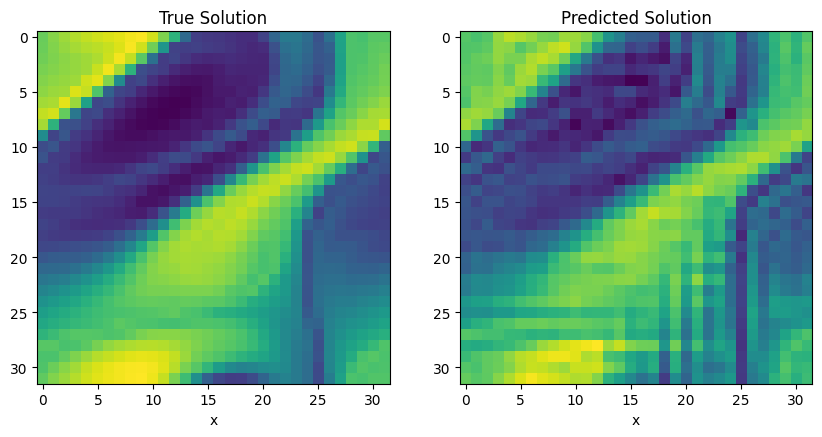

In [187]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.title("True Solution")
plt.xlabel("x")
plt.imshow(w.view(1200,32,32,20)[1000,...][...,15].cpu())
plt.subplot(1,2,2)
plt.title("Predicted Solution")
plt.xlabel("x")
plt.imshow(sol.view(32,32,20)[...,15].cpu())
plt.show()

Итак, проблема в решателе уравнения Пуассона. Явная схема работает ОК.

Вооруживщись этим знанием, попробуем реализовать новый PINO, где учтем что:
* Спектральный метод — единственный передающий необходимые структуры, и это ошибка вычисления (на самом деле они должны затухать)
* Ошибка вычисления функции пси (не зануляется ее нулевая главная гармоника) допущена похоже умышленно именно чтобы запустить развитие диссипативных структур
* Пологий лосс не всегда говорит о хорошей передаче физики. Надо проверять как реализованный метод передает необходимые диссипативные структуры, будучи реализованным в решателе
* Самый пологий лосс получается если все производные считать спектральным методом, при этом спетральный метод передает необходимую физику, поэтому на нем и остановимся

In [5]:
class PINO_advanced(FNO_new):
    def __init__(self, visc = 1e-5, lamb=0.1, calc_finite = True, **kwargs):
        super().__init__(**kwargs)
        self.visc = visc
        self.lamb = lamb 
        self.calc_finite = calc_finite

        self._setup_t_filter()        

    def _setup_t_filter(self):
        
        dx_filter = (torch.tensor([[[[-1, 0, 1]]]]).float() / 2.0).contiguous().view(1, 1, 3, 1, 1)
        dy_filter = (torch.tensor([[[[-1, 0, 1]]]]).float() / 2.0).contiguous().view(1, 1, 1, 3, 1)
        dt_filter = (torch.tensor([[[[-1, 0, 1]]]]).float() / 2.0).contiguous().view(1, 1, 1, 1, 3)
        laplace_filter_3d = torch.zeros(1, 1, 3, 3, 3)
        laplace_filter_3d[0,0,:,:,1] = torch.tensor([[[[0, 1, 0],
                                                       [1,-4, 1],
                                                       [0, 1, 0]]]]
                                                    ).float().contiguous()


        self.register_buffer('dx_f', dx_filter)
        self.register_buffer('dy_f', dy_filter)
        self.register_buffer('dt_f', dt_filter)
        self.register_buffer('laplacian', laplace_filter_3d)
        

    def w_t(self, w, dt=1.0):

        w_t = F.conv3d(w, self.dt_f, padding=(0, 0, 0)) / dt

        # сделаем постпаддинг по t
        w_t = F.pad(w_t, (1,1, 0,0, 0,0), mode = 'replicate')  # 1,1 — t, 0,0 — y, 0,0 — x с конца

        return w_t
    
        

    def compute_derivatives_finite_diff(self, w):

            B, C, GRID_SIZE, GRID_SIZE, T = w.shape
            dx, dy = 1/(GRID_SIZE - 1), 1/(GRID_SIZE - 1)
            w_padded_x = F.pad(w, (0,0, 0,0, 1,1), mode = 'circular')  # 0,0 — t, 0,0 — y, 1,1 — x с конца
            w_padded_y = F.pad(w, (0,0, 1,1, 0,0), mode = 'circular')  # 0,0 — t, 1,1 — y, 0,0 — x с конца
            w_x = F.conv3d(w_padded_x, self.dx_f, padding=(0, 0, 0)) / dx
            w_y = F.conv3d(w_padded_y, self.dy_f, padding=(0, 0, 0)) / dy

            return w_x, w_y


    def compute_laplacian(self, w):
            
            B, C, GRID_SIZE, GRID_SIZE, T = w.shape
            dx, dy = 1/(GRID_SIZE - 1), 1/(GRID_SIZE - 1)
            w_padded = F.pad(w, (0,0, 1,1, 1,1), mode = 'circular')  # 0,0 — t, 0,0 — y, 1,1 — x с конца
            laplacian = F.conv3d(w_padded, self.laplacian, padding=(0,0,1)) / (dx*dy)
            
            return laplacian


    def physics_loss_fast(self, inputs, x, y, dt):  # Вычисляем физическое ограничение dw/dt + (v,grad(w)) - visc * laplasian(w) - f 
        
        if self.lamb > 0:
            f = 0.1*(torch.sin(2*torch.pi*(x + y)) + torch.cos(2*torch.pi*(x + y))) 

            w = inputs.unsqueeze(1)

            B, C, N, N, T = w.shape

            k_max = int(np.floor(N/2))

            F_w = torch.fft.rfft2(w, dim = (2,3))

            k_y = torch.cat((torch.arange(start=0, end=k_max, step=1, device=w.device), torch.arange(start=-k_max, end=0, step=1, device=w.device)), 0).repeat(N,1)
            k_x = k_y.transpose(0,1)

            k_x = k_x[..., :k_max + 1].unsqueeze(-1).expand(-1, -1, T)
            k_y = k_y[..., :k_max + 1].unsqueeze(-1).expand(-1, -1, T)

            F_lap = 4 * (torch.pi**2) * (k_x**2 + k_y**2)
            F_lap[0,0] = 1.0 
            
            dealias = torch.logical_and(torch.abs(k_y) <= (2.0/3.0)*k_max, torch.abs(k_x) <= (2.0/3.0)*k_max).float().to(w.device)

            F_psi = (F_w/F_lap) #* dealias

            if self.calc_finite:
                psi = torch.fft.irfft2(F_psi, dim=(2,3))

                psi_x, psi_y = self.compute_derivatives_finite_diff(psi)
                Vx = psi_y
                Vy = -psi_x

                w_x, w_y = self.compute_derivatives_finite_diff(w)
                w_t = self.w_t(w, dt=dt)

                laplacian_w = self.compute_laplacian(w)

                V_scalmul_grad_w = Vx * w_x + Vy * w_y

                residual = w_t + V_scalmul_grad_w - self.visc * laplacian_w - f

            else:
                F_Vx = 2. * torch.pi * k_y * 1j * F_psi
                F_Vy = - 2. * torch.pi * k_x * 1j * F_psi
                Vx = torch.fft.irfft2(F_Vx, dim=(2,3))
                Vy = torch.fft.irfft2(F_Vy, dim=(2,3))

                F_wx = 2. * torch.pi * k_x * 1j * F_w
                F_wy = 2. * torch.pi * k_y * 1j * F_w
                wx = torch.fft.irfft2(F_wx, dim=(2,3))
                wy = torch.fft.irfft2(F_wy, dim=(2,3))

                F_V_scalmul_grad_w = dealias * torch.fft.rfft2((Vx * wx + Vy * wy), dim = (2,3))

                V_scalmul_grad_w = torch.fft.irfft2(F_V_scalmul_grad_w, dim = (2,3))

                laplacian_w = torch.fft.irfft2(F_lap * F_w, dim=(2,3))
    
                w_t = self.w_t(w, dt=dt)

                residual = w_t + V_scalmul_grad_w - self.visc * laplacian_w - f 

        else: residual = torch.zeros_like(inputs)   

        return (residual**2)*100
    
    
    def forward(self, inputs):
        return super().forward(inputs)
    
    def loss(self, inputs, target, X, Y, dt=1):
        return torch.mean((1 - self.lamb) * nn.L1Loss()(inputs, target) + self.lamb * self.physics_loss_fast(inputs=inputs, x=X, y=Y, dt=dt))
    

def train_FNO_advanced(model, optimizer, scheduler=None, EPOCHS=100, BATCH_SIZE=1, data_path='./NavierStokes_V1e-5_N1200_T20.mat', downsample=False, is_Broyden=False, device='cpu'):   
    
    reader = MatReader(data_path)
    w = reader.read_field('u')
    N_samples, GRID_SIZE, GRID_SIZE, TIME_STEPS = w.shape
    if downsample:
        w = w.permute(0,3,1,2)
        GRID_SIZE = int(np.floor(GRID_SIZE/2))
        w = F.interpolate(w, size=(GRID_SIZE, GRID_SIZE), mode='bicubic', align_corners=False)
        w = w.permute(0,2,3,1)
        N_samples, GRID_SIZE, GRID_SIZE, TIME_STEPS = w.shape


    train_dataset = w[0:1024,...]
    eval_dataset = w[1024:N_samples,...]

    train_loader = DataLoader(TensorDataset(train_dataset), batch_size=BATCH_SIZE, shuffle=True)
    eval_loader = DataLoader(TensorDataset(eval_dataset), batch_size=BATCH_SIZE, shuffle=False)

    dt = 1

    x = torch.linspace(0, 1, GRID_SIZE)
    y = torch.linspace(0, 1, GRID_SIZE)
    t = torch.linspace(0, 1, TIME_STEPS)

    X_, Y_, T_ = torch.meshgrid(x, y, t, indexing='ij')
    
    # Обучение
    loss_hist = []
    epoch_loss_hist = []

    for epoch in tqdm(range(EPOCHS)):
        for solution in train_loader:
            solution = solution[0].to(device)
            BATCH_S, _, _, _ = solution.shape
            X = torch.cat(BATCH_S * [X_.clone().unsqueeze(0)]).unsqueeze(1).to(device)
            Y = torch.cat(BATCH_S * [Y_.clone().unsqueeze(0)]).unsqueeze(1).to(device)
            T = torch.cat(BATCH_S * [T_.clone().unsqueeze(0)]).unsqueeze(1).to(device)                
            input = torch.cat([X,Y,T], dim=1)
            
            # "наивным" образом запишем в x и y начальные условия:
            input[ :, 0, :, :, 0] = solution[:,:,:,0]
            input[ :, 1, :, :, 0] = solution[:,:,:,0].transpose(1,2)

            if is_Broyden:
                def closure():
                    if torch.is_grad_enabled():
                        optimizer.zero_grad()
                    u_pred = model(input).squeeze(1)

                    # Вычисление потерь
                    loss = model.loss(u_pred, solution, X, Y, dt)
                    epoch_loss_hist.append(loss.item())

                    if loss.requires_grad:
                        loss.backward(retain_graph=True)
                    return loss
                optimizer.step(closure)
                if scheduler: scheduler.step()

            else:
                u_pred = model(input).squeeze(1)
                loss = model.loss(u_pred, solution, X, Y, dt)
                epoch_loss_hist.append(loss.item())               
            # Backprop
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        epoch_mean_loss = np.asarray(epoch_loss_hist, dtype=np.float32).mean()
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch + 1}, Loss: {epoch_mean_loss:.4f}")
        loss_hist.append(epoch_mean_loss)
        if not is_Broyden: 
            if scheduler: scheduler.step()
    
    return model, loss_hist


In [4]:
# расчет производных и лапласиана методом конечных разностей, спектральным методом находим только функцию Psi
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
model = PINO_advanced(modes = [4,4,4], 
                     num_fourier_layers=1, 
                     in_channels=3, 
                     mid_channels=8, 
                     projection_channels=16, 
                     out_channels=1, 
                     activation=nn.ReLU(),
                     calc_finite = True,
                     visc=1e-5,  
                     lamb=0.02,
                     ).to(device)

Adam = torch.optim.AdamW(model.parameters(), lr=1e-4)

scheduler_adam = torch.optim.lr_scheduler.StepLR(Adam, step_size=50, gamma=0.5)

model_PINO, loss_hist = train_FNO_advanced(model=model, 
                                            optimizer=Adam,
                                            scheduler=scheduler_adam,
                                            EPOCHS=100, 
                                            BATCH_SIZE=1, 
                                            data_path='./NavierStokes_V1e-5_N1200_T20.mat', 
                                            downsample=True, 
                                            is_Broyden=False,
                                            device=device)

 10%|█         | 10/100 [03:33<32:05, 21.39s/it]

Epoch 10, Loss: 0.5460


 20%|██        | 20/100 [07:08<28:38, 21.48s/it]

Epoch 20, Loss: 0.5102


 30%|███       | 30/100 [10:40<24:28, 20.98s/it]

Epoch 30, Loss: 0.4940


 40%|████      | 40/100 [14:07<20:40, 20.67s/it]

Epoch 40, Loss: 0.4839


 50%|█████     | 50/100 [17:32<17:09, 20.58s/it]

Epoch 50, Loss: 0.4766


 60%|██████    | 60/100 [21:00<14:01, 21.03s/it]

Epoch 60, Loss: 0.4709


 70%|███████   | 70/100 [24:32<10:33, 21.13s/it]

Epoch 70, Loss: 0.4665


 80%|████████  | 80/100 [28:04<07:05, 21.26s/it]

Epoch 80, Loss: 0.4629


 90%|█████████ | 90/100 [31:38<03:34, 21.46s/it]

Epoch 90, Loss: 0.4600


100%|██████████| 100/100 [35:13<00:00, 21.14s/it]

Epoch 100, Loss: 0.4574


In [ ]:
# расчет производных и лапласиана спектральным методом
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
model = PINO_advanced(modes = [4,4,4], 
                     num_fourier_layers=1, 
                     in_channels=3, 
                     mid_channels=8, 
                     projection_channels=16, 
                     out_channels=1, 
                     activation=nn.ReLU(),
                     calc_finite = False,
                     visc=1e-5,  
                     lamb=0.02,
                     ).to(device)

Adam = torch.optim.AdamW(model.parameters(), lr=1e-4)

scheduler_adam = torch.optim.lr_scheduler.StepLR(Adam, step_size=50, gamma=0.5)

model_PINO, loss_hist = train_FNO_advanced(model=model, 
                                            optimizer=Adam,
                                            scheduler=scheduler_adam,
                                            EPOCHS=100, 
                                            BATCH_SIZE=1, 
                                            data_path='./NavierStokes_V1e-5_N1200_T20.mat', 
                                            downsample=True, 
                                            is_Broyden=False,
                                            device=device)

 10%|█         | 10/100 [02:58<26:38, 17.76s/it]

Epoch 10, Loss: 0.5474


 20%|██        | 20/100 [05:55<23:38, 17.73s/it]

Epoch 20, Loss: 0.5119


 30%|███       | 30/100 [08:50<20:24, 17.49s/it]

Epoch 30, Loss: 0.4955


 40%|████      | 40/100 [11:43<17:20, 17.35s/it]

Epoch 40, Loss: 0.4852


 50%|█████     | 50/100 [14:36<14:21, 17.23s/it]

Epoch 50, Loss: 0.4778


 60%|██████    | 60/100 [17:29<11:40, 17.52s/it]

Epoch 60, Loss: 0.4721


 70%|███████   | 70/100 [20:23<08:40, 17.33s/it]

Epoch 70, Loss: 0.4678


 80%|████████  | 80/100 [23:16<05:46, 17.31s/it]

Epoch 80, Loss: 0.4644


 90%|█████████ | 90/100 [26:09<02:53, 17.30s/it]

Epoch 90, Loss: 0.4616


100%|██████████| 100/100 [29:06<00:00, 17.46s/it]

Epoch 100, Loss: 0.4593


In [12]:
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
model = PINO_advanced(modes = [4,4,4], 
                     num_fourier_layers=1, 
                     in_channels=3, 
                     mid_channels=8, 
                     projection_channels=16, 
                     out_channels=1, 
                     activation=nn.ReLU(),
                     calc_finite = True,
                     visc=1e-5,  
                     lamb=0,
                     ).to(device)

Adam = torch.optim.AdamW(model.parameters(), lr=1e-4)

scheduler_adam = torch.optim.lr_scheduler.StepLR(Adam, step_size=50, gamma=0.5)

model_PINO, loss_hist = train_FNO_advanced(model=model, 
                                            optimizer=Adam,
                                            scheduler=scheduler_adam,
                                            EPOCHS=100, 
                                            BATCH_SIZE=1, 
                                            data_path='./NavierStokes_V1e-5_N1200_T20.mat', 
                                            downsample=True, 
                                            is_Broyden=False,
                                            device=device)

 10%|█         | 10/100 [02:40<24:16, 16.19s/it]

Epoch 10, Loss: 0.5225


 20%|██        | 20/100 [05:21<21:22, 16.03s/it]

Epoch 20, Loss: 0.4899


 30%|███       | 30/100 [08:03<18:41, 16.02s/it]

Epoch 30, Loss: 0.4746


 40%|████      | 40/100 [10:41<15:50, 15.85s/it]

Epoch 40, Loss: 0.4648


 50%|█████     | 50/100 [13:15<12:45, 15.32s/it]

Epoch 50, Loss: 0.4577


 60%|██████    | 60/100 [15:59<11:04, 16.60s/it]

Epoch 60, Loss: 0.4523


 70%|███████   | 70/100 [18:44<08:12, 16.43s/it]

Epoch 70, Loss: 0.4481


 80%|████████  | 80/100 [21:29<05:24, 16.24s/it]

Epoch 80, Loss: 0.4448


 90%|█████████ | 90/100 [24:15<02:46, 16.64s/it]

Epoch 90, Loss: 0.4421


100%|██████████| 100/100 [27:03<00:00, 16.24s/it]

Epoch 100, Loss: 0.4397


Видно, что на "игрушечном" примере самый малый лосс дает чистый FNO. Однако, нам еще осталось проверить, насколько хорошо разные операторы восстанавливают данные, которые не входили в обучающую выборку.

Берем модель с премлемой "экспрессивностью" и будем далее изучать ее.

In [10]:
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
model = PINO_advanced(modes = [7,7,7], 
                     num_fourier_layers=4, 
                     in_channels=3, 
                     mid_channels=16, 
                     projection_channels=32, 
                     out_channels=1, 
                     activation=nn.ReLU(),
                     calc_finite = True,
                     visc=1e-5,  
                     lamb=0.02,
                     ).to(device)

Adam = torch.optim.AdamW(model.parameters(), lr=1e-4)

scheduler_adam = torch.optim.lr_scheduler.StepLR(Adam, step_size=100, gamma=0.5)

model_PINO, loss_hist = train_FNO_advanced(model=model, 
                                            optimizer=Adam,
                                            scheduler=scheduler_adam,
                                            EPOCHS=200, 
                                            BATCH_SIZE=1, 
                                            data_path='./NavierStokes_V1e-5_N1200_T20.mat', 
                                            downsample=True, 
                                            is_Broyden=False,
                                            device=device)

  5%|▌         | 10/200 [06:53<2:11:59, 41.68s/it]

Epoch 10, Loss: 0.4072


 10%|█         | 20/200 [13:45<2:03:29, 41.16s/it]

Epoch 20, Loss: 0.3738


 15%|█▌        | 30/200 [20:33<1:55:34, 40.79s/it]

Epoch 30, Loss: 0.3562


 20%|██        | 40/200 [27:20<1:48:38, 40.74s/it]

Epoch 40, Loss: 0.3432


 25%|██▌       | 50/200 [34:08<1:41:49, 40.73s/it]

Epoch 50, Loss: 0.3325


 30%|███       | 60/200 [40:55<1:35:00, 40.72s/it]

Epoch 60, Loss: 0.3233


 35%|███▌      | 70/200 [47:42<1:28:17, 40.75s/it]

Epoch 70, Loss: 0.3154


 40%|████      | 80/200 [54:31<1:22:00, 41.00s/it]

Epoch 80, Loss: 0.3085


 45%|████▌     | 90/200 [1:01:21<1:15:15, 41.05s/it]

Epoch 90, Loss: 0.3025


 50%|█████     | 100/200 [1:08:12<1:08:24, 41.05s/it]

Epoch 100, Loss: 0.2972


 55%|█████▌    | 110/200 [1:15:00<1:01:03, 40.70s/it]

Epoch 110, Loss: 0.2923


 60%|██████    | 120/200 [1:21:46<54:12, 40.66s/it]  

Epoch 120, Loss: 0.2880


 65%|██████▌   | 130/200 [1:28:33<47:26, 40.67s/it]

Epoch 130, Loss: 0.2842


 70%|███████   | 140/200 [1:35:20<40:40, 40.68s/it]

Epoch 140, Loss: 0.2808


 75%|███████▌  | 150/200 [1:42:06<33:53, 40.68s/it]

Epoch 150, Loss: 0.2777


 80%|████████  | 160/200 [1:48:53<27:07, 40.68s/it]

Epoch 160, Loss: 0.2749


 85%|████████▌ | 170/200 [1:55:40<20:21, 40.71s/it]

Epoch 170, Loss: 0.2724


 90%|█████████ | 180/200 [2:02:29<13:38, 40.92s/it]

Epoch 180, Loss: 0.2701


 95%|█████████▌| 190/200 [2:09:22<06:53, 41.37s/it]

Epoch 190, Loss: 0.2679


100%|██████████| 200/200 [2:16:15<00:00, 40.88s/it]

Epoch 200, Loss: 0.2659


In [11]:
Broyden = torch.optim.LBFGS(model.parameters(), 
                                lr=0.03, 
                                history_size=200,
                                max_iter=40, 
                                line_search_fn='strong_wolfe')

model_PINO2, loss_hist2 = train_FNO_advanced(model=model, 
                                            optimizer=Broyden,
                                            scheduler=None,
                                            EPOCHS=10, 
                                            BATCH_SIZE=512, 
                                            data_path='./NavierStokes_V1e-5_N1200_T20.mat', 
                                            downsample=True, 
                                            is_Broyden=True,
                                            device=device)

100%|██████████| 10/10 [1:14:39<00:00, 447.93s/it]

Epoch 10, Loss: 0.2246


In [ ]:
# torch.save(model, 'downsampled_finite_naive_7_7_7_fl_4_lift_None_mc_16_pc_32_ReLU_lamb_0_02_E_200_BS_1_sched_Broyden_E10_BS_512_250929.pth')

In [4]:
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
model = PINO_advanced(modes = [7,7,7], 
                     num_fourier_layers=4, 
                     in_channels=3, 
                     mid_channels=16, 
                     projection_channels=32, 
                     out_channels=1, 
                     activation=nn.ReLU(),
                     calc_finite = True,
                     visc=1e-5,  
                     lamb=0,
                     ).to(device)

Adam = torch.optim.AdamW(model.parameters(), lr=1e-4)

scheduler_adam = torch.optim.lr_scheduler.StepLR(Adam, step_size=100, gamma=0.5)

model_PINO, loss_hist = train_FNO_advanced(model=model, 
                                            optimizer=Adam,
                                            scheduler=scheduler_adam,
                                            EPOCHS=200, 
                                            BATCH_SIZE=1, 
                                            data_path='./NavierStokes_V1e-5_N1200_T20.mat', 
                                            downsample=True, 
                                            is_Broyden=False,
                                            device=device)

  5%|▌         | 10/200 [06:15<1:58:54, 37.55s/it]

Epoch 10, Loss: 0.3752


 10%|█         | 20/200 [12:31<1:52:39, 37.55s/it]

Epoch 20, Loss: 0.3379


 15%|█▌        | 30/200 [18:46<1:46:24, 37.56s/it]

Epoch 30, Loss: 0.3179


 20%|██        | 40/200 [25:02<1:40:06, 37.54s/it]

Epoch 40, Loss: 0.3033


 25%|██▌       | 50/200 [31:17<1:33:52, 37.55s/it]

Epoch 50, Loss: 0.2916


 30%|███       | 60/200 [37:33<1:27:35, 37.54s/it]

Epoch 60, Loss: 0.2817


 35%|███▌      | 70/200 [43:48<1:21:21, 37.55s/it]

Epoch 70, Loss: 0.2734


 40%|████      | 80/200 [50:04<1:15:05, 37.55s/it]

Epoch 80, Loss: 0.2662


 45%|████▌     | 90/200 [56:19<1:08:49, 37.54s/it]

Epoch 90, Loss: 0.2600


 50%|█████     | 100/200 [1:02:34<1:02:33, 37.54s/it]

Epoch 100, Loss: 0.2544


 55%|█████▌    | 110/200 [1:08:50<56:20, 37.56s/it]  

Epoch 110, Loss: 0.2493


 60%|██████    | 120/200 [1:15:05<50:02, 37.54s/it]

Epoch 120, Loss: 0.2448


 65%|██████▌   | 130/200 [1:21:21<43:48, 37.55s/it]

Epoch 130, Loss: 0.2409


 70%|███████   | 140/200 [1:27:36<37:33, 37.55s/it]

Epoch 140, Loss: 0.2374


 75%|███████▌  | 150/200 [1:33:52<31:16, 37.53s/it]

Epoch 150, Loss: 0.2342


 80%|████████  | 160/200 [1:40:07<25:01, 37.55s/it]

Epoch 160, Loss: 0.2313


 85%|████████▌ | 170/200 [1:46:26<18:56, 37.89s/it]

Epoch 170, Loss: 0.2287


 90%|█████████ | 180/200 [1:52:45<12:38, 37.90s/it]

Epoch 180, Loss: 0.2263


 95%|█████████▌| 190/200 [1:59:04<06:18, 37.89s/it]

Epoch 190, Loss: 0.2240


100%|██████████| 200/200 [2:05:23<00:00, 37.62s/it]

Epoch 200, Loss: 0.2220


In [5]:
Broyden = torch.optim.LBFGS(model.parameters(), 
                                lr=0.04, 
                                history_size=200,
                                max_iter=40, 
                                line_search_fn='strong_wolfe')

model_PINO2, loss_hist2 = train_FNO_advanced(model=model, 
                                            optimizer=Broyden,
                                            scheduler=None,
                                            EPOCHS=10, 
                                            BATCH_SIZE=512, 
                                            data_path='./NavierStokes_V1e-5_N1200_T20.mat', 
                                            downsample=True, 
                                            is_Broyden=True,
                                            device=device)

100%|██████████| 10/10 [46:35<00:00, 279.56s/it] 

Epoch 10, Loss: 0.1792


In [ ]:
# torch.save(model, 'downsampled_finite_naive_7_7_7_fl_4_lift_None_mc_16_pc_32_ReLU_lamb_0_0_E_200_BS_1_sched_Broyden_E10_BS_512_250930.pth')

In [47]:
lamb_range = (0,0.1)
lamb_step = 0.02
for lamb_i in np.arange(lamb_range[0], lamb_range[1], lamb_step): print(type(lamb_i), lamb_i)


<class 'numpy.float64'> 0.0
<class 'numpy.float64'> 0.02
<class 'numpy.float64'> 0.04
<class 'numpy.float64'> 0.06
<class 'numpy.float64'> 0.08


In [46]:
np.arange(0.0, 0.1, 0.02)

array([0.  , 0.02, 0.04, 0.06, 0.08])

In [34]:
int(np.floor(lamb_range[1]/lamb_step)-1)

4

In [37]:
torch.linspace(lamb_range[0], lamb_range[1], int(np.floor(lamb_range[1]/lamb_step)+1))

tensor([0.0000, 0.0200, 0.0400, 0.0600, 0.0800, 0.1000])

In [ ]:
scipy.io.savemat('ns_data.mat', mdict={'a': a.cpu().numpy(), 'u': u.cpu().numpy(), 't': sol_t.cpu().numpy()})

In [23]:
# model = torch.load('downsampled_finite_naive_7_7_7_fl_4_lift_None_mc_16_pc_32_ReLU_lamb_0_02_E_200_BS_1_sched_Broyden_E10_BS_512_250929.pth', weights_only=False).to(device) # 0.02 PINO
model = torch.load('downsampled_finite_naive_7_7_7_fl_4_lift_None_mc_16_pc_32_ReLU_lamb_0_0_E_200_BS_1_sched_Broyden_E10_BS_512_250930.pth', weights_only=False).to(device) # 0 PINO

In [ ]:
downsample = True

BATCH_SIZE = 1
data_path='./NavierStokes_V1e-5_N1200_T20.mat'
reader = MatReader(data_path)
w = reader.read_field('u')
N_samples, GRID_SIZE, GRID_SIZE, TIME_STEPS = w.shape
if downsample:
    w = w.permute(0,3,1,2)
    GRID_SIZE = int(np.floor(GRID_SIZE/2))
    w = F.interpolate(w, size=(GRID_SIZE, GRID_SIZE), mode='bicubic', align_corners=False)
    w = w.permute(0,2,3,1)
    N_samples, GRID_SIZE, GRID_SIZE, TIME_STEPS = w.shape

eval_dataset = w[1024:N_samples,...]
eval_loader = DataLoader(TensorDataset(eval_dataset), batch_size=BATCH_SIZE, shuffle=False)

x = torch.linspace(0, 1, GRID_SIZE)
y = torch.linspace(0, 1, GRID_SIZE)
t = torch.linspace(0, 1, TIME_STEPS)

X_, Y_, T_ = torch.meshgrid(x, y, t, indexing='ij')
    




100%|██████████| 176/176 [00:02<00:00, 66.75it/s]


In [ ]:
torch.Tensor(metric_history).mean() # 0.02 PINO

tensor(0.2166)

In [25]:
torch.Tensor(metric_history).mean() # 0 PINO

tensor(0.1917)

Хорошо видно, что на валидации PINO показывает ровно такой же результат как и на трейне

In [8]:
downsample = True
samples_to_train = 512
adam_batch = 1

BATCH_SIZE = 1
data_path='./NavierStokes_V1e-5_N1200_T20.mat'
reader = MatReader(data_path)
w = reader.read_field('u')
N_samples, GRID_SIZE, GRID_SIZE, TIME_STEPS = w.shape

if downsample:
    w = w.permute(0,3,1,2)
    GRID_SIZE = int(np.floor(GRID_SIZE/2))
    w = F.interpolate(w, size=(GRID_SIZE, GRID_SIZE), mode='bicubic', align_corners=False)
    w = w.permute(0,2,3,1)
    N_samples, GRID_SIZE, GRID_SIZE, TIME_STEPS = w.shape

np.random.seed(333)
all_idx = np.arange(N_samples)
train_idx = np.random.choice(all_idx, int(samples_to_train))
eval_idx = all_idx[~np.in1d(all_idx, train_idx)]

train_dataset = w[train_idx,:,:, :10]
eval_dataset = w[eval_idx,:,:, :10]

train_loader = DataLoader(TensorDataset(train_dataset), batch_size=adam_batch, shuffle=True)
eval_loader = DataLoader(TensorDataset(eval_dataset), batch_size=adam_batch, shuffle=False)

x = torch.linspace(0, 1, GRID_SIZE)
y = torch.linspace(0, 1, GRID_SIZE)
t = torch.linspace(0, 1, TIME_STEPS)

X_, Y_, T_ = torch.meshgrid(x, y, t, indexing='ij')

In [9]:
train_dataset.shape

torch.Size([512, 32, 32, 10])